# Load thư viện

In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tabulate import tabulate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import SimpleRNN

from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import pandas_datareader.data as web

# Chuẩn bị dữ liệu

In [3]:
stock_name = "MANU"

In [4]:
raw_data = web.DataReader(stock_name,data_source="yahoo",start="01/01/2005",end="01/01/2019").dropna()

In [5]:
raw_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1607.000000,1607.000000,1607.000000,1607.000000,1.607000e+03,1607.000000
mean,17.324294,16.875924,17.102620,17.084941,9.891637e+04,16.007120
std,2.256755,2.174038,2.217825,2.216720,8.117236e+05,2.213693
min,12.350000,12.000000,12.060000,12.180000,1.600000e+03,11.291115
25%,16.035001,15.700000,15.860000,15.850000,2.165000e+04,14.762630
50%,17.070000,16.650000,16.870001,16.850000,3.780000e+04,15.713005
75%,18.299999,17.835000,18.100000,18.070000,7.050000e+04,16.856253
max,27.700001,25.780001,26.049999,26.200001,3.184620e+07,25.054594


(1607, 1)             Close
Date             
2012-08-10  14.00
2012-08-13  14.15
2012-08-14  14.20
2012-08-15  14.05
2012-08-16  13.77


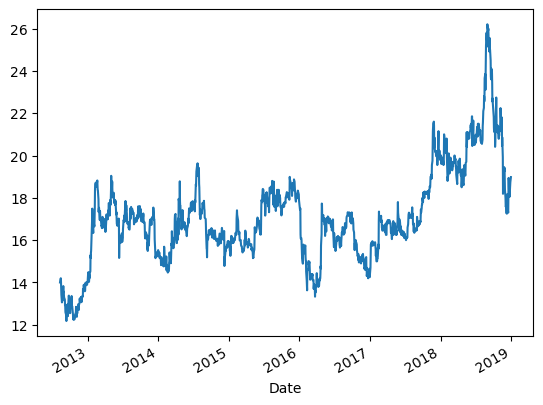

In [6]:
df = raw_data.dropna()
df = df[['Close']]
first_price = df.Close.iloc[0]
print(df.shape, df.head())

df.Close.plot()
def create_ds(ds, look_back):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back-1): 
        data = ds[i:(i+look_back), 0]      
        dataX.append(data)
        dataY.append(ds[i + look_back, 0]) 
    return np.array(dataX), np.array(dataY)

ds = df.values
ds = ds.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

In [7]:
#  Chia tập train và tập test theo ty lệ 0.85, 0.15
# train_size = int(len(ds) * 0.85)
# test_size = len(ds) - train_size
# train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]

# outline

#### 1:
#### Đầu vào: train, test, look_back, opt, epochs, batch_size, validation_split
#### Đầu ra: Trained model
#### 2:
#### Đầu vào: 4 trained models
#### Đầu ra: 4 plots + bảng so sánh độ chính xác

# Xây dựng models

In [8]:
def create_train_test_data(train, test, look_back):
    trainX, trainY = create_ds(train, look_back)
    testX, testY = create_ds(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    return trainX, trainY, testX, testY

In [9]:
# trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)

In [10]:
# hidden_nodes = math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3)

## FFNN

In [11]:
def create_ffnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_ffnn = Sequential()
    model_ffnn.add(Dense(hidden_nodes, input_shape = (trainX.shape[1],trainX.shape[2]), activation = 'relu', kernel_initializer='uniform'))
#     model_ffnn.add(Dropout(0.4))
#     model_ffnn.add(Dense(400, activation = 'relu', kernel_initializer='uniform' ))
#     model_ffnn.add(Dropout(0.3))
#     model_ffnn.add(Dense(150, activation = 'relu' ))
#     model_ffnn.add(Dropout(0.3))
#     model_ffnn.add(Dense(100, activation = 'hard_sigmoid' ))
#     model_ffnn.add(Dropout(0.2))
#     model_ffnn.add(Dense(50, activation = 'relu' ))
#     model_ffnn.add(Dropout(0.1))
#     model_ffnn.add(Dense(10, activation = 'relu' ))
    model_ffnn.add(Flatten())
    model_ffnn.add(Dense(1, activation = 'relu'))
    # train created model
    model_ffnn.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_ffnn.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_ffnn.summary()
    delta = time.time() - start
    return delta, model_ffnn

## RNN

In [12]:
def create_rnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units = hidden_nodes, activation = "tanh", return_sequences = True, input_shape = (look_back,1)))
#     model_rnn.add(Dropout(0.3))
#     model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
#     model_rnn.add(Dropout(0.2))
#     model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
#     model_rnn.add(Dropout(0.1))
#     model_rnn.add(SimpleRNN(units = 50))
    model_rnn.add(Flatten())
    model_rnn.add(Dense(units = 1))
    # train created model
    model_rnn.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_rnn.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_rnn.summary()
    delta = time.time() - start
    return delta, model_rnn

## LSTM

In [13]:
def create_lstm_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_lstm = Sequential()
    model_lstm.add(LSTM(hidden_nodes, activation = 'tanh', input_shape=(look_back,1),return_sequences=True))
    model_lstm.add(Flatten())
    model_lstm.add(Dense(1, activation = 'relu'))
    # train created model
    model_lstm.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_lstm.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_lstm.summary()
    delta = time.time() - start
    return delta, model_lstm

## GRU

In [14]:
def create_gru_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_gru = Sequential()
    model_gru.add(GRU(hidden_nodes, activation='tanh', recurrent_activation='sigmoid', input_shape=(look_back,1), return_sequences=True)) 
    model_gru.add(Flatten())
    model_gru.add(Dense(1, activation = 'relu'))
    # train created model
    model_gru.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_gru.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_gru.summary()
    delta = time.time() - start
    return delta, model_gru

# Trực quan hóa, so sánh

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [16]:
def create_accuracy(trained_model, scaler, trainX, trainY, testX, testY):
    trainPredict = trained_model.predict(trainX)
    testPredict = trained_model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    mse, mae, mape, rmse = calculate_performance(trainY[0],trainPredict[:, 0])
    return mse, mae, mape, rmse, trainPredict, testPredict

In [17]:
def create_plot(ds, trainPredict, testPredict, scaler, look_back, model_name, stock_name):
    trainPredictPlot = np.empty_like(ds)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(ds)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

    plt.style.use('ggplot')
    plt.figure(figsize=(13,7), dpi=110)
    plt.grid(color='grey', linestyle='dashed')
    plt.xlabel("{0} result".format(model_name))
    plt.ylabel('{0}'.format(stock_name),rotation=90)
    plt.plot(scaler.inverse_transform(ds), label = 'Actual Closing Prices', linewidth = 1.2, color = 'c')
    plt.plot(trainPredictPlot, label = 'A.I. Train Data Price Predictions_After fit', linewidth = 0.9, color = 'k')
    plt.plot(testPredictPlot, label = 'A.I. Test Data Price Predictions', linewidth = 0.9, color = 'r')
    legend = plt.legend(fontsize = 12,frameon = True)
    legend.get_frame().set_edgecolor('b')
    legend.get_frame().set_linewidth(0.4)

    plt.show()

# Thực nghiệm

In [18]:
look_back = 10
opt = Adam(learning_rate=0.0001)
import itertools
def get_combinations(parameters):
    return list(itertools.product(*parameters))

In [19]:
#dataset_ratio, epoch, batch_size, validation
information_FFNN_df = []
information_RNN_df = []
information_LSTM_df = []
information_GRU_df = []
params = [[0.6, 0.7, 0.8], [50, 100, 200], [32], [0.1, 0.15, 0.2]]
# params = [[0.8], [1, 2], [32], [0.15]]
params = get_combinations(params)
for p in params:
    ratio = p[0]
    train_size = int(len(ds) * ratio)
    test_size = len(ds) - train_size
    train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]
    trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)
    
    epochs = p[1]
    batch_size= p[2]
    validation_split= p[3]
    
    
    delta_ffnn, model_ffnn = create_ffnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    delta_rnn, model_rnn = create_rnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    delta_lstm, model_lstm = create_lstm_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    delta_gru, model_gru =create_gru_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    
    models_bag = {
        "FFNN": model_ffnn,
        "RNN": model_rnn,
        "LSTM": model_lstm,
        "GRU": model_gru
    }
    
    accuracy_bag = {}
    
    for model_name, trained_model in models_bag.items():
        if model_name == 'FFNN':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_ffnn]
            information_FFNN_df.append(info)
        elif model_name == 'RNN':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_rnn]
            information_RNN_df.append(info)
        elif model_name == 'LSTM':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_lstm]
            information_LSTM_df.append(info)
        elif model_name == 'GRU':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_gru]
            information_GRU_df.append(info)

Epoch 1/50
27/27 [==============================] - 1s 9ms/step - loss: 0.0804 - val_loss: 0.0379
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0621 - val_loss: 0.0272
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0449 - val_loss: 0.0175
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0294 - val_loss: 0.0101
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0058
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0046
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 8/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 9/50
27/27 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 10/50
27/27 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 11/50
27/27 [

27/27 [==============================] - 0s 3ms/step - loss: 6.8665e-04 - val_loss: 0.0010
Epoch 25/50
27/27 [==============================] - 0s 3ms/step - loss: 6.6029e-04 - val_loss: 9.9642e-04
Epoch 26/50
27/27 [==============================] - 0s 3ms/step - loss: 6.9780e-04 - val_loss: 0.0010
Epoch 27/50
27/27 [==============================] - 0s 3ms/step - loss: 6.8486e-04 - val_loss: 9.9598e-04
Epoch 28/50
27/27 [==============================] - 0s 3ms/step - loss: 6.8424e-04 - val_loss: 9.5530e-04
Epoch 29/50
27/27 [==============================] - 0s 3ms/step - loss: 6.5023e-04 - val_loss: 9.4626e-04
Epoch 30/50
27/27 [==============================] - 0s 3ms/step - loss: 6.2913e-04 - val_loss: 9.3819e-04
Epoch 31/50
27/27 [==============================] - 0s 3ms/step - loss: 6.5507e-04 - val_loss: 9.5791e-04
Epoch 32/50
27/27 [==============================] - 0s 3ms/step - loss: 6.3287e-04 - val_loss: 9.5141e-04
Epoch 33/50
27/27 [==============================] - 0s 3

27/27 [==============================] - 0s 6ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 47/50
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 48/50
27/27 [==============================] - 0s 6ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 49/50
27/27 [==============================] - 0s 6ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 50/50
27/27 [==============================] - 0s 6ms/step - loss: 0.1038 - val_loss: 0.0572
Thời gian huấn luyện:  10.01625108718872
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 89)            32396     
                                                                 
 flatten_2 (Flatten)         (None, 890)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 891

Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 9/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 10/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 11/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 12/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 13/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 14/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 15/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 16/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 17/50
2

26/26 [==============================] - 0s 3ms/step - loss: 6.6491e-04 - val_loss: 9.2838e-04
Epoch 31/50
26/26 [==============================] - 0s 3ms/step - loss: 6.6715e-04 - val_loss: 9.8867e-04
Epoch 32/50
26/26 [==============================] - 0s 4ms/step - loss: 6.6226e-04 - val_loss: 9.9147e-04
Epoch 33/50
26/26 [==============================] - 0s 3ms/step - loss: 6.5714e-04 - val_loss: 9.3018e-04
Epoch 34/50
26/26 [==============================] - 0s 3ms/step - loss: 6.3404e-04 - val_loss: 9.1229e-04
Epoch 35/50
26/26 [==============================] - 0s 3ms/step - loss: 6.4514e-04 - val_loss: 9.2228e-04
Epoch 36/50
26/26 [==============================] - 0s 4ms/step - loss: 6.4389e-04 - val_loss: 8.8275e-04
Epoch 37/50
26/26 [==============================] - 0s 4ms/step - loss: 6.4452e-04 - val_loss: 9.2161e-04
Epoch 38/50
26/26 [==============================] - 0s 3ms/step - loss: 6.5999e-04 - val_loss: 8.7330e-04
Epoch 39/50
26/26 [==============================

 lstm_1 (LSTM)               (None, 10, 89)            32396     
                                                                 
 flatten_6 (Flatten)         (None, 890)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 891       
                                                                 
Total params: 33,287
Trainable params: 33,287
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
26/26 [==============================] - 2s 19ms/step - loss: 0.0180 - val_loss: 0.0030
Epoch 2/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 3/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0

Epoch 14/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 15/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 16/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 17/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 18/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 19/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 20/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 21/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 22/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 23/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 24/5

24/24 [==============================] - 0s 4ms/step - loss: 8.5311e-04 - val_loss: 0.0011
Epoch 38/50
24/24 [==============================] - 0s 4ms/step - loss: 8.6585e-04 - val_loss: 0.0012
Epoch 39/50
24/24 [==============================] - 0s 4ms/step - loss: 8.3841e-04 - val_loss: 0.0010
Epoch 40/50
24/24 [==============================] - 0s 4ms/step - loss: 8.3447e-04 - val_loss: 0.0011
Epoch 41/50
24/24 [==============================] - 0s 4ms/step - loss: 8.5517e-04 - val_loss: 0.0011
Epoch 42/50
24/24 [==============================] - 0s 4ms/step - loss: 8.5914e-04 - val_loss: 0.0010
Epoch 43/50
24/24 [==============================] - 0s 4ms/step - loss: 8.9742e-04 - val_loss: 0.0010
Epoch 44/50
24/24 [==============================] - 0s 4ms/step - loss: 8.0900e-04 - val_loss: 9.9840e-04
Epoch 45/50
24/24 [==============================] - 0s 4ms/step - loss: 8.1820e-04 - val_loss: 9.9867e-04
Epoch 46/50
24/24 [==============================] - 0s 4ms/step - loss: 8.20

Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 7/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 8/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 11/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 12/50
24/24 

27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 22/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 23/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 24/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 25/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 26/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 27/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 28/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 29/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 30/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 31/100


 dense_15 (Dense)            (None, 10, 89)            178       
                                                                 
 flatten_12 (Flatten)        (None, 890)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 891       
                                                                 
Total params: 1,069
Trainable params: 1,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 1s 8ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 0

27/27 [==============================] - 0s 3ms/step - loss: 5.6324e-04 - val_loss: 8.2369e-04
Epoch 74/100
27/27 [==============================] - 0s 3ms/step - loss: 5.6372e-04 - val_loss: 9.0276e-04
Epoch 75/100
27/27 [==============================] - 0s 3ms/step - loss: 6.1103e-04 - val_loss: 8.3444e-04
Epoch 76/100
27/27 [==============================] - 0s 3ms/step - loss: 5.4819e-04 - val_loss: 8.5297e-04
Epoch 77/100
27/27 [==============================] - 0s 3ms/step - loss: 5.6043e-04 - val_loss: 8.9164e-04
Epoch 78/100
27/27 [==============================] - 0s 3ms/step - loss: 5.5401e-04 - val_loss: 8.0094e-04
Epoch 79/100
27/27 [==============================] - 0s 3ms/step - loss: 5.5535e-04 - val_loss: 7.9751e-04
Epoch 80/100
27/27 [==============================] - 0s 3ms/step - loss: 5.6124e-04 - val_loss: 7.9382e-04
Epoch 81/100
27/27 [==============================] - 0s 3ms/step - loss: 5.3786e-04 - val_loss: 7.9328e-04
Epoch 82/100
27/27 [=====================

27/27 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 45/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 46/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 47/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 48/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 49/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 50/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 51/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 52/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 53/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 54/100


27/27 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 17/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 18/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 19/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 20/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 21/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 22/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 23/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 24/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 25/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 26/100


27/27 [==============================] - 0s 6ms/step - loss: 6.3199e-04 - val_loss: 0.0010
Epoch 96/100
27/27 [==============================] - 0s 6ms/step - loss: 6.5046e-04 - val_loss: 0.0010
Epoch 97/100
27/27 [==============================] - 0s 6ms/step - loss: 6.4002e-04 - val_loss: 0.0010
Epoch 98/100
27/27 [==============================] - 0s 6ms/step - loss: 6.2194e-04 - val_loss: 0.0010
Epoch 99/100
27/27 [==============================] - 0s 6ms/step - loss: 6.2558e-04 - val_loss: 9.9860e-04
Epoch 100/100
27/27 [==============================] - 0s 6ms/step - loss: 6.1520e-04 - val_loss: 9.9623e-04
Thời gian huấn luyện:  18.105236768722534
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 10, 89)            24564     
                                                                 
 flatten_15 (Flatten)        (None, 890)           

26/26 [==============================] - 0s 2ms/step - loss: 9.6673e-04 - val_loss: 0.0016
Epoch 64/100
26/26 [==============================] - 0s 2ms/step - loss: 9.5768e-04 - val_loss: 0.0016
Epoch 65/100
26/26 [==============================] - 0s 2ms/step - loss: 9.5101e-04 - val_loss: 0.0016
Epoch 66/100
26/26 [==============================] - 0s 2ms/step - loss: 9.4326e-04 - val_loss: 0.0016
Epoch 67/100
26/26 [==============================] - 0s 2ms/step - loss: 9.4103e-04 - val_loss: 0.0016
Epoch 68/100
26/26 [==============================] - 0s 2ms/step - loss: 9.3144e-04 - val_loss: 0.0016
Epoch 69/100
26/26 [==============================] - 0s 3ms/step - loss: 9.3466e-04 - val_loss: 0.0015
Epoch 70/100
26/26 [==============================] - 0s 4ms/step - loss: 9.1789e-04 - val_loss: 0.0016
Epoch 71/100
26/26 [==============================] - 0s 2ms/step - loss: 9.1787e-04 - val_loss: 0.0015
Epoch 72/100
26/26 [==============================] - 0s 2ms/step - loss: 9.0

26/26 [==============================] - 0s 3ms/step - loss: 8.1795e-04 - val_loss: 0.0013
Epoch 35/100
26/26 [==============================] - 0s 3ms/step - loss: 7.8984e-04 - val_loss: 0.0012
Epoch 36/100
26/26 [==============================] - 0s 3ms/step - loss: 8.1183e-04 - val_loss: 0.0013
Epoch 37/100
26/26 [==============================] - 0s 3ms/step - loss: 8.0596e-04 - val_loss: 0.0013
Epoch 38/100
26/26 [==============================] - 0s 3ms/step - loss: 7.8974e-04 - val_loss: 0.0012
Epoch 39/100
26/26 [==============================] - 0s 3ms/step - loss: 7.7508e-04 - val_loss: 0.0013
Epoch 40/100
26/26 [==============================] - 0s 3ms/step - loss: 7.6974e-04 - val_loss: 0.0011
Epoch 41/100
26/26 [==============================] - 0s 3ms/step - loss: 7.7033e-04 - val_loss: 0.0012
Epoch 42/100
26/26 [==============================] - 0s 4ms/step - loss: 8.0146e-04 - val_loss: 0.0011
Epoch 43/100
26/26 [==============================] - 0s 4ms/step - loss: 7.4

26/26 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 9/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 10/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 11/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 12/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 13/100
26/26 

26/26 [==============================] - 0s 6ms/step - loss: 8.8251e-04 - val_loss: 0.0015
Epoch 85/100
26/26 [==============================] - 0s 6ms/step - loss: 8.8920e-04 - val_loss: 0.0015
Epoch 86/100
26/26 [==============================] - 0s 6ms/step - loss: 9.1142e-04 - val_loss: 0.0015
Epoch 87/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 88/100
26/26 [==============================] - 0s 6ms/step - loss: 9.5543e-04 - val_loss: 0.0016
Epoch 89/100
26/26 [==============================] - 0s 6ms/step - loss: 8.9843e-04 - val_loss: 0.0014
Epoch 90/100
26/26 [==============================] - 0s 6ms/step - loss: 8.7006e-04 - val_loss: 0.0014
Epoch 91/100
26/26 [==============================] - 0s 6ms/step - loss: 8.7597e-04 - val_loss: 0.0014
Epoch 92/100
26/26 [==============================] - 0s 6ms/step - loss: 8.6708e-04 - val_loss: 0.0014
Epoch 93/100
26/26 [==============================] - 0s 6ms/step - loss: 8.7574e

26/26 [==============================] - 0s 6ms/step - loss: 8.2098e-04 - val_loss: 0.0013
Epoch 57/100
26/26 [==============================] - 0s 6ms/step - loss: 8.0885e-04 - val_loss: 0.0013
Epoch 58/100
26/26 [==============================] - 0s 6ms/step - loss: 8.2314e-04 - val_loss: 0.0013
Epoch 59/100
26/26 [==============================] - 0s 6ms/step - loss: 7.9841e-04 - val_loss: 0.0012
Epoch 60/100
26/26 [==============================] - 0s 6ms/step - loss: 7.8817e-04 - val_loss: 0.0013
Epoch 61/100
26/26 [==============================] - 0s 6ms/step - loss: 7.8916e-04 - val_loss: 0.0012
Epoch 62/100
26/26 [==============================] - 0s 6ms/step - loss: 7.8071e-04 - val_loss: 0.0012
Epoch 63/100
26/26 [==============================] - 0s 6ms/step - loss: 7.7649e-04 - val_loss: 0.0012
Epoch 64/100
26/26 [==============================] - 0s 6ms/step - loss: 7.7549e-04 - val_loss: 0.0012
Epoch 65/100
26/26 [==============================] - 0s 6ms/step - loss: 7.6

24/24 [==============================] - 0s 3ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 25/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 27/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 28/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 29/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 30/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 31/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 32/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 33/100


                                                                 
 dense_26 (Dense)            (None, 1)                 891       
                                                                 
Total params: 1,069
Trainable params: 1,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
24/24 [==============================] - 1s 10ms/step - loss: 0.0304 - val_loss: 0.0041
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 

24/24 [==============================] - 0s 4ms/step - loss: 6.7933e-04 - val_loss: 8.2917e-04
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 6.7542e-04 - val_loss: 8.2059e-04
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 6.8914e-04 - val_loss: 8.7484e-04
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 7.0828e-04 - val_loss: 8.8826e-04
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 6.7264e-04 - val_loss: 8.1959e-04
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 6.7142e-04 - val_loss: 8.0378e-04
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 6.5329e-04 - val_loss: 8.7112e-04
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 6.7103e-04 - val_loss: 8.0835e-04
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 7.1526e-04 - val_loss: 8.6629e-04
Epoch 84/100
24/24 [=====================

24/24 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 47/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 48/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 49/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 50/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 51/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 52/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 53/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 54/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 55/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 56/100


Epoch 19/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 20/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 21/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 22/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 23/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 24/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 25/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 26/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 27/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 28/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095


Thời gian huấn luyện:  18.30964231491089
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 10, 89)            24564     
                                                                 
 flatten_23 (Flatten)        (None, 890)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 891       
                                                                 
Total params: 25,455
Trainable params: 25,455
Non-trainable params: 0
_________________________________________________________________
20/20 [==============================] - 0s 2ms/step
Epoch 1/200
27/27 [==============================] - 0s 5ms/step - loss: 0.0707 - val_loss: 0.0121
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 3/200
27/27 [==

27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 71/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 72/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 73/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 74/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 75/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 76/200
27/27 [==============================] - 0s 2ms/step - loss: 9.9857e-04 - val_loss: 0.0017
Epoch 77/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 78/200
27/27 [==============================] - 0s 2ms/step - loss: 9.8379e-04 - val_loss: 0.0016
Epoch 79/200
27/27 [==============================] - 0s 2ms/step - loss: 9.8804e-04 - val_loss: 0.0016
E

27/27 [==============================] - 0s 2ms/step - loss: 6.2577e-04 - val_loss: 9.6305e-04
Epoch 149/200
27/27 [==============================] - 0s 2ms/step - loss: 6.1996e-04 - val_loss: 9.5332e-04
Epoch 150/200
27/27 [==============================] - 0s 2ms/step - loss: 6.2092e-04 - val_loss: 9.4899e-04
Epoch 151/200
27/27 [==============================] - 0s 2ms/step - loss: 6.1435e-04 - val_loss: 9.4286e-04
Epoch 152/200
27/27 [==============================] - 0s 2ms/step - loss: 6.1090e-04 - val_loss: 9.3858e-04
Epoch 153/200
27/27 [==============================] - 0s 2ms/step - loss: 6.1336e-04 - val_loss: 9.4065e-04
Epoch 154/200
27/27 [==============================] - 0s 2ms/step - loss: 6.0487e-04 - val_loss: 9.2727e-04
Epoch 155/200
27/27 [==============================] - 0s 2ms/step - loss: 6.0398e-04 - val_loss: 9.2275e-04
Epoch 156/200
27/27 [==============================] - 0s 2ms/step - loss: 6.0425e-04 - val_loss: 9.1931e-04
Epoch 157/200
27/27 [============

Epoch 17/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 18/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 19/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 20/200
27/27 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 21/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 22/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 23/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 24/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 25/200
27/27 [==============================] - 0s 3ms/step - loss: 9.9982e-04 - val_loss: 0.0017
Epoch 26/200
27/27 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0

Epoch 96/200
27/27 [==============================] - 0s 3ms/step - loss: 6.2563e-04 - val_loss: 9.8229e-04
Epoch 97/200
27/27 [==============================] - 0s 3ms/step - loss: 6.2619e-04 - val_loss: 9.5143e-04
Epoch 98/200
27/27 [==============================] - 0s 3ms/step - loss: 6.2691e-04 - val_loss: 9.3982e-04
Epoch 99/200
27/27 [==============================] - 0s 3ms/step - loss: 6.1851e-04 - val_loss: 9.3251e-04
Epoch 100/200
27/27 [==============================] - 0s 3ms/step - loss: 6.1607e-04 - val_loss: 9.2727e-04
Epoch 101/200
27/27 [==============================] - 0s 3ms/step - loss: 6.0881e-04 - val_loss: 9.6496e-04
Epoch 102/200
27/27 [==============================] - 0s 3ms/step - loss: 6.0935e-04 - val_loss: 9.5968e-04
Epoch 103/200
27/27 [==============================] - 0s 3ms/step - loss: 5.9955e-04 - val_loss: 9.1245e-04
Epoch 104/200
27/27 [==============================] - 0s 3ms/step - loss: 6.1214e-04 - val_loss: 9.2589e-04
Epoch 105/200
27/27 [==

27/27 [==============================] - 0s 3ms/step - loss: 5.0233e-04 - val_loss: 7.0190e-04
Epoch 172/200
27/27 [==============================] - 0s 3ms/step - loss: 5.0133e-04 - val_loss: 6.8982e-04
Epoch 173/200
27/27 [==============================] - 0s 3ms/step - loss: 4.9581e-04 - val_loss: 6.9973e-04
Epoch 174/200
27/27 [==============================] - 0s 3ms/step - loss: 4.8943e-04 - val_loss: 7.0345e-04
Epoch 175/200
27/27 [==============================] - 0s 3ms/step - loss: 4.8781e-04 - val_loss: 6.8062e-04
Epoch 176/200
27/27 [==============================] - 0s 3ms/step - loss: 4.9181e-04 - val_loss: 6.9184e-04
Epoch 177/200
27/27 [==============================] - 0s 3ms/step - loss: 4.9296e-04 - val_loss: 6.7664e-04
Epoch 178/200
27/27 [==============================] - 0s 3ms/step - loss: 5.0028e-04 - val_loss: 6.8428e-04
Epoch 179/200
27/27 [==============================] - 0s 3ms/step - loss: 4.9511e-04 - val_loss: 6.7373e-04
Epoch 180/200
27/27 [============

Epoch 42/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 43/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 44/200
27/27 [==============================] - 0s 8ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 45/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 46/200
27/27 [==============================] - 0s 8ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 47/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 48/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 49/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 50/200
27/27 [==============================] - 0s 8ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 51/200
27/27 [==============================] - 0s 8ms/step - loss: 0.1038 - val_loss: 0.0572


27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 124/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 125/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 126/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 127/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 128/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 129/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 130/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 131/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoch 132/200
27/27 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0572
Epoc

                                                                 
 flatten_26 (Flatten)        (None, 890)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 891       
                                                                 
Total params: 33,287
Trainable params: 33,287
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
27/27 [==============================] - 2s 18ms/step - loss: 0.0233 - val_loss: 0.0036
Epoch 2/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 3/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 4/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 6/200
27/27 [===================

Epoch 76/200
27/27 [==============================] - 0s 6ms/step - loss: 6.9759e-04 - val_loss: 0.0012
Epoch 77/200
27/27 [==============================] - 0s 6ms/step - loss: 6.9704e-04 - val_loss: 0.0011
Epoch 78/200
27/27 [==============================] - 0s 6ms/step - loss: 6.9320e-04 - val_loss: 0.0011
Epoch 79/200
27/27 [==============================] - 0s 6ms/step - loss: 6.8656e-04 - val_loss: 0.0011
Epoch 80/200
27/27 [==============================] - 0s 6ms/step - loss: 6.9884e-04 - val_loss: 0.0011
Epoch 81/200
27/27 [==============================] - 0s 6ms/step - loss: 6.8247e-04 - val_loss: 0.0011
Epoch 82/200
27/27 [==============================] - 0s 6ms/step - loss: 6.7829e-04 - val_loss: 0.0011
Epoch 83/200
27/27 [==============================] - 0s 6ms/step - loss: 6.8262e-04 - val_loss: 0.0011
Epoch 84/200
27/27 [==============================] - 0s 6ms/step - loss: 6.7442e-04 - val_loss: 0.0011
Epoch 85/200
27/27 [==============================] - 0s 6ms/ste

27/27 [==============================] - 0s 6ms/step - loss: 5.5776e-04 - val_loss: 8.1257e-04
Epoch 153/200
27/27 [==============================] - 0s 6ms/step - loss: 5.3919e-04 - val_loss: 8.0331e-04
Epoch 154/200
27/27 [==============================] - 0s 6ms/step - loss: 5.3488e-04 - val_loss: 8.0423e-04
Epoch 155/200
27/27 [==============================] - 0s 6ms/step - loss: 5.3021e-04 - val_loss: 8.1065e-04
Epoch 156/200
27/27 [==============================] - 0s 6ms/step - loss: 5.2898e-04 - val_loss: 7.9633e-04
Epoch 157/200
27/27 [==============================] - 0s 6ms/step - loss: 5.4205e-04 - val_loss: 8.3166e-04
Epoch 158/200
27/27 [==============================] - 0s 6ms/step - loss: 5.4339e-04 - val_loss: 7.9612e-04
Epoch 159/200
27/27 [==============================] - 0s 6ms/step - loss: 5.3782e-04 - val_loss: 7.8790e-04
Epoch 160/200
27/27 [==============================] - 0s 6ms/step - loss: 5.2676e-04 - val_loss: 7.8311e-04
Epoch 161/200
27/27 [============

Epoch 17/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 18/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 19/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 20/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 21/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 22/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 23/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 24/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 25/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 26/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907


Epoch 99/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 100/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 101/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 102/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 103/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 104/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 105/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 106/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 107/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 108/200
26/26 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss

26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 181/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 182/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 183/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 184/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 185/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 186/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 187/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 188/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 189/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.0907
Epoc

26/26 [==============================] - 0s 4ms/step - loss: 7.3908e-04 - val_loss: 9.2478e-04
Epoch 52/200
26/26 [==============================] - 0s 4ms/step - loss: 6.6858e-04 - val_loss: 9.1006e-04
Epoch 53/200
26/26 [==============================] - 0s 3ms/step - loss: 6.4115e-04 - val_loss: 8.9313e-04
Epoch 54/200
26/26 [==============================] - 0s 3ms/step - loss: 6.3589e-04 - val_loss: 8.9081e-04
Epoch 55/200
26/26 [==============================] - 0s 3ms/step - loss: 6.4544e-04 - val_loss: 8.8478e-04
Epoch 56/200
26/26 [==============================] - 0s 3ms/step - loss: 6.3664e-04 - val_loss: 9.5064e-04
Epoch 57/200
26/26 [==============================] - 0s 3ms/step - loss: 6.7962e-04 - val_loss: 8.8050e-04
Epoch 58/200
26/26 [==============================] - 0s 4ms/step - loss: 6.6345e-04 - val_loss: 8.6535e-04
Epoch 59/200
26/26 [==============================] - 0s 4ms/step - loss: 6.2958e-04 - val_loss: 8.7547e-04
Epoch 60/200
26/26 [=====================

26/26 [==============================] - 0s 4ms/step - loss: 5.2381e-04 - val_loss: 7.2389e-04
Epoch 127/200
26/26 [==============================] - 0s 4ms/step - loss: 5.4974e-04 - val_loss: 6.9482e-04
Epoch 128/200
26/26 [==============================] - 0s 4ms/step - loss: 5.4557e-04 - val_loss: 7.2914e-04
Epoch 129/200
26/26 [==============================] - 0s 3ms/step - loss: 5.3179e-04 - val_loss: 6.9214e-04
Epoch 130/200
26/26 [==============================] - 0s 4ms/step - loss: 5.1822e-04 - val_loss: 7.2393e-04
Epoch 131/200
26/26 [==============================] - 0s 4ms/step - loss: 5.1770e-04 - val_loss: 6.7983e-04
Epoch 132/200
26/26 [==============================] - 0s 3ms/step - loss: 5.2013e-04 - val_loss: 6.6581e-04
Epoch 133/200
26/26 [==============================] - 0s 4ms/step - loss: 5.3123e-04 - val_loss: 6.6200e-04
Epoch 134/200
26/26 [==============================] - 0s 4ms/step - loss: 5.3519e-04 - val_loss: 6.6886e-04
Epoch 135/200
26/26 [============

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 10, 89)            8099      
                                                                 
 flatten_29 (Flatten)        (None, 890)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 891       
                                                                 
Total params: 8,990
Trainable params: 8,990
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
26/26 [==============================] - 2s 20ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 2/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 4/200
26/26 [=====================

26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 76/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 77/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 78/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 79/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 80/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 81/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 82/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 83/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 84/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 85/200


26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 157/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 158/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 159/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 160/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 161/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 162/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 163/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 164/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1006 - val_loss: 0.0907
Epoch 165/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1006 - val_loss: 0.0907
Epoc

26/26 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 30/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 31/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 32/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 33/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 34/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 35/200
26/26 [==============================] - 0s 6ms/step - loss: 9.9533e-04 - val_loss: 0.0017
Epoch 36/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 37/200
26/26 [==============================] - 0s 6ms/step - loss: 9.7962e-04 - val_loss: 0.0016
Epoch 38/200
26/26 [==============================] - 0s 6ms/step - loss: 9.6770e-04 - val_loss: 0.0017
E

26/26 [==============================] - 0s 6ms/step - loss: 6.3239e-04 - val_loss: 9.1578e-04
Epoch 108/200
26/26 [==============================] - 0s 6ms/step - loss: 6.3867e-04 - val_loss: 9.2806e-04
Epoch 109/200
26/26 [==============================] - 0s 6ms/step - loss: 6.2996e-04 - val_loss: 9.0575e-04
Epoch 110/200
26/26 [==============================] - 0s 6ms/step - loss: 6.3263e-04 - val_loss: 9.1873e-04
Epoch 111/200
26/26 [==============================] - 0s 6ms/step - loss: 6.2525e-04 - val_loss: 9.2269e-04
Epoch 112/200
26/26 [==============================] - 0s 6ms/step - loss: 6.2638e-04 - val_loss: 9.5398e-04
Epoch 113/200
26/26 [==============================] - 0s 6ms/step - loss: 6.2256e-04 - val_loss: 8.8411e-04
Epoch 114/200
26/26 [==============================] - 0s 6ms/step - loss: 6.1750e-04 - val_loss: 8.9118e-04
Epoch 115/200
26/26 [==============================] - 0s 6ms/step - loss: 6.2045e-04 - val_loss: 9.3150e-04
Epoch 116/200
26/26 [============

26/26 [==============================] - 0s 6ms/step - loss: 5.1031e-04 - val_loss: 7.1422e-04
Epoch 183/200
26/26 [==============================] - 0s 6ms/step - loss: 5.1647e-04 - val_loss: 6.7911e-04
Epoch 184/200
26/26 [==============================] - 0s 6ms/step - loss: 5.3035e-04 - val_loss: 6.7582e-04
Epoch 185/200
26/26 [==============================] - 0s 6ms/step - loss: 5.0836e-04 - val_loss: 6.9552e-04
Epoch 186/200
26/26 [==============================] - 0s 6ms/step - loss: 5.1500e-04 - val_loss: 6.7613e-04
Epoch 187/200
26/26 [==============================] - 0s 6ms/step - loss: 5.0792e-04 - val_loss: 6.7124e-04
Epoch 188/200
26/26 [==============================] - 0s 6ms/step - loss: 5.0544e-04 - val_loss: 6.7021e-04
Epoch 189/200
26/26 [==============================] - 0s 6ms/step - loss: 5.0288e-04 - val_loss: 6.8472e-04
Epoch 190/200
26/26 [==============================] - 0s 6ms/step - loss: 5.0426e-04 - val_loss: 6.7035e-04
Epoch 191/200
26/26 [============

24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 50/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 51/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 52/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 53/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 54/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 55/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 56/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 57/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 58/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 59/200


Epoch 128/200
24/24 [==============================] - 0s 2ms/step - loss: 7.3917e-04 - val_loss: 9.2022e-04
Epoch 129/200
24/24 [==============================] - 0s 2ms/step - loss: 7.4454e-04 - val_loss: 9.6728e-04
Epoch 130/200
24/24 [==============================] - 0s 2ms/step - loss: 7.4223e-04 - val_loss: 9.0633e-04
Epoch 131/200
24/24 [==============================] - 0s 2ms/step - loss: 7.3091e-04 - val_loss: 9.0062e-04
Epoch 132/200
24/24 [==============================] - 0s 2ms/step - loss: 7.3323e-04 - val_loss: 9.0288e-04
Epoch 133/200
24/24 [==============================] - 0s 2ms/step - loss: 7.3411e-04 - val_loss: 9.0019e-04
Epoch 134/200
24/24 [==============================] - 0s 2ms/step - loss: 7.2327e-04 - val_loss: 9.0022e-04
Epoch 135/200
24/24 [==============================] - 0s 2ms/step - loss: 7.1342e-04 - val_loss: 8.8171e-04
Epoch 136/200
24/24 [==============================] - 0s 2ms/step - loss: 7.1147e-04 - val_loss: 8.7881e-04
Epoch 137/200
24/24

 dense_40 (Dense)            (None, 10, 89)            178       
                                                                 
 flatten_32 (Flatten)        (None, 890)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 891       
                                                                 
Total params: 1,069
Trainable params: 1,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 1s 10ms/step - loss: 0.0189 - val_loss: 0.0025
Epoch 2/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/200
24/24 [==============================] - 0s 4ms/step - loss: 

24/24 [==============================] - 0s 4ms/step - loss: 7.1219e-04 - val_loss: 8.4313e-04
Epoch 75/200
24/24 [==============================] - 0s 4ms/step - loss: 7.3176e-04 - val_loss: 9.1186e-04
Epoch 76/200
24/24 [==============================] - 0s 4ms/step - loss: 7.0956e-04 - val_loss: 8.4302e-04
Epoch 77/200
24/24 [==============================] - 0s 4ms/step - loss: 7.0806e-04 - val_loss: 8.2831e-04
Epoch 78/200
24/24 [==============================] - 0s 4ms/step - loss: 7.0376e-04 - val_loss: 8.3252e-04
Epoch 79/200
24/24 [==============================] - 0s 4ms/step - loss: 6.9804e-04 - val_loss: 8.1825e-04
Epoch 80/200
24/24 [==============================] - 0s 4ms/step - loss: 6.9020e-04 - val_loss: 8.1850e-04
Epoch 81/200
24/24 [==============================] - 0s 4ms/step - loss: 7.0111e-04 - val_loss: 8.2369e-04
Epoch 82/200
24/24 [==============================] - 0s 4ms/step - loss: 6.7873e-04 - val_loss: 8.3295e-04
Epoch 83/200
24/24 [=====================

24/24 [==============================] - 0s 4ms/step - loss: 5.4214e-04 - val_loss: 6.3820e-04
Epoch 150/200
24/24 [==============================] - 0s 4ms/step - loss: 5.7625e-04 - val_loss: 6.1464e-04
Epoch 151/200
24/24 [==============================] - 0s 4ms/step - loss: 5.5827e-04 - val_loss: 6.2751e-04
Epoch 152/200
24/24 [==============================] - 0s 4ms/step - loss: 5.4643e-04 - val_loss: 7.0839e-04
Epoch 153/200
24/24 [==============================] - 0s 4ms/step - loss: 5.3890e-04 - val_loss: 5.9546e-04
Epoch 154/200
24/24 [==============================] - 0s 4ms/step - loss: 5.4611e-04 - val_loss: 6.3842e-04
Epoch 155/200
24/24 [==============================] - 0s 4ms/step - loss: 5.3431e-04 - val_loss: 5.9140e-04
Epoch 156/200
24/24 [==============================] - 0s 4ms/step - loss: 5.3835e-04 - val_loss: 6.0587e-04
Epoch 157/200
24/24 [==============================] - 0s 4ms/step - loss: 5.2950e-04 - val_loss: 6.1282e-04
Epoch 158/200
24/24 [============

Epoch 18/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 19/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 20/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 21/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 22/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 23/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 24/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 25/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 26/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 27/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095


Epoch 100/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 101/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 102/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 103/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 104/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 105/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 106/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 107/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 108/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 109/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_los

24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 182/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 183/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 184/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 185/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 186/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 187/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 188/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 189/200
24/24 [==============================] - 0s 7ms/step - loss: 0.0965 - val_loss: 0.1095
Epoch 190/200
24/24 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.1095
Epoc

Epoch 54/200
24/24 [==============================] - 0s 7ms/step - loss: 8.5210e-04 - val_loss: 0.0011
Epoch 55/200
24/24 [==============================] - 0s 7ms/step - loss: 8.4331e-04 - val_loss: 0.0011
Epoch 56/200
24/24 [==============================] - 0s 7ms/step - loss: 8.2550e-04 - val_loss: 0.0011
Epoch 57/200
24/24 [==============================] - 0s 7ms/step - loss: 8.3956e-04 - val_loss: 0.0011
Epoch 58/200
24/24 [==============================] - 0s 7ms/step - loss: 8.2551e-04 - val_loss: 0.0010
Epoch 59/200
24/24 [==============================] - 0s 7ms/step - loss: 8.0509e-04 - val_loss: 0.0010
Epoch 60/200
24/24 [==============================] - 0s 7ms/step - loss: 8.0233e-04 - val_loss: 0.0010
Epoch 61/200
24/24 [==============================] - 0s 7ms/step - loss: 7.9217e-04 - val_loss: 9.9407e-04
Epoch 62/200
24/24 [==============================] - 0s 7ms/step - loss: 7.9420e-04 - val_loss: 9.8685e-04
Epoch 63/200
24/24 [==============================] - 0s

Epoch 130/200
24/24 [==============================] - 0s 7ms/step - loss: 5.7787e-04 - val_loss: 6.9163e-04
Epoch 131/200
24/24 [==============================] - 0s 7ms/step - loss: 5.7502e-04 - val_loss: 6.8434e-04
Epoch 132/200
24/24 [==============================] - 0s 7ms/step - loss: 5.6937e-04 - val_loss: 6.9974e-04
Epoch 133/200
24/24 [==============================] - 0s 7ms/step - loss: 5.7753e-04 - val_loss: 6.7835e-04
Epoch 134/200
24/24 [==============================] - 0s 7ms/step - loss: 5.6990e-04 - val_loss: 6.8079e-04
Epoch 135/200
24/24 [==============================] - 0s 7ms/step - loss: 5.6741e-04 - val_loss: 6.7711e-04
Epoch 136/200
24/24 [==============================] - 0s 7ms/step - loss: 5.6694e-04 - val_loss: 6.7644e-04
Epoch 137/200
24/24 [==============================] - 0s 7ms/step - loss: 5.6687e-04 - val_loss: 6.6897e-04
Epoch 138/200
24/24 [==============================] - 0s 7ms/step - loss: 5.6485e-04 - val_loss: 6.6611e-04
Epoch 139/200
24/24

                                                                 
 dense_44 (Dense)            (None, 1)                 891       
                                                                 
Total params: 25,455
Trainable params: 25,455
Non-trainable params: 0
_________________________________________________________________
20/20 [==============================] - 0s 2ms/step
Epoch 1/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0525 - val_loss: 0.0027
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 7/50
32/32 [=======

32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.0480e-04
Epoch 16/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.2153e-04
Epoch 17/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.3669e-04
Epoch 18/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 5.6381e-04
Epoch 19/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 5.7126e-04
Epoch 20/50
32/32 [==============================] - 0s 3ms/step - loss: 9.8776e-04 - val_loss: 5.8172e-04
Epoch 21/50
32/32 [==============================] - 0s 3ms/step - loss: 9.8948e-04 - val_loss: 7.4749e-04
Epoch 22/50
32/32 [==============================] - 0s 3ms/step - loss: 9.6422e-04 - val_loss: 5.9866e-04
Epoch 23/50
32/32 [==============================] - 0s 3ms/step - loss: 9.3719e-04 - val_loss: 5.1756e-04
Epoch 24/50
32/32 [==============================] - 0s 3ms/step - lo

32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 7.0667e-04
Epoch 36/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.9462e-04
Epoch 37/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 7.1415e-04
Epoch 38/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 7.2299e-04
Epoch 39/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 7.3406e-04
Epoch 40/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.7512e-04
Epoch 41/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.8911e-04
Epoch 42/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.6622e-04
Epoch 43/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.8729e-04
Epoch 44/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val

 dense_49 (Dense)            (None, 1)                 961       
                                                                 
Total params: 29,473
Trainable params: 29,473
Non-trainable params: 0
_________________________________________________________________
15/15 [==============================] - 0s 2ms/step
Epoch 1/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0565 - val_loss: 0.0062
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0034
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 

Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 6.9328e-04
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 7.7918e-04
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 6.4399e-04
Epoch 19/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.4058e-04
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.0324e-04
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.1903e-04
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.6984e-04
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.6890e-04
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.9748e-04
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 

30/30 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 7.5786e-04
Epoch 37/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 7.8883e-04
Epoch 38/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 6.5807e-04
Epoch 39/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 6.8463e-04
Epoch 40/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 6.5857e-04
Epoch 41/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 6.5351e-04
Epoch 42/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.5559e-04
Epoch 43/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.3202e-04
Epoch 44/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.7990e-04
Epoch 45/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val

Total params: 29,473
Trainable params: 29,473
Non-trainable params: 0
_________________________________________________________________
15/15 [==============================] - 0s 2ms/step
Epoch 1/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0693 - val_loss: 0.0133
Epoch 2/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 3/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 4/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 5/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 6/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 8/50
28/28 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/50
28/28 [=========

Epoch 19/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.5157e-04
Epoch 20/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.9796e-04
Epoch 21/50
28/28 [==============================] - 0s 4ms/step - loss: 9.9242e-04 - val_loss: 9.5735e-04
Epoch 22/50
28/28 [==============================] - 0s 4ms/step - loss: 9.8025e-04 - val_loss: 8.9322e-04
Epoch 23/50
28/28 [==============================] - 0s 4ms/step - loss: 9.5884e-04 - val_loss: 9.6199e-04
Epoch 24/50
28/28 [==============================] - 0s 3ms/step - loss: 9.5191e-04 - val_loss: 8.3681e-04
Epoch 25/50
28/28 [==============================] - 0s 4ms/step - loss: 9.0941e-04 - val_loss: 8.7678e-04
Epoch 26/50
28/28 [==============================] - 0s 4ms/step - loss: 9.4801e-04 - val_loss: 9.0772e-04
Epoch 27/50
28/28 [==============================] - 0s 3ms/step - loss: 9.6897e-04 - val_loss: 8.1455e-04
Epoch 28/50
28/28 [==========================

28/28 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 41/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 42/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 43/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 44/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 45/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 46/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 47/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 48/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 49/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 50/50
28/28 [===

32/32 [==============================] - 0s 5ms/step - loss: 0.0505 - val_loss: 0.0024
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 11/100
32/32 [=

Epoch 80/100
32/32 [==============================] - 0s 2ms/step - loss: 8.0185e-04 - val_loss: 4.4479e-04
Epoch 81/100
32/32 [==============================] - 0s 2ms/step - loss: 8.0368e-04 - val_loss: 4.3858e-04
Epoch 82/100
32/32 [==============================] - 0s 2ms/step - loss: 7.8486e-04 - val_loss: 4.5424e-04
Epoch 83/100
32/32 [==============================] - 0s 2ms/step - loss: 7.8812e-04 - val_loss: 4.3239e-04
Epoch 84/100
32/32 [==============================] - 0s 2ms/step - loss: 7.7875e-04 - val_loss: 4.1583e-04
Epoch 85/100
32/32 [==============================] - 0s 2ms/step - loss: 7.6461e-04 - val_loss: 4.1918e-04
Epoch 86/100
32/32 [==============================] - 0s 2ms/step - loss: 7.5913e-04 - val_loss: 4.1813e-04
Epoch 87/100
32/32 [==============================] - 0s 2ms/step - loss: 7.5105e-04 - val_loss: 4.0576e-04
Epoch 88/100
32/32 [==============================] - 0s 2ms/step - loss: 7.4678e-04 - val_loss: 3.9986e-04
Epoch 89/100
32/32 [========

Epoch 49/100
32/32 [==============================] - 0s 3ms/step - loss: 7.3398e-04 - val_loss: 3.9369e-04
Epoch 50/100
32/32 [==============================] - 0s 3ms/step - loss: 7.0773e-04 - val_loss: 3.9476e-04
Epoch 51/100
32/32 [==============================] - 0s 3ms/step - loss: 7.0214e-04 - val_loss: 3.8910e-04
Epoch 52/100
32/32 [==============================] - 0s 3ms/step - loss: 7.0831e-04 - val_loss: 4.3773e-04
Epoch 53/100
32/32 [==============================] - 0s 3ms/step - loss: 6.9470e-04 - val_loss: 3.8260e-04
Epoch 54/100
32/32 [==============================] - 0s 3ms/step - loss: 6.8829e-04 - val_loss: 4.5788e-04
Epoch 55/100
32/32 [==============================] - 0s 3ms/step - loss: 6.9485e-04 - val_loss: 4.0063e-04
Epoch 56/100
32/32 [==============================] - 0s 3ms/step - loss: 6.8262e-04 - val_loss: 3.7473e-04
Epoch 57/100
32/32 [==============================] - 0s 3ms/step - loss: 6.7335e-04 - val_loss: 3.9315e-04
Epoch 58/100
32/32 [========

32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 19/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 20/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 21/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 22/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 23/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 24/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 25/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 26/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 27/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 28/100


32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Thời gian huấn luyện:  24.05993628501892
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 96)            37632     
                                                                 
 flatten_50 (Flatten)        (None, 960)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 961       
                                                                 
Total params: 38,593
Trainable params: 38,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 2s 16ms/step - loss: 0.0152 - val_loss: 0.0013
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - val

32/32 [==============================] - 0s 7ms/step - loss: 6.8381e-04 - val_loss: 4.0379e-04
Epoch 70/100
32/32 [==============================] - 0s 7ms/step - loss: 6.7596e-04 - val_loss: 4.2889e-04
Epoch 71/100
32/32 [==============================] - 0s 7ms/step - loss: 6.7753e-04 - val_loss: 3.9154e-04
Epoch 72/100
32/32 [==============================] - 0s 6ms/step - loss: 6.6929e-04 - val_loss: 3.8039e-04
Epoch 73/100
32/32 [==============================] - 0s 6ms/step - loss: 6.7630e-04 - val_loss: 3.6870e-04
Epoch 74/100
32/32 [==============================] - 0s 6ms/step - loss: 6.6152e-04 - val_loss: 3.6983e-04
Epoch 75/100
32/32 [==============================] - 0s 6ms/step - loss: 6.5696e-04 - val_loss: 3.8084e-04
Epoch 76/100
32/32 [==============================] - 0s 6ms/step - loss: 6.6150e-04 - val_loss: 3.8093e-04
Epoch 77/100
32/32 [==============================] - 0s 7ms/step - loss: 6.5273e-04 - val_loss: 3.7870e-04
Epoch 78/100
32/32 [=====================

Epoch 35/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.5909e-04
Epoch 36/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.1176e-04
Epoch 37/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.9189e-04
Epoch 38/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 6.1592e-04
Epoch 39/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.8978e-04
Epoch 40/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.8573e-04
Epoch 41/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.9891e-04
Epoch 42/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.8410e-04
Epoch 43/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.7237e-04
Epoch 44/100
30/30 [==============================] - 0s 2ms/ste

30/30 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 6.9951e-04
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 6.7737e-04
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 6.7248e-04
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.8994e-04
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.8151e-04
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.5192e-04
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.4363e-04
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.1838e-04
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 5.6563e-04
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0010 -

30/30 [==============================] - 0s 3ms/step - loss: 5.4780e-04 - val_loss: 3.3832e-04
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 5.4537e-04 - val_loss: 3.0317e-04
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 5.5819e-04 - val_loss: 2.9033e-04
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 5.4261e-04 - val_loss: 2.8996e-04
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 5.6210e-04 - val_loss: 3.6191e-04
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 5.7823e-04 - val_loss: 2.9996e-04
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 5.4120e-04 - val_loss: 2.8695e-04
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 6.0806e-04 - val_loss: 3.6751e-04
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 5.5247e-04 - val_loss: 2.8473e-04
Epoch 89/100
30/30 [=====================

Epoch 50/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.3398e-04
Epoch 51/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.5114e-04
Epoch 52/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.3551e-04
Epoch 53/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.2571e-04
Epoch 54/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.5474e-04
Epoch 55/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.8103e-04
Epoch 56/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 5.7705e-04
Epoch 57/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 5.5994e-04
Epoch 58/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 6.3606e-04
Epoch 59/100
30/30 [==============================] - 0s 7ms/ste

Epoch 20/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 6.0267e-04
Epoch 21/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 5.9390e-04
Epoch 22/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 5.8980e-04
Epoch 23/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.3456e-04
Epoch 24/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 5.7024e-04
Epoch 25/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 5.7723e-04
Epoch 26/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 5.5510e-04
Epoch 27/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 5.5276e-04
Epoch 28/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 6.2280e-04
Epoch 29/100
30/30 [==============================] - 0s 6ms/ste

30/30 [==============================] - 0s 6ms/step - loss: 6.7516e-04 - val_loss: 3.6622e-04
Epoch 97/100
30/30 [==============================] - 0s 7ms/step - loss: 6.8564e-04 - val_loss: 3.5712e-04
Epoch 98/100
30/30 [==============================] - 0s 6ms/step - loss: 6.5863e-04 - val_loss: 4.8090e-04
Epoch 99/100
30/30 [==============================] - 0s 6ms/step - loss: 6.7867e-04 - val_loss: 3.7763e-04
Epoch 100/100
30/30 [==============================] - 0s 7ms/step - loss: 6.4787e-04 - val_loss: 3.5093e-04
Thời gian huấn luyện:  20.92561912536621
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 10, 96)            28512     
                                                                 
 flatten_55 (Flatten)        (None, 960)               0         
                                                                 
 dense_69 (D

28/28 [==============================] - 0s 3ms/step - loss: 9.9642e-04 - val_loss: 9.3718e-04
Epoch 65/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 9.3195e-04
Epoch 66/100
28/28 [==============================] - 0s 2ms/step - loss: 9.9025e-04 - val_loss: 9.2200e-04
Epoch 67/100
28/28 [==============================] - 0s 2ms/step - loss: 9.7805e-04 - val_loss: 9.1194e-04
Epoch 68/100
28/28 [==============================] - 0s 2ms/step - loss: 9.6751e-04 - val_loss: 9.0403e-04
Epoch 69/100
28/28 [==============================] - 0s 3ms/step - loss: 9.6595e-04 - val_loss: 8.9795e-04
Epoch 70/100
28/28 [==============================] - 0s 2ms/step - loss: 9.5768e-04 - val_loss: 8.9044e-04
Epoch 71/100
28/28 [==============================] - 0s 2ms/step - loss: 9.5811e-04 - val_loss: 8.9802e-04
Epoch 72/100
28/28 [==============================] - 0s 3ms/step - loss: 9.4168e-04 - val_loss: 8.7854e-04
Epoch 73/100
28/28 [=========================

28/28 [==============================] - 0s 4ms/step - loss: 6.0116e-04 - val_loss: 5.1270e-04
Epoch 33/100
28/28 [==============================] - 0s 4ms/step - loss: 5.9634e-04 - val_loss: 5.1187e-04
Epoch 34/100
28/28 [==============================] - 0s 4ms/step - loss: 6.1092e-04 - val_loss: 5.3798e-04
Epoch 35/100
28/28 [==============================] - 0s 4ms/step - loss: 6.3330e-04 - val_loss: 5.0403e-04
Epoch 36/100
28/28 [==============================] - 0s 3ms/step - loss: 5.9498e-04 - val_loss: 4.9665e-04
Epoch 37/100
28/28 [==============================] - 0s 4ms/step - loss: 6.1673e-04 - val_loss: 5.6227e-04
Epoch 38/100
28/28 [==============================] - 0s 3ms/step - loss: 5.9279e-04 - val_loss: 4.9126e-04
Epoch 39/100
28/28 [==============================] - 0s 4ms/step - loss: 5.7705e-04 - val_loss: 4.8616e-04
Epoch 40/100
28/28 [==============================] - 0s 4ms/step - loss: 6.0747e-04 - val_loss: 4.9866e-04
Epoch 41/100
28/28 [=====================

Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
28/28 [==============================] - 2s 19ms/step - loss: 0.0223 - val_loss: 0.0018
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/100
28/28

28/28 [==============================] - 0s 7ms/step - loss: 9.7972e-04 - val_loss: 9.4088e-04
Epoch 82/100
28/28 [==============================] - 0s 8ms/step - loss: 9.4610e-04 - val_loss: 8.9199e-04
Epoch 83/100
28/28 [==============================] - 0s 8ms/step - loss: 9.3512e-04 - val_loss: 8.8639e-04
Epoch 84/100
28/28 [==============================] - 0s 7ms/step - loss: 9.3407e-04 - val_loss: 8.7752e-04
Epoch 85/100
28/28 [==============================] - 0s 7ms/step - loss: 9.5100e-04 - val_loss: 8.7084e-04
Epoch 86/100
28/28 [==============================] - 0s 7ms/step - loss: 9.3950e-04 - val_loss: 8.8078e-04
Epoch 87/100
28/28 [==============================] - 0s 7ms/step - loss: 9.3859e-04 - val_loss: 9.0629e-04
Epoch 88/100
28/28 [==============================] - 0s 7ms/step - loss: 9.1351e-04 - val_loss: 8.6037e-04
Epoch 89/100
28/28 [==============================] - 0s 7ms/step - loss: 9.1884e-04 - val_loss: 8.6951e-04
Epoch 90/100
28/28 [=====================

28/28 [==============================] - 0s 7ms/step - loss: 7.9449e-04 - val_loss: 7.1759e-04
Epoch 52/100
28/28 [==============================] - 0s 7ms/step - loss: 7.9249e-04 - val_loss: 6.9487e-04
Epoch 53/100
28/28 [==============================] - 0s 7ms/step - loss: 7.7417e-04 - val_loss: 7.0849e-04
Epoch 54/100
28/28 [==============================] - 0s 7ms/step - loss: 7.5979e-04 - val_loss: 7.2677e-04
Epoch 55/100
28/28 [==============================] - 0s 7ms/step - loss: 7.5388e-04 - val_loss: 7.1793e-04
Epoch 56/100
28/28 [==============================] - 0s 7ms/step - loss: 7.5353e-04 - val_loss: 6.7609e-04
Epoch 57/100
28/28 [==============================] - 0s 7ms/step - loss: 7.4030e-04 - val_loss: 6.7350e-04
Epoch 58/100
28/28 [==============================] - 0s 7ms/step - loss: 7.3604e-04 - val_loss: 6.8028e-04
Epoch 59/100
28/28 [==============================] - 0s 7ms/step - loss: 7.3207e-04 - val_loss: 6.6489e-04
Epoch 60/100
28/28 [=====================

32/32 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.4576e-04
Epoch 17/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.4593e-04
Epoch 18/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.8025e-04
Epoch 19/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.3757e-04
Epoch 20/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.9402e-04
Epoch 21/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.5841e-04
Epoch 22/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.1215e-04
Epoch 23/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.2778e-04
Epoch 24/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.8319e-04
Epoch 25/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0

32/32 [==============================] - 0s 2ms/step - loss: 6.8216e-04 - val_loss: 3.7533e-04
Epoch 94/200
32/32 [==============================] - 0s 2ms/step - loss: 6.7643e-04 - val_loss: 3.6359e-04
Epoch 95/200
32/32 [==============================] - 0s 2ms/step - loss: 6.7314e-04 - val_loss: 3.5532e-04
Epoch 96/200
32/32 [==============================] - 0s 2ms/step - loss: 6.6546e-04 - val_loss: 3.5368e-04
Epoch 97/200
32/32 [==============================] - 0s 2ms/step - loss: 6.6001e-04 - val_loss: 3.4713e-04
Epoch 98/200
32/32 [==============================] - 0s 2ms/step - loss: 6.5728e-04 - val_loss: 3.5344e-04
Epoch 99/200
32/32 [==============================] - 0s 2ms/step - loss: 6.5042e-04 - val_loss: 3.6218e-04
Epoch 100/200
32/32 [==============================] - 0s 2ms/step - loss: 6.5038e-04 - val_loss: 3.6534e-04
Epoch 101/200
32/32 [==============================] - 0s 2ms/step - loss: 6.4410e-04 - val_loss: 3.4840e-04
Epoch 102/200
32/32 [==================

32/32 [==============================] - 0s 2ms/step - loss: 5.0820e-04 - val_loss: 2.7731e-04
Epoch 169/200
32/32 [==============================] - 0s 2ms/step - loss: 4.9912e-04 - val_loss: 2.6125e-04
Epoch 170/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0310e-04 - val_loss: 2.6066e-04
Epoch 171/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0213e-04 - val_loss: 2.6812e-04
Epoch 172/200
32/32 [==============================] - 0s 2ms/step - loss: 5.1348e-04 - val_loss: 2.5936e-04
Epoch 173/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0598e-04 - val_loss: 2.8339e-04
Epoch 174/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0343e-04 - val_loss: 2.6349e-04
Epoch 175/200
32/32 [==============================] - 0s 2ms/step - loss: 4.9556e-04 - val_loss: 2.7145e-04
Epoch 176/200
32/32 [==============================] - 0s 2ms/step - loss: 4.9413e-04 - val_loss: 2.5742e-04
Epoch 177/200
32/32 [============

32/32 [==============================] - 0s 4ms/step - loss: 7.4649e-04 - val_loss: 4.7841e-04
Epoch 37/200
32/32 [==============================] - 0s 4ms/step - loss: 7.5285e-04 - val_loss: 4.1763e-04
Epoch 38/200
32/32 [==============================] - 0s 3ms/step - loss: 7.5092e-04 - val_loss: 4.8526e-04
Epoch 39/200
32/32 [==============================] - 0s 3ms/step - loss: 7.3744e-04 - val_loss: 4.6450e-04
Epoch 40/200
32/32 [==============================] - 0s 3ms/step - loss: 7.2409e-04 - val_loss: 4.1650e-04
Epoch 41/200
32/32 [==============================] - 0s 3ms/step - loss: 7.2304e-04 - val_loss: 4.1536e-04
Epoch 42/200
32/32 [==============================] - 0s 4ms/step - loss: 7.1993e-04 - val_loss: 4.0167e-04
Epoch 43/200
32/32 [==============================] - 0s 3ms/step - loss: 7.2593e-04 - val_loss: 3.9754e-04
Epoch 44/200
32/32 [==============================] - 0s 3ms/step - loss: 7.1695e-04 - val_loss: 3.9876e-04
Epoch 45/200
32/32 [=====================

Epoch 112/200
32/32 [==============================] - 0s 3ms/step - loss: 5.2264e-04 - val_loss: 2.7711e-04
Epoch 113/200
32/32 [==============================] - 0s 3ms/step - loss: 5.2110e-04 - val_loss: 2.8204e-04
Epoch 114/200
32/32 [==============================] - 0s 3ms/step - loss: 5.2723e-04 - val_loss: 3.3373e-04
Epoch 115/200
32/32 [==============================] - 0s 3ms/step - loss: 5.0379e-04 - val_loss: 3.3089e-04
Epoch 116/200
32/32 [==============================] - 0s 3ms/step - loss: 5.1174e-04 - val_loss: 2.7316e-04
Epoch 117/200
32/32 [==============================] - 0s 3ms/step - loss: 5.0610e-04 - val_loss: 2.7149e-04
Epoch 118/200
32/32 [==============================] - 0s 3ms/step - loss: 5.2171e-04 - val_loss: 2.8009e-04
Epoch 119/200
32/32 [==============================] - 0s 3ms/step - loss: 4.9771e-04 - val_loss: 2.9873e-04
Epoch 120/200
32/32 [==============================] - 0s 3ms/step - loss: 5.0255e-04 - val_loss: 2.9942e-04
Epoch 121/200
32/32

32/32 [==============================] - 0s 3ms/step - loss: 4.4200e-04 - val_loss: 2.2827e-04
Epoch 188/200
32/32 [==============================] - 0s 3ms/step - loss: 4.4348e-04 - val_loss: 2.3863e-04
Epoch 189/200
32/32 [==============================] - 0s 3ms/step - loss: 4.4513e-04 - val_loss: 2.2509e-04
Epoch 190/200
32/32 [==============================] - 0s 3ms/step - loss: 4.3348e-04 - val_loss: 2.3012e-04
Epoch 191/200
32/32 [==============================] - 0s 3ms/step - loss: 4.4094e-04 - val_loss: 2.3278e-04
Epoch 192/200
32/32 [==============================] - 0s 3ms/step - loss: 4.4430e-04 - val_loss: 2.4683e-04
Epoch 193/200
32/32 [==============================] - 0s 3ms/step - loss: 4.4965e-04 - val_loss: 2.3367e-04
Epoch 194/200
32/32 [==============================] - 0s 3ms/step - loss: 4.3612e-04 - val_loss: 2.2276e-04
Epoch 195/200
32/32 [==============================] - 0s 3ms/step - loss: 4.5238e-04 - val_loss: 2.5696e-04
Epoch 196/200
32/32 [============

32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 60/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 61/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 62/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 63/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 64/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 65/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 66/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 67/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 68/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 69/200


32/32 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 141/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 142/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 143/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 144/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 145/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 146/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 147/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 148/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 149/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - val_loss: 0.0707
Epoc

32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 7.4449e-04
Epoch 13/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 7.2018e-04
Epoch 14/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.9244e-04
Epoch 15/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 7.3024e-04
Epoch 16/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 7.5157e-04
Epoch 17/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.7674e-04
Epoch 18/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.7380e-04
Epoch 19/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.2445e-04
Epoch 20/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 7.3603e-04
Epoch 21/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0

32/32 [==============================] - 0s 6ms/step - loss: 6.2770e-04 - val_loss: 3.4613e-04
Epoch 89/200
32/32 [==============================] - 0s 6ms/step - loss: 6.2407e-04 - val_loss: 3.4777e-04
Epoch 90/200
32/32 [==============================] - 0s 6ms/step - loss: 6.1555e-04 - val_loss: 3.4667e-04
Epoch 91/200
32/32 [==============================] - 0s 6ms/step - loss: 6.1828e-04 - val_loss: 3.5053e-04
Epoch 92/200
32/32 [==============================] - 0s 6ms/step - loss: 6.0655e-04 - val_loss: 3.4115e-04
Epoch 93/200
32/32 [==============================] - 0s 6ms/step - loss: 6.0018e-04 - val_loss: 3.4292e-04
Epoch 94/200
32/32 [==============================] - 0s 6ms/step - loss: 6.0159e-04 - val_loss: 3.4210e-04
Epoch 95/200
32/32 [==============================] - 0s 6ms/step - loss: 6.0425e-04 - val_loss: 4.0199e-04
Epoch 96/200
32/32 [==============================] - 0s 6ms/step - loss: 5.9670e-04 - val_loss: 3.3332e-04
Epoch 97/200
32/32 [=====================

32/32 [==============================] - 0s 7ms/step - loss: 4.9726e-04 - val_loss: 2.7765e-04
Epoch 164/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8941e-04 - val_loss: 2.8645e-04
Epoch 165/200
32/32 [==============================] - 0s 6ms/step - loss: 4.9305e-04 - val_loss: 2.7157e-04
Epoch 166/200
32/32 [==============================] - 0s 7ms/step - loss: 4.9483e-04 - val_loss: 2.6457e-04
Epoch 167/200
32/32 [==============================] - 0s 8ms/step - loss: 4.9561e-04 - val_loss: 2.5881e-04
Epoch 168/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8804e-04 - val_loss: 2.6450e-04
Epoch 169/200
32/32 [==============================] - 0s 6ms/step - loss: 4.7265e-04 - val_loss: 2.7101e-04
Epoch 170/200
32/32 [==============================] - 0s 6ms/step - loss: 4.8995e-04 - val_loss: 2.5759e-04
Epoch 171/200
32/32 [==============================] - 0s 6ms/step - loss: 4.7985e-04 - val_loss: 2.9354e-04
Epoch 172/200
32/32 [============

30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.8288e-04
Epoch 29/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.5770e-04
Epoch 30/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.4244e-04
Epoch 31/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.8020e-04
Epoch 32/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.6750e-04
Epoch 33/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.4755e-04
Epoch 34/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.1588e-04
Epoch 35/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.3496e-04
Epoch 36/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.3580e-04
Epoch 37/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0

30/30 [==============================] - 0s 2ms/step - loss: 7.1179e-04 - val_loss: 3.6459e-04
Epoch 106/200
30/30 [==============================] - 0s 2ms/step - loss: 7.0503e-04 - val_loss: 3.6736e-04
Epoch 107/200
30/30 [==============================] - 0s 2ms/step - loss: 7.0087e-04 - val_loss: 3.8456e-04
Epoch 108/200
30/30 [==============================] - 0s 2ms/step - loss: 7.0291e-04 - val_loss: 3.7077e-04
Epoch 109/200
30/30 [==============================] - 0s 2ms/step - loss: 6.9940e-04 - val_loss: 3.9210e-04
Epoch 110/200
30/30 [==============================] - 0s 2ms/step - loss: 6.8633e-04 - val_loss: 3.5356e-04
Epoch 111/200
30/30 [==============================] - 0s 2ms/step - loss: 6.8680e-04 - val_loss: 4.2644e-04
Epoch 112/200
30/30 [==============================] - 0s 2ms/step - loss: 6.8419e-04 - val_loss: 3.5185e-04
Epoch 113/200
30/30 [==============================] - 0s 2ms/step - loss: 6.7474e-04 - val_loss: 3.4376e-04
Epoch 114/200
30/30 [============

30/30 [==============================] - 0s 2ms/step - loss: 5.3627e-04 - val_loss: 2.7805e-04
Epoch 181/200
30/30 [==============================] - 0s 2ms/step - loss: 5.3779e-04 - val_loss: 2.7608e-04
Epoch 182/200
30/30 [==============================] - 0s 2ms/step - loss: 5.2967e-04 - val_loss: 2.8018e-04
Epoch 183/200
30/30 [==============================] - 0s 2ms/step - loss: 5.3055e-04 - val_loss: 2.7656e-04
Epoch 184/200
30/30 [==============================] - 0s 2ms/step - loss: 5.3039e-04 - val_loss: 2.7755e-04
Epoch 185/200
30/30 [==============================] - 0s 2ms/step - loss: 5.2777e-04 - val_loss: 2.7467e-04
Epoch 186/200
30/30 [==============================] - 0s 2ms/step - loss: 5.2433e-04 - val_loss: 3.0055e-04
Epoch 187/200
30/30 [==============================] - 0s 2ms/step - loss: 5.2621e-04 - val_loss: 2.8015e-04
Epoch 188/200
30/30 [==============================] - 0s 2ms/step - loss: 5.2589e-04 - val_loss: 2.7929e-04
Epoch 189/200
30/30 [============

30/30 [==============================] - 0s 3ms/step - loss: 6.7912e-04 - val_loss: 3.4239e-04
Epoch 49/200
30/30 [==============================] - 0s 3ms/step - loss: 6.5055e-04 - val_loss: 3.4003e-04
Epoch 50/200
30/30 [==============================] - 0s 3ms/step - loss: 6.3882e-04 - val_loss: 3.3189e-04
Epoch 51/200
30/30 [==============================] - 0s 3ms/step - loss: 6.4214e-04 - val_loss: 3.2989e-04
Epoch 52/200
30/30 [==============================] - 0s 3ms/step - loss: 6.2267e-04 - val_loss: 3.4541e-04
Epoch 53/200
30/30 [==============================] - 0s 3ms/step - loss: 6.1352e-04 - val_loss: 3.4183e-04
Epoch 54/200
30/30 [==============================] - 0s 3ms/step - loss: 6.1304e-04 - val_loss: 3.3620e-04
Epoch 55/200
30/30 [==============================] - 0s 3ms/step - loss: 6.1120e-04 - val_loss: 3.2533e-04
Epoch 56/200
30/30 [==============================] - 0s 3ms/step - loss: 6.0622e-04 - val_loss: 3.2236e-04
Epoch 57/200
30/30 [=====================

Epoch 124/200
30/30 [==============================] - 0s 3ms/step - loss: 4.8978e-04 - val_loss: 2.7553e-04
Epoch 125/200
30/30 [==============================] - 0s 3ms/step - loss: 4.9279e-04 - val_loss: 2.6981e-04
Epoch 126/200
30/30 [==============================] - 0s 3ms/step - loss: 5.1687e-04 - val_loss: 2.6045e-04
Epoch 127/200
30/30 [==============================] - 0s 3ms/step - loss: 5.2170e-04 - val_loss: 2.8124e-04
Epoch 128/200
30/30 [==============================] - 0s 3ms/step - loss: 5.0183e-04 - val_loss: 2.7190e-04
Epoch 129/200
30/30 [==============================] - 0s 3ms/step - loss: 4.9472e-04 - val_loss: 2.5948e-04
Epoch 130/200
30/30 [==============================] - 0s 3ms/step - loss: 5.2447e-04 - val_loss: 3.5284e-04
Epoch 131/200
30/30 [==============================] - 0s 3ms/step - loss: 4.9778e-04 - val_loss: 2.7353e-04
Epoch 132/200
30/30 [==============================] - 0s 3ms/step - loss: 4.9420e-04 - val_loss: 3.1651e-04
Epoch 133/200
30/30

30/30 [==============================] - 0s 3ms/step - loss: 4.4910e-04 - val_loss: 2.6207e-04
Epoch 200/200
30/30 [==============================] - 0s 3ms/step - loss: 4.5316e-04 - val_loss: 2.8534e-04
Thời gian huấn luyện:  20.53654718399048
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 10, 96)            9408      
                                                                 
 flatten_65 (Flatten)        (None, 960)               0         
                                                                 
 dense_82 (Dense)            (None, 1)                 961       
                                                                 
Total params: 10,369
Trainable params: 10,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
30/30 [==============================] - 2s 18ms/step - 

30/30 [==============================] - 0s 7ms/step - loss: 9.4424e-04 - val_loss: 5.8208e-04
Epoch 70/200
30/30 [==============================] - 0s 7ms/step - loss: 9.4325e-04 - val_loss: 4.9472e-04
Epoch 71/200
30/30 [==============================] - 0s 7ms/step - loss: 9.3300e-04 - val_loss: 5.8017e-04
Epoch 72/200
30/30 [==============================] - 0s 7ms/step - loss: 9.3258e-04 - val_loss: 4.9576e-04
Epoch 73/200
30/30 [==============================] - 0s 7ms/step - loss: 9.2530e-04 - val_loss: 4.7616e-04
Epoch 74/200
30/30 [==============================] - 0s 7ms/step - loss: 9.2794e-04 - val_loss: 5.8977e-04
Epoch 75/200
30/30 [==============================] - 0s 7ms/step - loss: 9.2606e-04 - val_loss: 4.9341e-04
Epoch 76/200
30/30 [==============================] - 0s 7ms/step - loss: 9.3410e-04 - val_loss: 4.6460e-04
Epoch 77/200
30/30 [==============================] - 0s 7ms/step - loss: 9.3812e-04 - val_loss: 5.0625e-04
Epoch 78/200
30/30 [=====================

30/30 [==============================] - 0s 7ms/step - loss: 7.2203e-04 - val_loss: 4.3265e-04
Epoch 145/200
30/30 [==============================] - 0s 7ms/step - loss: 7.3831e-04 - val_loss: 3.8328e-04
Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 7.3040e-04 - val_loss: 4.7910e-04
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 7.1795e-04 - val_loss: 4.3322e-04
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 7.0890e-04 - val_loss: 3.8896e-04
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 7.0955e-04 - val_loss: 4.5814e-04
Epoch 150/200
30/30 [==============================] - 0s 7ms/step - loss: 7.2190e-04 - val_loss: 4.1662e-04
Epoch 151/200
30/30 [==============================] - 0s 7ms/step - loss: 7.0663e-04 - val_loss: 3.7967e-04
Epoch 152/200
30/30 [==============================] - 0s 7ms/step - loss: 6.9913e-04 - val_loss: 4.1398e-04
Epoch 153/200
30/30 [============

30/30 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 6.5198e-04
Epoch 13/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.8141e-04
Epoch 14/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 6.2454e-04
Epoch 15/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 6.2370e-04
Epoch 16/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.1024e-04
Epoch 17/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 6.2036e-04
Epoch 18/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.3298e-04
Epoch 19/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 6.0498e-04
Epoch 20/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 5.6836e-04
Epoch 21/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0

30/30 [==============================] - 0s 7ms/step - loss: 6.3848e-04 - val_loss: 3.7155e-04
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 6.3426e-04 - val_loss: 3.7857e-04
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 6.3329e-04 - val_loss: 3.4238e-04
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 6.3651e-04 - val_loss: 3.6880e-04
Epoch 92/200
30/30 [==============================] - 0s 6ms/step - loss: 6.2109e-04 - val_loss: 3.7760e-04
Epoch 93/200
30/30 [==============================] - 0s 7ms/step - loss: 6.2543e-04 - val_loss: 3.5592e-04
Epoch 94/200
30/30 [==============================] - 0s 7ms/step - loss: 6.2395e-04 - val_loss: 3.6547e-04
Epoch 95/200
30/30 [==============================] - 0s 7ms/step - loss: 6.1329e-04 - val_loss: 3.3408e-04
Epoch 96/200
30/30 [==============================] - 0s 6ms/step - loss: 6.2217e-04 - val_loss: 3.4242e-04
Epoch 97/200
30/30 [=====================

30/30 [==============================] - 0s 6ms/step - loss: 4.9929e-04 - val_loss: 2.9069e-04
Epoch 164/200
30/30 [==============================] - 0s 7ms/step - loss: 4.9941e-04 - val_loss: 3.0511e-04
Epoch 165/200
30/30 [==============================] - 0s 6ms/step - loss: 4.9561e-04 - val_loss: 2.8034e-04
Epoch 166/200
30/30 [==============================] - 0s 7ms/step - loss: 4.9422e-04 - val_loss: 2.7084e-04
Epoch 167/200
30/30 [==============================] - 0s 7ms/step - loss: 4.9420e-04 - val_loss: 2.7005e-04
Epoch 168/200
30/30 [==============================] - 0s 7ms/step - loss: 4.9922e-04 - val_loss: 2.7087e-04
Epoch 169/200
30/30 [==============================] - 0s 6ms/step - loss: 4.9170e-04 - val_loss: 3.1900e-04
Epoch 170/200
30/30 [==============================] - 0s 7ms/step - loss: 4.9832e-04 - val_loss: 3.4993e-04
Epoch 171/200
30/30 [==============================] - 0s 7ms/step - loss: 5.2837e-04 - val_loss: 2.6733e-04
Epoch 172/200
30/30 [============

Epoch 29/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 30/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 31/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 32/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 33/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 34/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 35/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 36/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 37/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 38/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012


Epoch 108/200
28/28 [==============================] - 0s 2ms/step - loss: 7.7101e-04 - val_loss: 7.0041e-04
Epoch 109/200
28/28 [==============================] - 0s 2ms/step - loss: 7.6638e-04 - val_loss: 6.9608e-04
Epoch 110/200
28/28 [==============================] - 0s 2ms/step - loss: 7.6257e-04 - val_loss: 6.9347e-04
Epoch 111/200
28/28 [==============================] - 0s 2ms/step - loss: 7.5529e-04 - val_loss: 6.8544e-04
Epoch 112/200
28/28 [==============================] - 0s 2ms/step - loss: 7.5100e-04 - val_loss: 6.7861e-04
Epoch 113/200
28/28 [==============================] - 0s 2ms/step - loss: 7.4402e-04 - val_loss: 6.7518e-04
Epoch 114/200
28/28 [==============================] - 0s 2ms/step - loss: 7.4438e-04 - val_loss: 6.7774e-04
Epoch 115/200
28/28 [==============================] - 0s 2ms/step - loss: 7.4090e-04 - val_loss: 6.6465e-04
Epoch 116/200
28/28 [==============================] - 0s 2ms/step - loss: 7.3509e-04 - val_loss: 6.6542e-04
Epoch 117/200
28/28

28/28 [==============================] - 0s 2ms/step - loss: 5.5927e-04 - val_loss: 4.7474e-04
Epoch 184/200
28/28 [==============================] - 0s 2ms/step - loss: 5.6153e-04 - val_loss: 4.7642e-04
Epoch 185/200
28/28 [==============================] - 0s 3ms/step - loss: 5.5520e-04 - val_loss: 4.7243e-04
Epoch 186/200
28/28 [==============================] - 0s 2ms/step - loss: 5.6579e-04 - val_loss: 4.7132e-04
Epoch 187/200
28/28 [==============================] - 0s 2ms/step - loss: 5.5494e-04 - val_loss: 4.6901e-04
Epoch 188/200
28/28 [==============================] - 0s 2ms/step - loss: 5.5096e-04 - val_loss: 4.7294e-04
Epoch 189/200
28/28 [==============================] - 0s 2ms/step - loss: 5.5132e-04 - val_loss: 4.7171e-04
Epoch 190/200
28/28 [==============================] - 0s 2ms/step - loss: 5.4980e-04 - val_loss: 4.6693e-04
Epoch 191/200
28/28 [==============================] - 0s 2ms/step - loss: 5.5002e-04 - val_loss: 4.6668e-04
Epoch 192/200
28/28 [============

28/28 [==============================] - 0s 3ms/step - loss: 9.7474e-04 - val_loss: 9.2490e-04
Epoch 55/200
28/28 [==============================] - 0s 3ms/step - loss: 9.5712e-04 - val_loss: 8.6899e-04
Epoch 56/200
28/28 [==============================] - 0s 3ms/step - loss: 9.7047e-04 - val_loss: 8.6710e-04
Epoch 57/200
28/28 [==============================] - 0s 3ms/step - loss: 9.3084e-04 - val_loss: 9.4873e-04
Epoch 58/200
28/28 [==============================] - 0s 4ms/step - loss: 9.3493e-04 - val_loss: 8.4522e-04
Epoch 59/200
28/28 [==============================] - 0s 3ms/step - loss: 9.2239e-04 - val_loss: 8.8073e-04
Epoch 60/200
28/28 [==============================] - 0s 3ms/step - loss: 9.1089e-04 - val_loss: 8.6661e-04
Epoch 61/200
28/28 [==============================] - 0s 3ms/step - loss: 9.0744e-04 - val_loss: 8.9054e-04
Epoch 62/200
28/28 [==============================] - 0s 4ms/step - loss: 9.6213e-04 - val_loss: 8.2727e-04
Epoch 63/200
28/28 [=====================

28/28 [==============================] - 0s 4ms/step - loss: 6.4401e-04 - val_loss: 6.1048e-04
Epoch 130/200
28/28 [==============================] - 0s 3ms/step - loss: 6.3956e-04 - val_loss: 6.2393e-04
Epoch 131/200
28/28 [==============================] - 0s 3ms/step - loss: 6.7634e-04 - val_loss: 6.5587e-04
Epoch 132/200
28/28 [==============================] - 0s 3ms/step - loss: 6.5478e-04 - val_loss: 5.7288e-04
Epoch 133/200
28/28 [==============================] - 0s 3ms/step - loss: 6.6866e-04 - val_loss: 5.9776e-04
Epoch 134/200
28/28 [==============================] - 0s 3ms/step - loss: 6.4559e-04 - val_loss: 5.5147e-04
Epoch 135/200
28/28 [==============================] - 0s 3ms/step - loss: 6.4028e-04 - val_loss: 6.5772e-04
Epoch 136/200
28/28 [==============================] - 0s 3ms/step - loss: 6.8580e-04 - val_loss: 5.5433e-04
Epoch 137/200
28/28 [==============================] - 0s 3ms/step - loss: 6.1398e-04 - val_loss: 5.4540e-04
Epoch 138/200
28/28 [============

 flatten_69 (Flatten)        (None, 960)               0         
                                                                 
 dense_87 (Dense)            (None, 1)                 961       
                                                                 
Total params: 10,369
Trainable params: 10,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
28/28 [==============================] - 2s 22ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 2/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 3/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 4/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 5/200
28/28 [==============================] - 0s 8ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 6/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch

28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 79/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 80/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 81/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 82/200
28/28 [==============================] - 0s 8ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 83/200
28/28 [==============================] - 0s 8ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 84/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 85/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 86/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 87/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 88/200


28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 160/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 161/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 162/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 163/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 164/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 165/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 166/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 167/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoch 168/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.0728
Epoc

28/28 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 9.8540e-04
Epoch 33/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 9.6228e-04
Epoch 34/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 9.5380e-04
Epoch 35/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 9.4544e-04
Epoch 36/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 9.4324e-04
Epoch 37/200
28/28 [==============================] - 0s 7ms/step - loss: 9.9695e-04 - val_loss: 9.2208e-04
Epoch 38/200
28/28 [==============================] - 0s 7ms/step - loss: 9.7662e-04 - val_loss: 9.1444e-04
Epoch 39/200
28/28 [==============================] - 0s 7ms/step - loss: 9.8025e-04 - val_loss: 8.9645e-04
Epoch 40/200
28/28 [==============================] - 0s 7ms/step - loss: 9.5319e-04 - val_loss: 8.8234e-04
Epoch 41/200
28/28 [==============================] - 0s 7ms/

28/28 [==============================] - 0s 8ms/step - loss: 6.0940e-04 - val_loss: 5.6059e-04
Epoch 109/200
28/28 [==============================] - 0s 7ms/step - loss: 6.1137e-04 - val_loss: 5.5156e-04
Epoch 110/200
28/28 [==============================] - 0s 7ms/step - loss: 6.0982e-04 - val_loss: 5.5081e-04
Epoch 111/200
28/28 [==============================] - 0s 7ms/step - loss: 6.0599e-04 - val_loss: 5.7495e-04
Epoch 112/200
28/28 [==============================] - 0s 7ms/step - loss: 6.1221e-04 - val_loss: 5.4522e-04
Epoch 113/200
28/28 [==============================] - 0s 7ms/step - loss: 6.1296e-04 - val_loss: 5.5447e-04
Epoch 114/200
28/28 [==============================] - 0s 7ms/step - loss: 6.1665e-04 - val_loss: 5.5316e-04
Epoch 115/200
28/28 [==============================] - 0s 6ms/step - loss: 5.9584e-04 - val_loss: 5.4075e-04
Epoch 116/200
28/28 [==============================] - 0s 7ms/step - loss: 5.9341e-04 - val_loss: 5.6959e-04
Epoch 117/200
28/28 [============

28/28 [==============================] - 0s 7ms/step - loss: 4.9419e-04 - val_loss: 4.6064e-04
Epoch 184/200
28/28 [==============================] - 0s 6ms/step - loss: 4.9047e-04 - val_loss: 4.2828e-04
Epoch 185/200
28/28 [==============================] - 0s 7ms/step - loss: 4.9085e-04 - val_loss: 4.9095e-04
Epoch 186/200
28/28 [==============================] - 0s 6ms/step - loss: 5.0505e-04 - val_loss: 4.2449e-04
Epoch 187/200
28/28 [==============================] - 0s 7ms/step - loss: 4.8572e-04 - val_loss: 4.6346e-04
Epoch 188/200
28/28 [==============================] - 0s 6ms/step - loss: 4.8670e-04 - val_loss: 4.5269e-04
Epoch 189/200
28/28 [==============================] - 0s 6ms/step - loss: 4.8689e-04 - val_loss: 4.4050e-04
Epoch 190/200
28/28 [==============================] - 0s 6ms/step - loss: 4.8638e-04 - val_loss: 4.2043e-04
Epoch 191/200
28/28 [==============================] - 0s 6ms/step - loss: 4.8104e-04 - val_loss: 4.3903e-04
Epoch 192/200
28/28 [============

36/36 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.3733e-04
Epoch 50/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 4.3245e-04
Thời gian huấn luyện:  3.7347781658172607
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 10, 103)           206       
                                                                 
 flatten_72 (Flatten)        (None, 1030)              0         
                                                                 
 dense_91 (Dense)            (None, 1)                 1031      
                                                                 
Total params: 1,237
Trainable params: 1,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
36/36 [==============================] - 1s 7ms/step - loss: 0.0070 

36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 6.5645e-04
Epoch 11/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 6.5866e-04
Epoch 12/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 6.5029e-04
Epoch 13/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 6.4166e-04
Epoch 14/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 6.3665e-04
Epoch 15/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 6.3165e-04
Epoch 16/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 6.2550e-04
Epoch 17/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 6.3428e-04
Epoch 18/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 6.2706e-04
Epoch 19/50
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val

Epoch 31/50
36/36 [==============================] - 0s 6ms/step - loss: 8.0823e-04 - val_loss: 3.6891e-04
Epoch 32/50
36/36 [==============================] - 0s 6ms/step - loss: 8.0127e-04 - val_loss: 3.6693e-04
Epoch 33/50
36/36 [==============================] - 0s 6ms/step - loss: 7.8592e-04 - val_loss: 3.6476e-04
Epoch 34/50
36/36 [==============================] - 0s 6ms/step - loss: 7.8589e-04 - val_loss: 3.6174e-04
Epoch 35/50
36/36 [==============================] - 0s 6ms/step - loss: 7.6972e-04 - val_loss: 3.7954e-04
Epoch 36/50
36/36 [==============================] - 0s 6ms/step - loss: 7.7509e-04 - val_loss: 3.5896e-04
Epoch 37/50
36/36 [==============================] - 0s 6ms/step - loss: 7.6276e-04 - val_loss: 3.6242e-04
Epoch 38/50
36/36 [==============================] - 0s 6ms/step - loss: 7.5041e-04 - val_loss: 3.6915e-04
Epoch 39/50
36/36 [==============================] - 0s 6ms/step - loss: 7.4181e-04 - val_loss: 3.4679e-04
Epoch 40/50
36/36 [==================

34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 50/50
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Thời gian huấn luyện:  3.776926040649414
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 10, 103)           206       
                                                                 
 flatten_76 (Flatten)        (None, 1030)              0         
                                                                 
 dense_96 (Dense)            (None, 1)                 1031      
                                                                 
Total params: 1,237
Trainable params: 1,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 1s 7ms/step - loss: 0.0107 - val_los

34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 12/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 13/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 14/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 15/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 16/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 17/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 18/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 19/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 20/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 21/50
34/34 [===

34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 36/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 37/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 38/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 39/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 40/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 41/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 42/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 43/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 44/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 45/50
34/34 [===

 dense_100 (Dense)           (None, 10, 103)           206       
                                                                 
 flatten_80 (Flatten)        (None, 1030)              0         
                                                                 
 dense_101 (Dense)           (None, 1)                 1031      
                                                                 
Total params: 1,237
Trainable params: 1,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 1s 8ms/step - loss: 0.0418 - val_loss: 0.0034
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0018

32/32 [==============================] - 0s 7ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 17/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 18/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 19/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 20/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 21/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 22/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 23/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 24/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 25/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 26/50
32/32 [===

32/32 [==============================] - 0s 7ms/step - loss: 8.5272e-04 - val_loss: 5.4586e-04
Epoch 39/50
32/32 [==============================] - 0s 7ms/step - loss: 8.3285e-04 - val_loss: 5.1907e-04
Epoch 40/50
32/32 [==============================] - 0s 7ms/step - loss: 8.2755e-04 - val_loss: 5.6376e-04
Epoch 41/50
32/32 [==============================] - 0s 7ms/step - loss: 8.2166e-04 - val_loss: 5.2386e-04
Epoch 42/50
32/32 [==============================] - 0s 7ms/step - loss: 8.2536e-04 - val_loss: 5.0890e-04
Epoch 43/50
32/32 [==============================] - 0s 7ms/step - loss: 8.4156e-04 - val_loss: 5.0484e-04
Epoch 44/50
32/32 [==============================] - 0s 7ms/step - loss: 8.0344e-04 - val_loss: 5.8914e-04
Epoch 45/50
32/32 [==============================] - 0s 7ms/step - loss: 7.9292e-04 - val_loss: 4.9539e-04
Epoch 46/50
32/32 [==============================] - 0s 7ms/step - loss: 7.8776e-04 - val_loss: 5.4980e-04
Epoch 47/50
32/32 [==============================

36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 57/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 58/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 59/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 60/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 61/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 62/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 63/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 64/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 65/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 66/100


36/36 [==============================] - 0s 3ms/step - loss: 9.8387e-04 - val_loss: 4.7881e-04
Epoch 29/100
36/36 [==============================] - 0s 3ms/step - loss: 9.6364e-04 - val_loss: 4.2911e-04
Epoch 30/100
36/36 [==============================] - 0s 3ms/step - loss: 9.7049e-04 - val_loss: 4.2749e-04
Epoch 31/100
36/36 [==============================] - 0s 3ms/step - loss: 9.3672e-04 - val_loss: 4.3071e-04
Epoch 32/100
36/36 [==============================] - 0s 3ms/step - loss: 9.1793e-04 - val_loss: 4.2291e-04
Epoch 33/100
36/36 [==============================] - 0s 3ms/step - loss: 9.1634e-04 - val_loss: 4.2472e-04
Epoch 34/100
36/36 [==============================] - 0s 3ms/step - loss: 8.9613e-04 - val_loss: 4.1240e-04
Epoch 35/100
36/36 [==============================] - 0s 3ms/step - loss: 8.8623e-04 - val_loss: 4.3714e-04
Epoch 36/100
36/36 [==============================] - 0s 3ms/step - loss: 8.7200e-04 - val_loss: 4.1223e-04
Epoch 37/100
36/36 [=====================

                                                                 
 flatten_85 (Flatten)        (None, 1030)              0         
                                                                 
 dense_107 (Dense)           (None, 1)                 1031      
                                                                 
Total params: 11,846
Trainable params: 11,846
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
36/36 [==============================] - 2s 16ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 6/100
36/36 [===================

36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 78/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 79/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 80/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 81/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 82/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 83/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 84/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 85/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 86/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 87/100


36/36 [==============================] - 0s 6ms/step - loss: 7.4861e-04 - val_loss: 3.6244e-04
Epoch 48/100
36/36 [==============================] - 0s 6ms/step - loss: 7.4953e-04 - val_loss: 3.8474e-04
Epoch 49/100
36/36 [==============================] - 0s 6ms/step - loss: 7.4381e-04 - val_loss: 3.5615e-04
Epoch 50/100
36/36 [==============================] - 0s 6ms/step - loss: 7.3947e-04 - val_loss: 3.6426e-04
Epoch 51/100
36/36 [==============================] - 0s 6ms/step - loss: 7.4757e-04 - val_loss: 3.7693e-04
Epoch 52/100
36/36 [==============================] - 0s 6ms/step - loss: 7.3080e-04 - val_loss: 3.5534e-04
Epoch 53/100
36/36 [==============================] - 0s 6ms/step - loss: 7.1904e-04 - val_loss: 3.5032e-04
Epoch 54/100
36/36 [==============================] - 0s 7ms/step - loss: 7.2982e-04 - val_loss: 3.9103e-04
Epoch 55/100
36/36 [==============================] - 0s 6ms/step - loss: 7.1687e-04 - val_loss: 3.5001e-04
Epoch 56/100
36/36 [=====================

Epoch 12/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 8.4355e-04
Epoch 13/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 8.3913e-04
Epoch 14/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.2138e-04
Epoch 15/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.1847e-04
Epoch 16/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.1252e-04
Epoch 17/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.1582e-04
Epoch 18/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.0003e-04
Epoch 19/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.9635e-04
Epoch 20/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.9174e-04
Epoch 21/100
34/34 [==============================] - 0s 2ms/ste

Epoch 89/100
34/34 [==============================] - 0s 2ms/step - loss: 6.2742e-04 - val_loss: 4.3767e-04
Epoch 90/100
34/34 [==============================] - 0s 2ms/step - loss: 6.2056e-04 - val_loss: 4.3601e-04
Epoch 91/100
34/34 [==============================] - 0s 2ms/step - loss: 6.1541e-04 - val_loss: 4.4942e-04
Epoch 92/100
34/34 [==============================] - 0s 2ms/step - loss: 6.1341e-04 - val_loss: 4.3139e-04
Epoch 93/100
34/34 [==============================] - 0s 2ms/step - loss: 6.0700e-04 - val_loss: 4.2617e-04
Epoch 94/100
34/34 [==============================] - 0s 2ms/step - loss: 6.0470e-04 - val_loss: 4.3274e-04
Epoch 95/100
34/34 [==============================] - 0s 2ms/step - loss: 6.0179e-04 - val_loss: 4.2076e-04
Epoch 96/100
34/34 [==============================] - 0s 2ms/step - loss: 5.9944e-04 - val_loss: 4.2094e-04
Epoch 97/100
34/34 [==============================] - 0s 2ms/step - loss: 5.9027e-04 - val_loss: 4.1597e-04
Epoch 98/100
34/34 [========

34/34 [==============================] - 0s 3ms/step - loss: 5.6967e-04 - val_loss: 3.9367e-04
Epoch 58/100
34/34 [==============================] - 0s 3ms/step - loss: 5.5858e-04 - val_loss: 3.9077e-04
Epoch 59/100
34/34 [==============================] - 0s 3ms/step - loss: 5.4393e-04 - val_loss: 3.8831e-04
Epoch 60/100
34/34 [==============================] - 0s 3ms/step - loss: 5.4259e-04 - val_loss: 3.9996e-04
Epoch 61/100
34/34 [==============================] - 0s 3ms/step - loss: 5.5389e-04 - val_loss: 4.0331e-04
Epoch 62/100
34/34 [==============================] - 0s 3ms/step - loss: 5.9251e-04 - val_loss: 4.3527e-04
Epoch 63/100
34/34 [==============================] - 0s 3ms/step - loss: 5.4136e-04 - val_loss: 3.8664e-04
Epoch 64/100
34/34 [==============================] - 0s 3ms/step - loss: 5.3427e-04 - val_loss: 3.9209e-04
Epoch 65/100
34/34 [==============================] - 0s 3ms/step - loss: 5.2388e-04 - val_loss: 3.9288e-04
Epoch 66/100
34/34 [=====================

34/34 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 9.2054e-04
Epoch 27/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 9.1948e-04
Epoch 28/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 29/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.7882e-04
Epoch 30/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.6890e-04
Epoch 31/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.6875e-04
Epoch 32/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.5574e-04
Epoch 33/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 8.3871e-04
Epoch 34/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 8.2681e-04
Epoch 35/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0012 

 lstm_22 (LSTM)              (None, 10, 103)           43260     
                                                                 
 flatten_90 (Flatten)        (None, 1030)              0         
                                                                 
 dense_113 (Dense)           (None, 1)                 1031      
                                                                 
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 2s 16ms/step - loss: 0.0218 - val_loss: 0.0027
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss

34/34 [==============================] - 0s 7ms/step - loss: 6.5779e-04 - val_loss: 4.7105e-04
Epoch 73/100
34/34 [==============================] - 0s 7ms/step - loss: 6.4857e-04 - val_loss: 4.6943e-04
Epoch 74/100
34/34 [==============================] - 0s 7ms/step - loss: 6.6023e-04 - val_loss: 5.2322e-04
Epoch 75/100
34/34 [==============================] - 0s 7ms/step - loss: 6.3972e-04 - val_loss: 4.6255e-04
Epoch 76/100
34/34 [==============================] - 0s 7ms/step - loss: 6.3320e-04 - val_loss: 4.7360e-04
Epoch 77/100
34/34 [==============================] - 0s 7ms/step - loss: 6.3868e-04 - val_loss: 4.6649e-04
Epoch 78/100
34/34 [==============================] - 0s 6ms/step - loss: 6.4323e-04 - val_loss: 4.5981e-04
Epoch 79/100
34/34 [==============================] - 0s 7ms/step - loss: 6.2432e-04 - val_loss: 4.5367e-04
Epoch 80/100
34/34 [==============================] - 0s 6ms/step - loss: 6.3963e-04 - val_loss: 5.1192e-04
Epoch 81/100
34/34 [=====================

Epoch 38/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.1610e-04
Epoch 39/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.2526e-04
Epoch 40/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.0219e-04
Epoch 41/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.9726e-04
Epoch 42/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.9033e-04
Epoch 43/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.9218e-04
Epoch 44/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.7997e-04
Epoch 45/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.8090e-04
Epoch 46/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.7818e-04
Epoch 47/100
32/32 [==============================] - 0s 2ms/ste

32/32 [==============================] - 0s 4ms/step - loss: 8.9622e-04 - val_loss: 6.7039e-04
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 8.3510e-04 - val_loss: 5.8744e-04
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 8.1277e-04 - val_loss: 4.9524e-04
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 7.8641e-04 - val_loss: 5.7848e-04
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 8.9156e-04 - val_loss: 7.0469e-04
Epoch 11/100
32/32 [==============================] - 0s 4ms/step - loss: 8.1666e-04 - val_loss: 4.7419e-04
Epoch 12/100
32/32 [==============================] - 0s 4ms/step - loss: 7.5478e-04 - val_loss: 4.5621e-04
Epoch 13/100
32/32 [==============================] - 0s 4ms/step - loss: 7.3603e-04 - val_loss: 4.6187e-04
Epoch 14/100
32/32 [==============================] - 0s 4ms/step - loss: 7.5460e-04 - val_loss: 4.4114e-04
Epoch 15/100
32/32 [========================

32/32 [==============================] - 0s 3ms/step - loss: 4.9190e-04 - val_loss: 3.0182e-04
Epoch 83/100
32/32 [==============================] - 0s 3ms/step - loss: 4.7982e-04 - val_loss: 3.7298e-04
Epoch 84/100
32/32 [==============================] - 0s 3ms/step - loss: 5.0263e-04 - val_loss: 3.1279e-04
Epoch 85/100
32/32 [==============================] - 0s 4ms/step - loss: 4.8120e-04 - val_loss: 3.0006e-04
Epoch 86/100
32/32 [==============================] - 0s 3ms/step - loss: 4.7148e-04 - val_loss: 3.0789e-04
Epoch 87/100
32/32 [==============================] - 0s 4ms/step - loss: 4.8405e-04 - val_loss: 3.3630e-04
Epoch 88/100
32/32 [==============================] - 0s 3ms/step - loss: 4.7344e-04 - val_loss: 3.0647e-04
Epoch 89/100
32/32 [==============================] - 0s 4ms/step - loss: 4.7394e-04 - val_loss: 3.0307e-04
Epoch 90/100
32/32 [==============================] - 0s 3ms/step - loss: 4.9070e-04 - val_loss: 3.1429e-04
Epoch 91/100
32/32 [=====================

32/32 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 6.4658e-04
Epoch 53/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 6.3002e-04
Epoch 54/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 6.2798e-04
Epoch 55/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 6.2272e-04
Epoch 56/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 6.3305e-04
Epoch 57/100
32/32 [==============================] - 0s 8ms/step - loss: 9.8851e-04 - val_loss: 6.3126e-04
Epoch 58/100
32/32 [==============================] - 0s 8ms/step - loss: 9.8625e-04 - val_loss: 6.4125e-04
Epoch 59/100
32/32 [==============================] - 0s 8ms/step - loss: 9.8217e-04 - val_loss: 6.1376e-04
Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 9.7749e-04 - val_loss: 6.2277e-04
Epoch 61/100
32/32 [==============================] - 0s 8ms/

32/32 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 6.1682e-04
Epoch 22/100
32/32 [==============================] - 0s 7ms/step - loss: 9.8901e-04 - val_loss: 6.1200e-04
Epoch 23/100
32/32 [==============================] - 0s 7ms/step - loss: 9.6884e-04 - val_loss: 6.4547e-04
Epoch 24/100
32/32 [==============================] - 0s 7ms/step - loss: 9.6403e-04 - val_loss: 6.0747e-04
Epoch 25/100
32/32 [==============================] - 0s 7ms/step - loss: 9.3519e-04 - val_loss: 6.0455e-04
Epoch 26/100
32/32 [==============================] - 0s 7ms/step - loss: 9.2293e-04 - val_loss: 5.6891e-04
Epoch 27/100
32/32 [==============================] - 0s 7ms/step - loss: 9.0217e-04 - val_loss: 5.7732e-04
Epoch 28/100
32/32 [==============================] - 0s 7ms/step - loss: 8.9172e-04 - val_loss: 5.5018e-04
Epoch 29/100
32/32 [==============================] - 0s 7ms/step - loss: 8.8379e-04 - val_loss: 5.5420e-04
Epoch 30/100
32/32 [=========================

32/32 [==============================] - 0s 7ms/step - loss: 5.8608e-04 - val_loss: 3.7008e-04
Epoch 98/100
32/32 [==============================] - 0s 7ms/step - loss: 5.7758e-04 - val_loss: 4.3066e-04
Epoch 99/100
32/32 [==============================] - 0s 7ms/step - loss: 5.9808e-04 - val_loss: 3.7634e-04
Epoch 100/100
32/32 [==============================] - 0s 7ms/step - loss: 5.7450e-04 - val_loss: 3.8014e-04
Thời gian huấn luyện:  24.103625774383545
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 10, 103)           32754     
                                                                 
 flatten_95 (Flatten)        (None, 1030)              0         
                                                                 
 dense_119 (Dense)           (None, 1)                 1031      
                                                     

Epoch 63/200
36/36 [==============================] - 0s 2ms/step - loss: 8.7123e-04 - val_loss: 3.8138e-04
Epoch 64/200
36/36 [==============================] - 0s 2ms/step - loss: 8.5877e-04 - val_loss: 3.9657e-04
Epoch 65/200
36/36 [==============================] - 0s 2ms/step - loss: 8.6655e-04 - val_loss: 4.0137e-04
Epoch 66/200
36/36 [==============================] - 0s 2ms/step - loss: 8.4645e-04 - val_loss: 3.7329e-04
Epoch 67/200
36/36 [==============================] - 0s 2ms/step - loss: 8.3766e-04 - val_loss: 3.6961e-04
Epoch 68/200
36/36 [==============================] - 0s 2ms/step - loss: 8.2684e-04 - val_loss: 3.6620e-04
Epoch 69/200
36/36 [==============================] - 0s 2ms/step - loss: 8.1725e-04 - val_loss: 3.6796e-04
Epoch 70/200
36/36 [==============================] - 0s 2ms/step - loss: 8.1069e-04 - val_loss: 3.7770e-04
Epoch 71/200
36/36 [==============================] - 0s 2ms/step - loss: 8.0644e-04 - val_loss: 3.6097e-04
Epoch 72/200
36/36 [========

36/36 [==============================] - 0s 2ms/step - loss: 5.4271e-04 - val_loss: 2.8548e-04
Epoch 139/200
36/36 [==============================] - 0s 2ms/step - loss: 5.3272e-04 - val_loss: 2.7929e-04
Epoch 140/200
36/36 [==============================] - 0s 2ms/step - loss: 5.3042e-04 - val_loss: 3.0524e-04
Epoch 141/200
36/36 [==============================] - 0s 2ms/step - loss: 5.3354e-04 - val_loss: 2.7762e-04
Epoch 142/200
36/36 [==============================] - 0s 2ms/step - loss: 5.2782e-04 - val_loss: 2.8390e-04
Epoch 143/200
36/36 [==============================] - 0s 2ms/step - loss: 5.2689e-04 - val_loss: 2.9499e-04
Epoch 144/200
36/36 [==============================] - 0s 2ms/step - loss: 5.2774e-04 - val_loss: 2.7650e-04
Epoch 145/200
36/36 [==============================] - 0s 2ms/step - loss: 5.2375e-04 - val_loss: 2.7618e-04
Epoch 146/200
36/36 [==============================] - 0s 2ms/step - loss: 5.2227e-04 - val_loss: 2.7668e-04
Epoch 147/200
36/36 [============

36/36 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 5.4113e-04
Epoch 6/200
36/36 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 4.9356e-04
Epoch 7/200
36/36 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.1374e-04
Epoch 8/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 4.8894e-04
Epoch 9/200
36/36 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.3044e-04
Epoch 10/200
36/36 [==============================] - 0s 3ms/step - loss: 9.8254e-04 - val_loss: 4.4216e-04
Epoch 11/200
36/36 [==============================] - 0s 4ms/step - loss: 9.4689e-04 - val_loss: 4.1211e-04
Epoch 12/200
36/36 [==============================] - 0s 4ms/step - loss: 9.1372e-04 - val_loss: 4.1942e-04
Epoch 13/200
36/36 [==============================] - 0s 3ms/step - loss: 9.0221e-04 - val_loss: 3.9003e-04
Epoch 14/200
36/36 [==============================] - 0s 3ms/step

36/36 [==============================] - 0s 4ms/step - loss: 4.7913e-04 - val_loss: 2.6108e-04
Epoch 82/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6871e-04 - val_loss: 2.5296e-04
Epoch 83/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6696e-04 - val_loss: 2.5090e-04
Epoch 84/200
36/36 [==============================] - 0s 4ms/step - loss: 4.6471e-04 - val_loss: 2.4940e-04
Epoch 85/200
36/36 [==============================] - 0s 3ms/step - loss: 4.7256e-04 - val_loss: 2.5211e-04
Epoch 86/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5950e-04 - val_loss: 2.4965e-04
Epoch 87/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6062e-04 - val_loss: 2.5223e-04
Epoch 88/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5823e-04 - val_loss: 2.5053e-04
Epoch 89/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6130e-04 - val_loss: 3.0745e-04
Epoch 90/200
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 4.1874e-04 - val_loss: 2.3384e-04
Epoch 157/200
36/36 [==============================] - 0s 3ms/step - loss: 4.2040e-04 - val_loss: 2.3953e-04
Epoch 158/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1115e-04 - val_loss: 2.3037e-04
Epoch 159/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1084e-04 - val_loss: 2.4741e-04
Epoch 160/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1324e-04 - val_loss: 2.4964e-04
Epoch 161/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1716e-04 - val_loss: 2.2831e-04
Epoch 162/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3596e-04 - val_loss: 2.3931e-04
Epoch 163/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1126e-04 - val_loss: 2.5064e-04
Epoch 164/200
36/36 [==============================] - 0s 3ms/step - loss: 4.2097e-04 - val_loss: 2.4086e-04
Epoch 165/200
36/36 [============

36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 5.3373e-04
Epoch 25/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.2817e-04
Epoch 26/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.2650e-04
Epoch 27/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.1639e-04
Epoch 28/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.1391e-04
Epoch 29/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.1702e-04
Epoch 30/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.1390e-04
Epoch 31/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 4.9657e-04
Epoch 32/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 4.9114e-04
Epoch 33/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0

Epoch 101/200
36/36 [==============================] - 0s 7ms/step - loss: 7.6773e-04 - val_loss: 3.7422e-04
Epoch 102/200
36/36 [==============================] - 0s 7ms/step - loss: 7.9061e-04 - val_loss: 3.7391e-04
Epoch 103/200
36/36 [==============================] - 0s 7ms/step - loss: 7.5108e-04 - val_loss: 3.5849e-04
Epoch 104/200
36/36 [==============================] - 0s 7ms/step - loss: 7.6002e-04 - val_loss: 3.5719e-04
Epoch 105/200
36/36 [==============================] - 0s 7ms/step - loss: 7.4750e-04 - val_loss: 3.5795e-04
Epoch 106/200
36/36 [==============================] - 0s 7ms/step - loss: 7.5055e-04 - val_loss: 3.5651e-04
Epoch 107/200
36/36 [==============================] - 0s 7ms/step - loss: 7.4384e-04 - val_loss: 3.5714e-04
Epoch 108/200
36/36 [==============================] - 0s 7ms/step - loss: 7.3348e-04 - val_loss: 3.5269e-04
Epoch 109/200
36/36 [==============================] - 0s 7ms/step - loss: 7.3186e-04 - val_loss: 3.4995e-04
Epoch 110/200
36/36

36/36 [==============================] - 0s 7ms/step - loss: 5.6713e-04 - val_loss: 2.9387e-04
Epoch 177/200
36/36 [==============================] - 0s 7ms/step - loss: 5.5630e-04 - val_loss: 3.0634e-04
Epoch 178/200
36/36 [==============================] - 0s 7ms/step - loss: 5.6059e-04 - val_loss: 3.1109e-04
Epoch 179/200
36/36 [==============================] - 0s 7ms/step - loss: 5.6932e-04 - val_loss: 3.1779e-04
Epoch 180/200
36/36 [==============================] - 0s 7ms/step - loss: 5.7904e-04 - val_loss: 2.9158e-04
Epoch 181/200
36/36 [==============================] - 0s 7ms/step - loss: 5.7237e-04 - val_loss: 2.9166e-04
Epoch 182/200
36/36 [==============================] - 0s 7ms/step - loss: 5.5544e-04 - val_loss: 2.9152e-04
Epoch 183/200
36/36 [==============================] - 0s 7ms/step - loss: 5.4476e-04 - val_loss: 2.9057e-04
Epoch 184/200
36/36 [==============================] - 0s 7ms/step - loss: 5.7900e-04 - val_loss: 2.9046e-04
Epoch 185/200
36/36 [============

Epoch 45/200
36/36 [==============================] - 0s 7ms/step - loss: 7.5285e-04 - val_loss: 3.6372e-04
Epoch 46/200
36/36 [==============================] - 0s 7ms/step - loss: 7.4543e-04 - val_loss: 3.6502e-04
Epoch 47/200
36/36 [==============================] - 0s 7ms/step - loss: 7.5575e-04 - val_loss: 3.6305e-04
Epoch 48/200
36/36 [==============================] - 0s 6ms/step - loss: 7.5356e-04 - val_loss: 3.6562e-04
Epoch 49/200
36/36 [==============================] - 0s 8ms/step - loss: 7.4270e-04 - val_loss: 3.5395e-04
Epoch 50/200
36/36 [==============================] - 0s 6ms/step - loss: 7.2741e-04 - val_loss: 3.6633e-04
Epoch 51/200
36/36 [==============================] - 0s 6ms/step - loss: 7.2175e-04 - val_loss: 3.4979e-04
Epoch 52/200
36/36 [==============================] - 0s 7ms/step - loss: 7.2529e-04 - val_loss: 3.6548e-04
Epoch 53/200
36/36 [==============================] - 0s 7ms/step - loss: 7.2280e-04 - val_loss: 3.4752e-04
Epoch 54/200
36/36 [========

36/36 [==============================] - 0s 6ms/step - loss: 5.2151e-04 - val_loss: 2.8952e-04
Epoch 121/200
36/36 [==============================] - 0s 6ms/step - loss: 5.1356e-04 - val_loss: 3.3150e-04
Epoch 122/200
36/36 [==============================] - 0s 6ms/step - loss: 5.1415e-04 - val_loss: 3.1028e-04
Epoch 123/200
36/36 [==============================] - 0s 6ms/step - loss: 5.3776e-04 - val_loss: 2.8728e-04
Epoch 124/200
36/36 [==============================] - 0s 7ms/step - loss: 5.2095e-04 - val_loss: 2.9822e-04
Epoch 125/200
36/36 [==============================] - 0s 6ms/step - loss: 5.1854e-04 - val_loss: 2.8453e-04
Epoch 126/200
36/36 [==============================] - 0s 6ms/step - loss: 5.1288e-04 - val_loss: 2.7325e-04
Epoch 127/200
36/36 [==============================] - 0s 6ms/step - loss: 5.0240e-04 - val_loss: 2.7326e-04
Epoch 128/200
36/36 [==============================] - 0s 6ms/step - loss: 5.1294e-04 - val_loss: 2.7881e-04
Epoch 129/200
36/36 [============

36/36 [==============================] - 0s 6ms/step - loss: 4.3799e-04 - val_loss: 2.3313e-04
Epoch 196/200
36/36 [==============================] - 0s 6ms/step - loss: 4.1807e-04 - val_loss: 2.5786e-04
Epoch 197/200
36/36 [==============================] - 0s 6ms/step - loss: 4.4136e-04 - val_loss: 2.3773e-04
Epoch 198/200
36/36 [==============================] - 0s 6ms/step - loss: 4.2296e-04 - val_loss: 2.4004e-04
Epoch 199/200
36/36 [==============================] - 0s 6ms/step - loss: 4.2237e-04 - val_loss: 2.3191e-04
Epoch 200/200
36/36 [==============================] - 0s 6ms/step - loss: 4.2114e-04 - val_loss: 2.3197e-04
Thời gian huấn luyện:  49.49434757232666
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 10, 103)           32754     
                                                                 
 flatten_99 (Flatten)        (No

Epoch 64/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 65/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 66/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 67/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 68/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 69/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 70/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 71/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 72/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 73/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908


34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 146/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 147/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 148/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 149/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 150/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 151/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 152/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 153/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 154/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0908
Epoc

Epoch 17/200
34/34 [==============================] - 0s 3ms/step - loss: 7.5075e-04 - val_loss: 6.1066e-04
Epoch 18/200
34/34 [==============================] - 0s 3ms/step - loss: 7.4017e-04 - val_loss: 5.5336e-04
Epoch 19/200
34/34 [==============================] - 0s 3ms/step - loss: 7.1807e-04 - val_loss: 5.2701e-04
Epoch 20/200
34/34 [==============================] - 0s 3ms/step - loss: 6.9826e-04 - val_loss: 5.0114e-04
Epoch 21/200
34/34 [==============================] - 0s 3ms/step - loss: 7.0174e-04 - val_loss: 4.9403e-04
Epoch 22/200
34/34 [==============================] - 0s 3ms/step - loss: 6.7672e-04 - val_loss: 4.7985e-04
Epoch 23/200
34/34 [==============================] - 0s 3ms/step - loss: 6.6900e-04 - val_loss: 5.1164e-04
Epoch 24/200
34/34 [==============================] - 0s 3ms/step - loss: 6.7477e-04 - val_loss: 4.8220e-04
Epoch 25/200
34/34 [==============================] - 0s 3ms/step - loss: 6.6274e-04 - val_loss: 4.7403e-04
Epoch 26/200
34/34 [========

Epoch 93/200
34/34 [==============================] - 0s 3ms/step - loss: 4.5560e-04 - val_loss: 3.4571e-04
Epoch 94/200
34/34 [==============================] - 0s 3ms/step - loss: 4.5991e-04 - val_loss: 3.3474e-04
Epoch 95/200
34/34 [==============================] - 0s 3ms/step - loss: 4.5393e-04 - val_loss: 3.3586e-04
Epoch 96/200
34/34 [==============================] - 0s 3ms/step - loss: 4.6341e-04 - val_loss: 3.2745e-04
Epoch 97/200
34/34 [==============================] - 0s 3ms/step - loss: 4.7645e-04 - val_loss: 5.1615e-04
Epoch 98/200
34/34 [==============================] - 0s 3ms/step - loss: 5.0174e-04 - val_loss: 3.2490e-04
Epoch 99/200
34/34 [==============================] - 0s 3ms/step - loss: 4.5076e-04 - val_loss: 3.8594e-04
Epoch 100/200
34/34 [==============================] - 0s 3ms/step - loss: 4.5015e-04 - val_loss: 3.3772e-04
Epoch 101/200
34/34 [==============================] - 0s 3ms/step - loss: 4.5087e-04 - val_loss: 3.2755e-04
Epoch 102/200
34/34 [=====

34/34 [==============================] - 0s 3ms/step - loss: 4.1372e-04 - val_loss: 2.9720e-04
Epoch 169/200
34/34 [==============================] - 0s 3ms/step - loss: 4.0928e-04 - val_loss: 2.9341e-04
Epoch 170/200
34/34 [==============================] - 0s 3ms/step - loss: 4.1165e-04 - val_loss: 3.0247e-04
Epoch 171/200
34/34 [==============================] - 0s 3ms/step - loss: 4.1597e-04 - val_loss: 3.5259e-04
Epoch 172/200
34/34 [==============================] - 0s 3ms/step - loss: 4.4587e-04 - val_loss: 2.9139e-04
Epoch 173/200
34/34 [==============================] - 0s 3ms/step - loss: 4.1291e-04 - val_loss: 2.9172e-04
Epoch 174/200
34/34 [==============================] - 0s 3ms/step - loss: 4.0551e-04 - val_loss: 3.0318e-04
Epoch 175/200
34/34 [==============================] - 0s 3ms/step - loss: 4.1678e-04 - val_loss: 2.9718e-04
Epoch 176/200
34/34 [==============================] - 0s 3ms/step - loss: 4.2379e-04 - val_loss: 3.3256e-04
Epoch 177/200
34/34 [============

34/34 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.8841e-04
Epoch 39/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.6597e-04
Epoch 40/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.7226e-04
Epoch 41/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.3596e-04
Epoch 42/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.3787e-04
Epoch 43/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.1949e-04
Epoch 44/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.3936e-04
Epoch 45/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.4132e-04
Epoch 46/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 7.8956e-04
Epoch 47/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0

34/34 [==============================] - 0s 9ms/step - loss: 7.5680e-04 - val_loss: 5.7081e-04
Epoch 115/200
34/34 [==============================] - 0s 8ms/step - loss: 7.6559e-04 - val_loss: 5.5248e-04
Epoch 116/200
34/34 [==============================] - 0s 8ms/step - loss: 7.4397e-04 - val_loss: 5.3426e-04
Epoch 117/200
34/34 [==============================] - 0s 8ms/step - loss: 7.4373e-04 - val_loss: 5.3546e-04
Epoch 118/200
34/34 [==============================] - 0s 8ms/step - loss: 7.6667e-04 - val_loss: 5.3769e-04
Epoch 119/200
34/34 [==============================] - 0s 8ms/step - loss: 7.3868e-04 - val_loss: 6.2112e-04
Epoch 120/200
34/34 [==============================] - 0s 8ms/step - loss: 7.4955e-04 - val_loss: 5.2852e-04
Epoch 121/200
34/34 [==============================] - 0s 8ms/step - loss: 7.2812e-04 - val_loss: 5.3151e-04
Epoch 122/200
34/34 [==============================] - 0s 8ms/step - loss: 7.2795e-04 - val_loss: 5.2895e-04
Epoch 123/200
34/34 [============

34/34 [==============================] - 0s 8ms/step - loss: 5.8637e-04 - val_loss: 4.3432e-04
Epoch 190/200
34/34 [==============================] - 0s 8ms/step - loss: 5.8868e-04 - val_loss: 4.3866e-04
Epoch 191/200
34/34 [==============================] - 0s 8ms/step - loss: 5.7767e-04 - val_loss: 4.2958e-04
Epoch 192/200
34/34 [==============================] - 0s 8ms/step - loss: 5.8143e-04 - val_loss: 4.4658e-04
Epoch 193/200
34/34 [==============================] - 0s 8ms/step - loss: 5.8355e-04 - val_loss: 4.2562e-04
Epoch 194/200
34/34 [==============================] - 0s 8ms/step - loss: 5.7036e-04 - val_loss: 4.3797e-04
Epoch 195/200
34/34 [==============================] - 0s 8ms/step - loss: 5.7340e-04 - val_loss: 4.2326e-04
Epoch 196/200
34/34 [==============================] - 0s 8ms/step - loss: 5.7707e-04 - val_loss: 4.2275e-04
Epoch 197/200
34/34 [==============================] - 0s 8ms/step - loss: 5.7626e-04 - val_loss: 4.3080e-04
Epoch 198/200
34/34 [============

34/34 [==============================] - 0s 10ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 62/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 63/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 64/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 65/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 66/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 67/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 68/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 69/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 70/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 71/200

34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 143/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 144/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 145/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 146/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 147/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 148/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 149/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 150/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0968 - val_loss: 0.0908
Epoch 151/200
34/34 [==============================] - 0s 7ms/step - loss: 0.0968 - val_loss: 0.0908
Epoc

32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 11/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 12/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 13/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 14/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 15/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 16/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 17/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 18/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 19/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 20/200


32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 93/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 94/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 95/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 96/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 97/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 98/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 99/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 100/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 101/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 102/2

32/32 [==============================] - 0s 3ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 174/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 175/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 176/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 177/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 178/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 179/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 180/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 181/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0985 - val_loss: 0.0856
Epoch 182/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0985 - val_loss: 0.0856
Epoc

32/32 [==============================] - 0s 3ms/step - loss: 7.6376e-04 - val_loss: 4.6720e-04
Epoch 45/200
32/32 [==============================] - 0s 3ms/step - loss: 7.5937e-04 - val_loss: 5.2755e-04
Epoch 46/200
32/32 [==============================] - 0s 4ms/step - loss: 7.7145e-04 - val_loss: 4.9232e-04
Epoch 47/200
32/32 [==============================] - 0s 3ms/step - loss: 7.7406e-04 - val_loss: 4.9701e-04
Epoch 48/200
32/32 [==============================] - 0s 3ms/step - loss: 7.5035e-04 - val_loss: 4.6797e-04
Epoch 49/200
32/32 [==============================] - 0s 3ms/step - loss: 7.2490e-04 - val_loss: 4.4444e-04
Epoch 50/200
32/32 [==============================] - 0s 3ms/step - loss: 7.1490e-04 - val_loss: 4.4953e-04
Epoch 51/200
32/32 [==============================] - 0s 4ms/step - loss: 7.0998e-04 - val_loss: 4.7053e-04
Epoch 52/200
32/32 [==============================] - 0s 3ms/step - loss: 7.4210e-04 - val_loss: 4.3715e-04
Epoch 53/200
32/32 [=====================

Epoch 120/200
32/32 [==============================] - 0s 3ms/step - loss: 5.3642e-04 - val_loss: 3.5374e-04
Epoch 121/200
32/32 [==============================] - 0s 3ms/step - loss: 5.4376e-04 - val_loss: 3.3601e-04
Epoch 122/200
32/32 [==============================] - 0s 4ms/step - loss: 5.6517e-04 - val_loss: 3.6925e-04
Epoch 123/200
32/32 [==============================] - 0s 3ms/step - loss: 5.3852e-04 - val_loss: 3.3814e-04
Epoch 124/200
32/32 [==============================] - 0s 4ms/step - loss: 5.3595e-04 - val_loss: 3.3730e-04
Epoch 125/200
32/32 [==============================] - 0s 3ms/step - loss: 5.5048e-04 - val_loss: 3.3411e-04
Epoch 126/200
32/32 [==============================] - 0s 3ms/step - loss: 5.3626e-04 - val_loss: 3.7105e-04
Epoch 127/200
32/32 [==============================] - 0s 3ms/step - loss: 5.4714e-04 - val_loss: 3.4677e-04
Epoch 128/200
32/32 [==============================] - 0s 3ms/step - loss: 5.3415e-04 - val_loss: 3.3783e-04
Epoch 129/200
32/32

32/32 [==============================] - 0s 3ms/step - loss: 4.6050e-04 - val_loss: 2.9531e-04
Epoch 196/200
32/32 [==============================] - 0s 4ms/step - loss: 4.6889e-04 - val_loss: 2.9735e-04
Epoch 197/200
32/32 [==============================] - 0s 3ms/step - loss: 4.6420e-04 - val_loss: 2.9282e-04
Epoch 198/200
32/32 [==============================] - 0s 3ms/step - loss: 4.6238e-04 - val_loss: 2.8470e-04
Epoch 199/200
32/32 [==============================] - 0s 3ms/step - loss: 4.5053e-04 - val_loss: 3.2554e-04
Epoch 200/200
32/32 [==============================] - 0s 3ms/step - loss: 4.5966e-04 - val_loss: 2.9560e-04
Thời gian huấn luyện:  23.81832480430603
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 10, 103)           10815     
                                                                 
 flatten_105 (Flatten)       (N

32/32 [==============================] - 0s 8ms/step - loss: 9.4292e-04 - val_loss: 5.8242e-04
Epoch 66/200
32/32 [==============================] - 0s 8ms/step - loss: 9.5002e-04 - val_loss: 6.3262e-04
Epoch 67/200
32/32 [==============================] - 0s 8ms/step - loss: 9.4067e-04 - val_loss: 5.8298e-04
Epoch 68/200
32/32 [==============================] - 0s 8ms/step - loss: 9.4326e-04 - val_loss: 5.8406e-04
Epoch 69/200
32/32 [==============================] - 0s 8ms/step - loss: 9.1145e-04 - val_loss: 5.7289e-04
Epoch 70/200
32/32 [==============================] - 0s 8ms/step - loss: 9.1825e-04 - val_loss: 6.2426e-04
Epoch 71/200
32/32 [==============================] - 0s 8ms/step - loss: 9.2203e-04 - val_loss: 5.9749e-04
Epoch 72/200
32/32 [==============================] - 0s 8ms/step - loss: 9.1417e-04 - val_loss: 5.6472e-04
Epoch 73/200
32/32 [==============================] - 0s 8ms/step - loss: 8.9854e-04 - val_loss: 5.6365e-04
Epoch 74/200
32/32 [=====================

32/32 [==============================] - 0s 8ms/step - loss: 6.6456e-04 - val_loss: 4.4707e-04
Epoch 141/200
32/32 [==============================] - 0s 8ms/step - loss: 6.6794e-04 - val_loss: 4.3314e-04
Epoch 142/200
32/32 [==============================] - 0s 8ms/step - loss: 6.5724e-04 - val_loss: 4.3259e-04
Epoch 143/200
32/32 [==============================] - 0s 8ms/step - loss: 6.5580e-04 - val_loss: 4.1918e-04
Epoch 144/200
32/32 [==============================] - 0s 8ms/step - loss: 6.6828e-04 - val_loss: 4.2900e-04
Epoch 145/200
32/32 [==============================] - 0s 8ms/step - loss: 6.5316e-04 - val_loss: 4.3836e-04
Epoch 146/200
32/32 [==============================] - 0s 8ms/step - loss: 6.4750e-04 - val_loss: 4.3668e-04
Epoch 147/200
32/32 [==============================] - 0s 8ms/step - loss: 6.4573e-04 - val_loss: 4.2474e-04
Epoch 148/200
32/32 [==============================] - 0s 8ms/step - loss: 6.5345e-04 - val_loss: 4.1137e-04
Epoch 149/200
32/32 [============

Epoch 8/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.1485e-04
Epoch 9/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.1058e-04
Epoch 10/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.0108e-04
Epoch 11/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 7.7156e-04
Epoch 12/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 7.6184e-04
Epoch 13/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 7.6796e-04
Epoch 14/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 7.3381e-04
Epoch 15/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 7.2548e-04
Epoch 16/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 7.2727e-04
Epoch 17/200
32/32 [==============================] - 0s 8ms/step 

32/32 [==============================] - 0s 7ms/step - loss: 6.3990e-04 - val_loss: 4.0323e-04
Epoch 85/200
32/32 [==============================] - 0s 7ms/step - loss: 6.3242e-04 - val_loss: 4.2225e-04
Epoch 86/200
32/32 [==============================] - 0s 7ms/step - loss: 6.3274e-04 - val_loss: 4.0256e-04
Epoch 87/200
32/32 [==============================] - 0s 7ms/step - loss: 6.3715e-04 - val_loss: 3.9657e-04
Epoch 88/200
32/32 [==============================] - 0s 7ms/step - loss: 6.2770e-04 - val_loss: 4.0340e-04
Epoch 89/200
32/32 [==============================] - 0s 7ms/step - loss: 6.4139e-04 - val_loss: 4.0993e-04
Epoch 90/200
32/32 [==============================] - 0s 7ms/step - loss: 6.2022e-04 - val_loss: 3.9409e-04
Epoch 91/200
32/32 [==============================] - 0s 7ms/step - loss: 6.1949e-04 - val_loss: 4.1044e-04
Epoch 92/200
32/32 [==============================] - 0s 7ms/step - loss: 6.1864e-04 - val_loss: 3.8917e-04
Epoch 93/200
32/32 [=====================

32/32 [==============================] - 0s 7ms/step - loss: 4.8725e-04 - val_loss: 3.2401e-04
Epoch 160/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8717e-04 - val_loss: 3.1166e-04
Epoch 161/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8626e-04 - val_loss: 3.1048e-04
Epoch 162/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8550e-04 - val_loss: 3.0474e-04
Epoch 163/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8387e-04 - val_loss: 3.4211e-04
Epoch 164/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8593e-04 - val_loss: 3.0333e-04
Epoch 165/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8360e-04 - val_loss: 3.3157e-04
Epoch 166/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8558e-04 - val_loss: 3.2682e-04
Epoch 167/200
32/32 [==============================] - 0s 7ms/step - loss: 4.8025e-04 - val_loss: 3.0149e-04
Epoch 168/200
32/32 [============

In [20]:
information_FFNN_df = pd.DataFrame(information_FFNN_df)
information_FFNN_df.columns = ['Model', 'Training ratio', 'Epochs', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Training Time']

information_RNN_df = pd.DataFrame(information_RNN_df)
information_RNN_df.columns = ['Model', 'Training ratio', 'Epochs', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Training Time']

information_LSTM_df = pd.DataFrame(information_LSTM_df)
information_LSTM_df.columns = ['Model', 'Training ratio', 'Epochs', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Training Time']

information_GRU_df = pd.DataFrame(information_GRU_df)
information_GRU_df.columns = ['Model', 'Training ratio', 'Epochs', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Training Time']

In [21]:
information_FFNN_df

,Model,Training ratio,Epochs,Batch_size,Validation,MSE,MAE,Training Time
0,FFNN,0.6,50,32,0.10,0.293,0.408,4.199555
1,FFNN,0.6,50,32,0.15,0.245,0.354,3.406341
2,FFNN,0.6,50,32,0.20,0.239,0.348,3.294192
3,FFNN,0.6,100,32,0.10,19.476,4.130,5.884693
4,FFNN,0.6,100,32,0.15,0.160,0.284,6.463672
5,FFNN,0.6,100,32,0.20,19.476,4.130,6.399706
6,FFNN,0.6,200,32,0.10,0.110,0.235,12.309435
7,FFNN,0.6,200,32,0.15,19.476,4.130,12.725681
8,FFNN,0.6,200,32,0.20,0.116,0.241,12.234004
9,FFNN,0.7,50,32,0.10,0.210,0.326,3.748246


In [22]:
information_RNN_df

,Model,Training ratio,Epochs,Batch_size,Validation,MSE,MAE,Training Time
0,RNN,0.6,50,32,0.10,0.114,0.239,5.401724
1,RNN,0.6,50,32,0.15,0.120,0.250,5.264991
2,RNN,0.6,50,32,0.20,0.159,0.288,5.324592
3,RNN,0.6,100,32,0.10,0.114,0.253,9.271211
4,RNN,0.6,100,32,0.15,0.139,0.282,9.803492
5,RNN,0.6,100,32,0.20,0.125,0.257,9.855024
6,RNN,0.6,200,32,0.10,0.095,0.218,19.164577
7,RNN,0.6,200,32,0.15,0.094,0.218,19.299520
8,RNN,0.6,200,32,0.20,0.096,0.220,18.653427
9,RNN,0.7,50,32,0.10,0.131,0.256,6.038972


In [23]:
information_LSTM_df

,Model,Training ratio,Epochs,Batch_size,Validation,MSE,MAE,Training Time
0,LSTM,0.6,50,32,0.10,19.476,4.130,10.024253
1,LSTM,0.6,50,32,0.15,0.282,0.380,9.788896
2,LSTM,0.6,50,32,0.20,0.301,0.396,9.821333
3,LSTM,0.6,100,32,0.10,0.194,0.322,17.726716
4,LSTM,0.6,100,32,0.15,0.183,0.308,18.174770
5,LSTM,0.6,100,32,0.20,0.198,0.326,20.574812
6,LSTM,0.6,200,32,0.10,19.476,4.130,39.326111
7,LSTM,0.6,200,32,0.15,19.476,4.130,39.183990
8,LSTM,0.6,200,32,0.20,19.476,4.130,37.998355
9,LSTM,0.7,50,32,0.10,0.211,0.329,12.860132


In [24]:
information_GRU_df

,Model,Training ratio,Epochs,Batch_size,Validation,MSE,MAE,Training Time
0,GRU,0.6,50,32,0.10,0.179,0.301,9.530610
1,GRU,0.6,50,32,0.15,0.189,0.308,9.311809
2,GRU,0.6,50,32,0.20,0.198,0.318,9.168694
3,GRU,0.6,100,32,0.10,0.128,0.256,18.113237
4,GRU,0.6,100,32,0.15,0.135,0.265,17.211354
5,GRU,0.6,100,32,0.20,19.476,4.130,18.315636
6,GRU,0.6,200,32,0.10,0.099,0.224,35.969904
7,GRU,0.6,200,32,0.15,0.101,0.228,35.328555
8,GRU,0.6,200,32,0.20,0.099,0.224,34.167230
9,GRU,0.7,50,32,0.10,0.143,0.268,12.052829


## Best models

In [25]:
def prepare_best_params(info_df, ds, look_back, opt):
    index = info_df.MSE.argmin()
    ratio = info_df.iloc[index, 1]
    epochs = info_df.iloc[index, 2]
    batch_size = info_df.iloc[index, 3]
    validation = info_df.iloc[index, 4]
    
    train_size = int(len(ds) * ratio)
    test_size = len(ds) - train_size
    train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]
    trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)
    
    return [trainX, trainY, testX, testY], [trainX, trainY, look_back, opt, epochs, batch_size, validation]

### Chose the best look_back in (1,3,5,10,20,30)

In [26]:
rmse_bag = [] # Ex: rmse_bag[1] == [0.9, 0.8, 0.9, 0.9] --> FFNN, RNN, LSTM, GRU

for look_back in [1, 3, 5, 10, 20, 30]:
    FFNN_data, FFNN_params = prepare_best_params(information_FFNN_df,ds, look_back, opt)
    FFNN_delta, FFNN_model = create_ffnn_model(*FFNN_params)
    FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_trainPredict, FFNN_testPredict = create_accuracy(FFNN_model, scaler, *FFNN_data)
    
    RNN_data, RNN_params = prepare_best_params(information_RNN_df,ds, look_back, opt)
    RNN_delta, RNN_model = create_rnn_model(*RNN_params)
    RNN_mse, RNN_mae, RNN_mape, RNN_rmse, RNN_trainPredict, RNN_testPredict = create_accuracy(RNN_model, scaler, *RNN_data)
    
    LSTM_data, LSTM_params = prepare_best_params(information_LSTM_df,ds, look_back, opt)
    LSTM_delta, LSTM_model = create_lstm_model(*LSTM_params)
    LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse, LSTM_trainPredict, LSTM_testPredict = create_accuracy(LSTM_model, scaler, *LSTM_data)
    
    GRU_data, GRU_params = prepare_best_params(information_GRU_df,ds, look_back, opt)
    GRU_delta, GRU_model = create_gru_model(*GRU_params)
    GRU_mse, GRU_mae, GRU_mape, GRU_rmse, GRU_trainPredict, GRU_testPredict = create_accuracy(GRU_model, scaler, *GRU_data)
    
    # Lưu các RMSE
    rmse_bag.append([FFNN_rmse, RNN_rmse, LSTM_rmse, GRU_rmse])

Epoch 1/200
32/32 [==============================] - 1s 6ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 8/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 9/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 10/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 11/

32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 84/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 85/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 86/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 87/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 88/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 89/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 90/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 91/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 92/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 93/200


32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 165/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 166/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 167/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 168/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 169/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 170/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 171/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 172/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoch 173/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0975 - val_loss: 0.0709
Epoc

37/37 [==============================] - 0s 2ms/step - loss: 4.3380e-04 - val_loss: 2.2450e-04
Epoch 35/200
37/37 [==============================] - 0s 2ms/step - loss: 4.2611e-04 - val_loss: 2.2570e-04
Epoch 36/200
37/37 [==============================] - 0s 2ms/step - loss: 4.2098e-04 - val_loss: 2.2536e-04
Epoch 37/200
37/37 [==============================] - 0s 2ms/step - loss: 4.1713e-04 - val_loss: 2.2598e-04
Epoch 38/200
37/37 [==============================] - 0s 2ms/step - loss: 4.1492e-04 - val_loss: 2.3443e-04
Epoch 39/200
37/37 [==============================] - 0s 2ms/step - loss: 4.1325e-04 - val_loss: 2.2717e-04
Epoch 40/200
37/37 [==============================] - 0s 2ms/step - loss: 4.1141e-04 - val_loss: 2.3065e-04
Epoch 41/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0866e-04 - val_loss: 2.2794e-04
Epoch 42/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0774e-04 - val_loss: 2.2854e-04
Epoch 43/200
37/37 [=====================

Epoch 110/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0888e-04 - val_loss: 2.3306e-04
Epoch 111/200
37/37 [==============================] - 0s 2ms/step - loss: 4.1016e-04 - val_loss: 2.3543e-04
Epoch 112/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0380e-04 - val_loss: 2.3556e-04
Epoch 113/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0593e-04 - val_loss: 2.3178e-04
Epoch 114/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0669e-04 - val_loss: 2.4773e-04
Epoch 115/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0379e-04 - val_loss: 2.3297e-04
Epoch 116/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0410e-04 - val_loss: 2.3406e-04
Epoch 117/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0491e-04 - val_loss: 2.3163e-04
Epoch 118/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0454e-04 - val_loss: 2.3358e-04
Epoch 119/200
37/37

37/37 [==============================] - 0s 2ms/step - loss: 4.2319e-04 - val_loss: 2.3162e-04
Epoch 186/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0505e-04 - val_loss: 2.3316e-04
Epoch 187/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0600e-04 - val_loss: 2.3179e-04
Epoch 188/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0619e-04 - val_loss: 2.3117e-04
Epoch 189/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0645e-04 - val_loss: 2.3132e-04
Epoch 190/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0482e-04 - val_loss: 2.3141e-04
Epoch 191/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0895e-04 - val_loss: 2.3766e-04
Epoch 192/200
37/37 [==============================] - 0s 2ms/step - loss: 4.0540e-04 - val_loss: 2.3455e-04
Epoch 193/200
37/37 [==============================] - 0s 2ms/step - loss: 4.1132e-04 - val_loss: 2.3116e-04
Epoch 194/200
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 57/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 58/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 59/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 60/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 61/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 62/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 63/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 64/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 65/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 66/200


37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 138/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 139/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 140/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 141/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 142/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 143/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 144/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 145/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoch 146/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0946 - val_loss: 0.1020
Epoc

37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 4.4036e-04
Epoch 9/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 4.8786e-04
Epoch 10/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 4.4603e-04
Epoch 11/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 4.3130e-04
Epoch 12/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 3.9493e-04
Epoch 13/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 3.7551e-04
Epoch 14/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 3.5114e-04
Epoch 15/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 3.1966e-04
Epoch 16/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 3.2458e-04
Epoch 17/200
37/37 [==============================] - 0s 3ms/step - loss: 0.00

37/37 [==============================] - 0s 3ms/step - loss: 4.0696e-04 - val_loss: 2.3729e-04
Epoch 85/200
37/37 [==============================] - 0s 3ms/step - loss: 4.1192e-04 - val_loss: 2.3377e-04
Epoch 86/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0834e-04 - val_loss: 2.3582e-04
Epoch 87/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0708e-04 - val_loss: 2.3583e-04
Epoch 88/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0796e-04 - val_loss: 2.3470e-04
Epoch 89/200
37/37 [==============================] - 0s 3ms/step - loss: 4.2145e-04 - val_loss: 2.3383e-04
Epoch 90/200
37/37 [==============================] - 0s 3ms/step - loss: 4.1090e-04 - val_loss: 2.4039e-04
Epoch 91/200
37/37 [==============================] - 0s 3ms/step - loss: 4.1252e-04 - val_loss: 2.4399e-04
Epoch 92/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0939e-04 - val_loss: 2.3471e-04
Epoch 93/200
37/37 [=====================

37/37 [==============================] - 0s 4ms/step - loss: 4.0627e-04 - val_loss: 2.3442e-04
Epoch 160/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0902e-04 - val_loss: 2.3444e-04
Epoch 161/200
37/37 [==============================] - 0s 4ms/step - loss: 4.0896e-04 - val_loss: 2.3343e-04
Epoch 162/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0962e-04 - val_loss: 2.3499e-04
Epoch 163/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0784e-04 - val_loss: 2.3726e-04
Epoch 164/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0555e-04 - val_loss: 2.3570e-04
Epoch 165/200
37/37 [==============================] - 0s 3ms/step - loss: 4.1644e-04 - val_loss: 2.3467e-04
Epoch 166/200
37/37 [==============================] - 0s 3ms/step - loss: 4.1004e-04 - val_loss: 2.3808e-04
Epoch 167/200
37/37 [==============================] - 0s 3ms/step - loss: 4.0863e-04 - val_loss: 2.3878e-04
Epoch 168/200
37/37 [============

32/32 [==============================] - 0s 2ms/step - loss: 8.6783e-04 - val_loss: 4.5710e-04
Epoch 28/200
32/32 [==============================] - 0s 2ms/step - loss: 8.2458e-04 - val_loss: 4.4613e-04
Epoch 29/200
32/32 [==============================] - 0s 2ms/step - loss: 7.8781e-04 - val_loss: 4.3631e-04
Epoch 30/200
32/32 [==============================] - 0s 2ms/step - loss: 7.5628e-04 - val_loss: 4.0105e-04
Epoch 31/200
32/32 [==============================] - 0s 2ms/step - loss: 7.3044e-04 - val_loss: 3.9879e-04
Epoch 32/200
32/32 [==============================] - 0s 2ms/step - loss: 7.0994e-04 - val_loss: 3.8484e-04
Epoch 33/200
32/32 [==============================] - 0s 2ms/step - loss: 6.9264e-04 - val_loss: 3.7812e-04
Epoch 34/200
32/32 [==============================] - 0s 2ms/step - loss: 6.7810e-04 - val_loss: 3.6609e-04
Epoch 35/200
32/32 [==============================] - 0s 2ms/step - loss: 6.6655e-04 - val_loss: 3.6807e-04
Epoch 36/200
32/32 [=====================

Epoch 103/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6927e-04 - val_loss: 3.0926e-04
Epoch 104/200
32/32 [==============================] - 0s 2ms/step - loss: 5.7502e-04 - val_loss: 3.1151e-04
Epoch 105/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6855e-04 - val_loss: 3.0864e-04
Epoch 106/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6887e-04 - val_loss: 3.1310e-04
Epoch 107/200
32/32 [==============================] - 0s 2ms/step - loss: 5.7704e-04 - val_loss: 3.1819e-04
Epoch 108/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6722e-04 - val_loss: 3.1101e-04
Epoch 109/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6811e-04 - val_loss: 3.1472e-04
Epoch 110/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6327e-04 - val_loss: 3.0547e-04
Epoch 111/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6285e-04 - val_loss: 3.0918e-04
Epoch 112/200
32/32

32/32 [==============================] - 0s 2ms/step - loss: 5.1271e-04 - val_loss: 3.0073e-04
Epoch 179/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0603e-04 - val_loss: 2.7282e-04
Epoch 180/200
32/32 [==============================] - 0s 2ms/step - loss: 5.1078e-04 - val_loss: 2.7251e-04
Epoch 181/200
32/32 [==============================] - 0s 2ms/step - loss: 5.1215e-04 - val_loss: 2.7132e-04
Epoch 182/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0657e-04 - val_loss: 2.6983e-04
Epoch 183/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0683e-04 - val_loss: 2.7473e-04
Epoch 184/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0749e-04 - val_loss: 2.7068e-04
Epoch 185/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0936e-04 - val_loss: 2.6859e-04
Epoch 186/200
32/32 [==============================] - 0s 2ms/step - loss: 5.0726e-04 - val_loss: 2.7729e-04
Epoch 187/200
32/32 [============

Epoch 45/200
36/36 [==============================] - 0s 2ms/step - loss: 4.9321e-04 - val_loss: 2.7821e-04
Epoch 46/200
36/36 [==============================] - 0s 2ms/step - loss: 4.9737e-04 - val_loss: 2.6436e-04
Epoch 47/200
36/36 [==============================] - 0s 3ms/step - loss: 4.9487e-04 - val_loss: 2.5908e-04
Epoch 48/200
36/36 [==============================] - 0s 2ms/step - loss: 4.9494e-04 - val_loss: 2.5824e-04
Epoch 49/200
36/36 [==============================] - 0s 2ms/step - loss: 4.9035e-04 - val_loss: 2.6802e-04
Epoch 50/200
36/36 [==============================] - 0s 3ms/step - loss: 4.8482e-04 - val_loss: 2.6235e-04
Epoch 51/200
36/36 [==============================] - 0s 2ms/step - loss: 4.8540e-04 - val_loss: 2.7054e-04
Epoch 52/200
36/36 [==============================] - 0s 2ms/step - loss: 5.0278e-04 - val_loss: 2.5631e-04
Epoch 53/200
36/36 [==============================] - 0s 2ms/step - loss: 4.8422e-04 - val_loss: 2.5511e-04
Epoch 54/200
36/36 [========

36/36 [==============================] - 0s 2ms/step - loss: 4.2533e-04 - val_loss: 2.3395e-04
Epoch 121/200
36/36 [==============================] - 0s 2ms/step - loss: 4.1423e-04 - val_loss: 2.2899e-04
Epoch 122/200
36/36 [==============================] - 0s 2ms/step - loss: 4.1301e-04 - val_loss: 2.2825e-04
Epoch 123/200
36/36 [==============================] - 0s 2ms/step - loss: 4.1118e-04 - val_loss: 2.2724e-04
Epoch 124/200
36/36 [==============================] - 0s 2ms/step - loss: 4.1151e-04 - val_loss: 2.5579e-04
Epoch 125/200
36/36 [==============================] - 0s 2ms/step - loss: 4.2847e-04 - val_loss: 2.4866e-04
Epoch 126/200
36/36 [==============================] - 0s 2ms/step - loss: 4.1743e-04 - val_loss: 2.7421e-04
Epoch 127/200
36/36 [==============================] - 0s 2ms/step - loss: 4.3479e-04 - val_loss: 3.2357e-04
Epoch 128/200
36/36 [==============================] - 0s 2ms/step - loss: 4.3094e-04 - val_loss: 2.2865e-04
Epoch 129/200
36/36 [============

36/36 [==============================] - 0s 2ms/step - loss: 4.1049e-04 - val_loss: 2.2852e-04
Epoch 196/200
36/36 [==============================] - 0s 2ms/step - loss: 4.1087e-04 - val_loss: 2.5768e-04
Epoch 197/200
36/36 [==============================] - 0s 2ms/step - loss: 4.0917e-04 - val_loss: 2.3718e-04
Epoch 198/200
36/36 [==============================] - 0s 2ms/step - loss: 4.0325e-04 - val_loss: 2.3750e-04
Epoch 199/200
36/36 [==============================] - 0s 2ms/step - loss: 4.0546e-04 - val_loss: 2.2758e-04
Epoch 200/200
36/36 [==============================] - 0s 2ms/step - loss: 4.0771e-04 - val_loss: 2.3618e-04
Thời gian huấn luyện:  17.468767642974854
Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 3, 103)            10815     
                                                                 
 flatten_113 (Flatten)       (

Epoch 67/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 68/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 69/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 70/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 71/200
36/36 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 72/200
36/36 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 73/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 74/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 75/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 76/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020


36/36 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 149/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 150/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 151/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 152/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 153/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 154/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 155/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 156/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoch 157/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1020
Epoc

Epoch 19/200
36/36 [==============================] - 0s 3ms/step - loss: 6.8503e-04 - val_loss: 3.4785e-04
Epoch 20/200
36/36 [==============================] - 0s 3ms/step - loss: 6.8490e-04 - val_loss: 3.4124e-04
Epoch 21/200
36/36 [==============================] - 0s 3ms/step - loss: 6.7947e-04 - val_loss: 3.4240e-04
Epoch 22/200
36/36 [==============================] - 0s 3ms/step - loss: 6.8794e-04 - val_loss: 3.4327e-04
Epoch 23/200
36/36 [==============================] - 0s 3ms/step - loss: 6.7947e-04 - val_loss: 3.5960e-04
Epoch 24/200
36/36 [==============================] - 0s 3ms/step - loss: 6.8312e-04 - val_loss: 3.4800e-04
Epoch 25/200
36/36 [==============================] - 0s 3ms/step - loss: 6.7989e-04 - val_loss: 3.6621e-04
Epoch 26/200
36/36 [==============================] - 0s 3ms/step - loss: 6.8719e-04 - val_loss: 3.4846e-04
Epoch 27/200
36/36 [==============================] - 0s 3ms/step - loss: 6.7279e-04 - val_loss: 3.4039e-04
Epoch 28/200
36/36 [========

Epoch 95/200
36/36 [==============================] - 0s 3ms/step - loss: 5.5588e-04 - val_loss: 2.8490e-04
Epoch 96/200
36/36 [==============================] - 0s 3ms/step - loss: 5.5731e-04 - val_loss: 3.0305e-04
Epoch 97/200
36/36 [==============================] - 0s 3ms/step - loss: 5.5311e-04 - val_loss: 3.0219e-04
Epoch 98/200
36/36 [==============================] - 0s 3ms/step - loss: 5.6023e-04 - val_loss: 2.8295e-04
Epoch 99/200
36/36 [==============================] - 0s 3ms/step - loss: 5.4814e-04 - val_loss: 2.8077e-04
Epoch 100/200
36/36 [==============================] - 0s 3ms/step - loss: 5.5140e-04 - val_loss: 2.9552e-04
Epoch 101/200
36/36 [==============================] - 0s 3ms/step - loss: 5.5125e-04 - val_loss: 2.8131e-04
Epoch 102/200
36/36 [==============================] - 0s 3ms/step - loss: 5.4050e-04 - val_loss: 2.9124e-04
Epoch 103/200
36/36 [==============================] - 0s 3ms/step - loss: 5.4562e-04 - val_loss: 3.1436e-04
Epoch 104/200
36/36 [===

36/36 [==============================] - 0s 3ms/step - loss: 4.3878e-04 - val_loss: 2.4463e-04
Epoch 171/200
36/36 [==============================] - 0s 3ms/step - loss: 4.4262e-04 - val_loss: 2.3620e-04
Epoch 172/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3932e-04 - val_loss: 2.3548e-04
Epoch 173/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3523e-04 - val_loss: 2.3486e-04
Epoch 174/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3644e-04 - val_loss: 2.4247e-04
Epoch 175/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3436e-04 - val_loss: 2.3688e-04
Epoch 176/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3529e-04 - val_loss: 2.4120e-04
Epoch 177/200
36/36 [==============================] - 0s 3ms/step - loss: 4.4159e-04 - val_loss: 2.3524e-04
Epoch 178/200
36/36 [==============================] - 0s 3ms/step - loss: 4.3373e-04 - val_loss: 2.5430e-04
Epoch 179/200
36/36 [============

Epoch 39/200
32/32 [==============================] - 0s 2ms/step - loss: 9.4353e-04 - val_loss: 5.1264e-04
Epoch 40/200
32/32 [==============================] - 0s 2ms/step - loss: 9.3309e-04 - val_loss: 4.9908e-04
Epoch 41/200
32/32 [==============================] - 0s 2ms/step - loss: 9.2713e-04 - val_loss: 5.0528e-04
Epoch 42/200
32/32 [==============================] - 0s 2ms/step - loss: 9.2075e-04 - val_loss: 5.0923e-04
Epoch 43/200
32/32 [==============================] - 0s 2ms/step - loss: 9.1383e-04 - val_loss: 4.9320e-04
Epoch 44/200
32/32 [==============================] - 0s 2ms/step - loss: 9.1073e-04 - val_loss: 4.9691e-04
Epoch 45/200
32/32 [==============================] - 0s 2ms/step - loss: 9.0694e-04 - val_loss: 4.9525e-04
Epoch 46/200
32/32 [==============================] - 0s 2ms/step - loss: 9.0200e-04 - val_loss: 4.8517e-04
Epoch 47/200
32/32 [==============================] - 0s 2ms/step - loss: 8.9747e-04 - val_loss: 4.8911e-04
Epoch 48/200
32/32 [========

32/32 [==============================] - 0s 2ms/step - loss: 7.3854e-04 - val_loss: 3.9605e-04
Epoch 115/200
32/32 [==============================] - 0s 2ms/step - loss: 7.3700e-04 - val_loss: 4.1944e-04
Epoch 116/200
32/32 [==============================] - 0s 2ms/step - loss: 7.3481e-04 - val_loss: 3.9337e-04
Epoch 117/200
32/32 [==============================] - 0s 2ms/step - loss: 7.3101e-04 - val_loss: 4.0306e-04
Epoch 118/200
32/32 [==============================] - 0s 2ms/step - loss: 7.3265e-04 - val_loss: 3.9664e-04
Epoch 119/200
32/32 [==============================] - 0s 2ms/step - loss: 7.2757e-04 - val_loss: 4.0620e-04
Epoch 120/200
32/32 [==============================] - 0s 2ms/step - loss: 7.2504e-04 - val_loss: 3.9026e-04
Epoch 121/200
32/32 [==============================] - 0s 2ms/step - loss: 7.2223e-04 - val_loss: 3.8515e-04
Epoch 122/200
32/32 [==============================] - 0s 2ms/step - loss: 7.2258e-04 - val_loss: 4.0510e-04
Epoch 123/200
32/32 [============

32/32 [==============================] - 0s 2ms/step - loss: 5.7442e-04 - val_loss: 3.0708e-04
Epoch 190/200
32/32 [==============================] - 0s 2ms/step - loss: 5.7503e-04 - val_loss: 3.1414e-04
Epoch 191/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6780e-04 - val_loss: 3.0120e-04
Epoch 192/200
32/32 [==============================] - 0s 2ms/step - loss: 5.7049e-04 - val_loss: 3.1367e-04
Epoch 193/200
32/32 [==============================] - 0s 2ms/step - loss: 5.7014e-04 - val_loss: 3.1157e-04
Epoch 194/200
32/32 [==============================] - 0s 3ms/step - loss: 5.6708e-04 - val_loss: 2.9885e-04
Epoch 195/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6311e-04 - val_loss: 2.9848e-04
Epoch 196/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6365e-04 - val_loss: 3.0614e-04
Epoch 197/200
32/32 [==============================] - 0s 2ms/step - loss: 5.5945e-04 - val_loss: 2.9560e-04
Epoch 198/200
32/32 [============

36/36 [==============================] - 0s 3ms/step - loss: 6.1058e-04 - val_loss: 3.1878e-04
Epoch 57/200
36/36 [==============================] - 0s 3ms/step - loss: 6.0984e-04 - val_loss: 3.6907e-04
Epoch 58/200
36/36 [==============================] - 0s 3ms/step - loss: 6.1873e-04 - val_loss: 3.2735e-04
Epoch 59/200
36/36 [==============================] - 0s 3ms/step - loss: 6.0179e-04 - val_loss: 3.6338e-04
Epoch 60/200
36/36 [==============================] - 0s 3ms/step - loss: 6.0086e-04 - val_loss: 3.0886e-04
Epoch 61/200
36/36 [==============================] - 0s 3ms/step - loss: 6.0527e-04 - val_loss: 3.1215e-04
Epoch 62/200
36/36 [==============================] - 0s 3ms/step - loss: 6.0017e-04 - val_loss: 3.0557e-04
Epoch 63/200
36/36 [==============================] - 0s 3ms/step - loss: 5.9746e-04 - val_loss: 3.0456e-04
Epoch 64/200
36/36 [==============================] - 0s 3ms/step - loss: 5.8966e-04 - val_loss: 3.2878e-04
Epoch 65/200
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 4.7077e-04 - val_loss: 2.5167e-04
Epoch 132/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6631e-04 - val_loss: 2.8929e-04
Epoch 133/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6181e-04 - val_loss: 2.6001e-04
Epoch 134/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6684e-04 - val_loss: 2.7564e-04
Epoch 135/200
36/36 [==============================] - 0s 3ms/step - loss: 4.7187e-04 - val_loss: 2.5085e-04
Epoch 136/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6267e-04 - val_loss: 2.4853e-04
Epoch 137/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5599e-04 - val_loss: 2.4924e-04
Epoch 138/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5373e-04 - val_loss: 2.6029e-04
Epoch 139/200
36/36 [==============================] - 0s 3ms/step - loss: 4.7529e-04 - val_loss: 2.4978e-04
Epoch 140/200
36/36 [============

                                                                 
Total params: 11,331
Trainable params: 11,331
Non-trainable params: 0
_________________________________________________________________
10/10 [==============================] - 0s 1ms/step
Epoch 1/200
36/36 [==============================] - 2s 16ms/step - loss: 0.0191 - val_loss: 5.6479e-04
Epoch 2/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 4.4022e-04
Epoch 3/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 4.7758e-04
Epoch 4/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 5.2621e-04
Epoch 5/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 4.9413e-04
Epoch 6/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 4.6315e-04
Epoch 7/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 4.6885e-04
Epoch 8/200
36/36 [====

Epoch 75/200
36/36 [==============================] - 0s 5ms/step - loss: 8.5248e-04 - val_loss: 3.9333e-04
Epoch 76/200
36/36 [==============================] - 0s 5ms/step - loss: 8.4222e-04 - val_loss: 3.9425e-04
Epoch 77/200
36/36 [==============================] - 0s 6ms/step - loss: 8.4703e-04 - val_loss: 4.2234e-04
Epoch 78/200
36/36 [==============================] - 0s 5ms/step - loss: 8.3238e-04 - val_loss: 3.9819e-04
Epoch 79/200
36/36 [==============================] - 0s 5ms/step - loss: 8.4468e-04 - val_loss: 3.8647e-04
Epoch 80/200
36/36 [==============================] - 0s 5ms/step - loss: 8.3410e-04 - val_loss: 3.8078e-04
Epoch 81/200
36/36 [==============================] - 0s 5ms/step - loss: 8.2547e-04 - val_loss: 4.4611e-04
Epoch 82/200
36/36 [==============================] - 0s 5ms/step - loss: 8.4595e-04 - val_loss: 3.8142e-04
Epoch 83/200
36/36 [==============================] - 0s 5ms/step - loss: 8.1886e-04 - val_loss: 3.7720e-04
Epoch 84/200
36/36 [========

36/36 [==============================] - 0s 5ms/step - loss: 5.9455e-04 - val_loss: 3.2519e-04
Epoch 151/200
36/36 [==============================] - 0s 5ms/step - loss: 5.9155e-04 - val_loss: 3.1473e-04
Epoch 152/200
36/36 [==============================] - 0s 5ms/step - loss: 5.9222e-04 - val_loss: 3.6180e-04
Epoch 153/200
36/36 [==============================] - 0s 5ms/step - loss: 5.9544e-04 - val_loss: 3.0969e-04
Epoch 154/200
36/36 [==============================] - 0s 5ms/step - loss: 5.8307e-04 - val_loss: 3.1296e-04
Epoch 155/200
36/36 [==============================] - 0s 5ms/step - loss: 5.8043e-04 - val_loss: 3.0897e-04
Epoch 156/200
36/36 [==============================] - 0s 5ms/step - loss: 5.8440e-04 - val_loss: 3.0964e-04
Epoch 157/200
36/36 [==============================] - 0s 5ms/step - loss: 5.9110e-04 - val_loss: 3.1610e-04
Epoch 158/200
36/36 [==============================] - 0s 5ms/step - loss: 5.9318e-04 - val_loss: 3.1026e-04
Epoch 159/200
36/36 [============

Epoch 17/200
36/36 [==============================] - 0s 5ms/step - loss: 9.4158e-04 - val_loss: 4.3747e-04
Epoch 18/200
36/36 [==============================] - 0s 5ms/step - loss: 9.3720e-04 - val_loss: 4.1909e-04
Epoch 19/200
36/36 [==============================] - 0s 4ms/step - loss: 9.2993e-04 - val_loss: 4.1702e-04
Epoch 20/200
36/36 [==============================] - 0s 4ms/step - loss: 9.2944e-04 - val_loss: 4.3130e-04
Epoch 21/200
36/36 [==============================] - 0s 5ms/step - loss: 9.1989e-04 - val_loss: 4.1355e-04
Epoch 22/200
36/36 [==============================] - 0s 4ms/step - loss: 9.1527e-04 - val_loss: 4.2682e-04
Epoch 23/200
36/36 [==============================] - 0s 4ms/step - loss: 9.1205e-04 - val_loss: 4.0893e-04
Epoch 24/200
36/36 [==============================] - 0s 4ms/step - loss: 9.0128e-04 - val_loss: 4.3811e-04
Epoch 25/200
36/36 [==============================] - 0s 4ms/step - loss: 9.0039e-04 - val_loss: 4.0540e-04
Epoch 26/200
36/36 [========

Epoch 93/200
36/36 [==============================] - 0s 5ms/step - loss: 5.3465e-04 - val_loss: 2.9218e-04
Epoch 94/200
36/36 [==============================] - 0s 5ms/step - loss: 5.3511e-04 - val_loss: 2.9289e-04
Epoch 95/200
36/36 [==============================] - 0s 5ms/step - loss: 5.3998e-04 - val_loss: 2.7732e-04
Epoch 96/200
36/36 [==============================] - 0s 5ms/step - loss: 5.4099e-04 - val_loss: 3.0000e-04
Epoch 97/200
36/36 [==============================] - 0s 5ms/step - loss: 5.4016e-04 - val_loss: 2.7628e-04
Epoch 98/200
36/36 [==============================] - 0s 5ms/step - loss: 5.2275e-04 - val_loss: 2.7626e-04
Epoch 99/200
36/36 [==============================] - 0s 5ms/step - loss: 5.3208e-04 - val_loss: 2.8853e-04
Epoch 100/200
36/36 [==============================] - 0s 5ms/step - loss: 5.2295e-04 - val_loss: 2.7796e-04
Epoch 101/200
36/36 [==============================] - 0s 5ms/step - loss: 5.2544e-04 - val_loss: 2.7882e-04
Epoch 102/200
36/36 [=====

36/36 [==============================] - 0s 5ms/step - loss: 4.5351e-04 - val_loss: 2.4591e-04
Epoch 169/200
36/36 [==============================] - 0s 4ms/step - loss: 4.6226e-04 - val_loss: 2.6014e-04
Epoch 170/200
36/36 [==============================] - 0s 5ms/step - loss: 4.4822e-04 - val_loss: 2.4449e-04
Epoch 171/200
36/36 [==============================] - 0s 5ms/step - loss: 4.4768e-04 - val_loss: 2.4595e-04
Epoch 172/200
36/36 [==============================] - 0s 5ms/step - loss: 4.5109e-04 - val_loss: 2.4817e-04
Epoch 173/200
36/36 [==============================] - 0s 5ms/step - loss: 4.4158e-04 - val_loss: 2.4906e-04
Epoch 174/200
36/36 [==============================] - 0s 5ms/step - loss: 4.4691e-04 - val_loss: 2.4512e-04
Epoch 175/200
36/36 [==============================] - 0s 4ms/step - loss: 4.7014e-04 - val_loss: 2.5090e-04
Epoch 176/200
36/36 [==============================] - 0s 4ms/step - loss: 4.4402e-04 - val_loss: 2.6239e-04
Epoch 177/200
36/36 [============

32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 38/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 39/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 40/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 41/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 42/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 43/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 44/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 45/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 46/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 47/200


Epoch 119/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 120/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 121/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 122/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 123/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 124/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 125/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 126/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 127/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Epoch 128/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_los

32/32 [==============================] - 0s 2ms/step - loss: 0.0983 - val_loss: 0.0707
Thời gian huấn luyện:  13.664875984191895
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 10, 96)            192       
                                                                 
 flatten_120 (Flatten)       (None, 960)               0         
                                                                 
 dense_151 (Dense)           (None, 1)                 961       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
15/15 [==============================] - 0s 999us/step
Epoch 1/200
36/36 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 8.1322e-04
Epoch 2/200
36/36 [========

36/36 [==============================] - 0s 3ms/step - loss: 4.5321e-04 - val_loss: 2.4544e-04
Epoch 68/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5760e-04 - val_loss: 2.9085e-04
Epoch 69/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5560e-04 - val_loss: 2.4737e-04
Epoch 70/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5119e-04 - val_loss: 2.5954e-04
Epoch 71/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5438e-04 - val_loss: 2.5593e-04
Epoch 72/200
36/36 [==============================] - 0s 3ms/step - loss: 4.5600e-04 - val_loss: 2.7187e-04
Epoch 73/200
36/36 [==============================] - 0s 3ms/step - loss: 4.6223e-04 - val_loss: 2.5380e-04
Epoch 74/200
36/36 [==============================] - 0s 3ms/step - loss: 4.4666e-04 - val_loss: 2.4605e-04
Epoch 75/200
36/36 [==============================] - 0s 3ms/step - loss: 4.4588e-04 - val_loss: 2.4136e-04
Epoch 76/200
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 4.1211e-04 - val_loss: 2.6713e-04
Epoch 143/200
36/36 [==============================] - 0s 3ms/step - loss: 4.2033e-04 - val_loss: 2.3410e-04
Epoch 144/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1209e-04 - val_loss: 2.3121e-04
Epoch 145/200
36/36 [==============================] - 0s 3ms/step - loss: 4.2712e-04 - val_loss: 2.2953e-04
Epoch 146/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1074e-04 - val_loss: 2.9482e-04
Epoch 147/200
36/36 [==============================] - 0s 4ms/step - loss: 4.2046e-04 - val_loss: 2.2955e-04
Epoch 148/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1249e-04 - val_loss: 2.4711e-04
Epoch 149/200
36/36 [==============================] - 0s 3ms/step - loss: 4.0508e-04 - val_loss: 2.3006e-04
Epoch 150/200
36/36 [==============================] - 0s 3ms/step - loss: 4.1534e-04 - val_loss: 2.8253e-04
Epoch 151/200
36/36 [============

36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 10/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 11/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 12/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 13/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 14/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 15/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 16/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 17/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 18/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 19/200


36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 92/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 93/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 94/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 95/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 96/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 97/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 98/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 99/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 100/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 101/20

36/36 [==============================] - 0s 8ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 173/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 174/200
36/36 [==============================] - 0s 8ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 175/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 176/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 177/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 178/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 179/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 180/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 181/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoc

36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 45/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 46/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 47/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 48/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 49/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 50/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 51/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 52/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 53/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 54/200


Epoch 126/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 127/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 128/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 129/200
36/36 [==============================] - 0s 8ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 130/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 131/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 132/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 133/200
36/36 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 134/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.1021
Epoch 135/200
36/36 [==============================] - 0s 6ms/step - loss: 0.0952 - val_los

Total params: 33,785
Trainable params: 33,785
Non-trainable params: 0
_________________________________________________________________
10/10 [==============================] - 0s 2ms/step
Epoch 1/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0379 - val_loss: 0.0076
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 3/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 7/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 9/200
31/31 [

31/31 [==============================] - 0s 2ms/step - loss: 8.0425e-04 - val_loss: 4.2406e-04
Epoch 78/200
31/31 [==============================] - 0s 2ms/step - loss: 7.9297e-04 - val_loss: 4.0933e-04
Epoch 79/200
31/31 [==============================] - 0s 2ms/step - loss: 7.9311e-04 - val_loss: 4.1009e-04
Epoch 80/200
31/31 [==============================] - 0s 2ms/step - loss: 7.8793e-04 - val_loss: 4.0751e-04
Epoch 81/200
31/31 [==============================] - 0s 2ms/step - loss: 7.7552e-04 - val_loss: 3.9608e-04
Epoch 82/200
31/31 [==============================] - 0s 2ms/step - loss: 7.8254e-04 - val_loss: 3.9671e-04
Epoch 83/200
31/31 [==============================] - 0s 2ms/step - loss: 7.7912e-04 - val_loss: 3.9714e-04
Epoch 84/200
31/31 [==============================] - 0s 2ms/step - loss: 7.6387e-04 - val_loss: 3.9647e-04
Epoch 85/200
31/31 [==============================] - 0s 2ms/step - loss: 7.5698e-04 - val_loss: 3.8995e-04
Epoch 86/200
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 5.6219e-04 - val_loss: 3.1907e-04
Epoch 153/200
31/31 [==============================] - 0s 2ms/step - loss: 5.6801e-04 - val_loss: 3.2802e-04
Epoch 154/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5784e-04 - val_loss: 2.9537e-04
Epoch 155/200
31/31 [==============================] - 0s 2ms/step - loss: 5.6066e-04 - val_loss: 3.0218e-04
Epoch 156/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5837e-04 - val_loss: 2.9756e-04
Epoch 157/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5149e-04 - val_loss: 2.9617e-04
Epoch 158/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5430e-04 - val_loss: 2.9372e-04
Epoch 159/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5295e-04 - val_loss: 2.9381e-04
Epoch 160/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5612e-04 - val_loss: 2.9559e-04
Epoch 161/200
31/31 [============

36/36 [==============================] - 0s 4ms/step - loss: 8.5019e-04 - val_loss: 4.2684e-04
Epoch 20/200
36/36 [==============================] - 0s 4ms/step - loss: 8.7614e-04 - val_loss: 5.5524e-04
Epoch 21/200
36/36 [==============================] - 0s 5ms/step - loss: 8.7318e-04 - val_loss: 4.8256e-04
Epoch 22/200
36/36 [==============================] - 0s 5ms/step - loss: 8.2000e-04 - val_loss: 3.8433e-04
Epoch 23/200
36/36 [==============================] - 0s 4ms/step - loss: 7.9996e-04 - val_loss: 3.8781e-04
Epoch 24/200
36/36 [==============================] - 0s 4ms/step - loss: 7.9134e-04 - val_loss: 4.0465e-04
Epoch 25/200
36/36 [==============================] - 0s 4ms/step - loss: 7.8928e-04 - val_loss: 3.7910e-04
Epoch 26/200
36/36 [==============================] - 0s 4ms/step - loss: 7.7985e-04 - val_loss: 3.7481e-04
Epoch 27/200
36/36 [==============================] - 0s 4ms/step - loss: 7.7340e-04 - val_loss: 4.7383e-04
Epoch 28/200
36/36 [=====================

Epoch 95/200
36/36 [==============================] - 0s 4ms/step - loss: 4.9940e-04 - val_loss: 2.7123e-04
Epoch 96/200
36/36 [==============================] - 0s 4ms/step - loss: 4.8514e-04 - val_loss: 3.2585e-04
Epoch 97/200
36/36 [==============================] - 0s 4ms/step - loss: 5.1584e-04 - val_loss: 3.4012e-04
Epoch 98/200
36/36 [==============================] - 0s 4ms/step - loss: 4.8775e-04 - val_loss: 2.6104e-04
Epoch 99/200
36/36 [==============================] - 0s 4ms/step - loss: 4.8081e-04 - val_loss: 3.1971e-04
Epoch 100/200
36/36 [==============================] - 0s 4ms/step - loss: 4.9859e-04 - val_loss: 2.9908e-04
Epoch 101/200
36/36 [==============================] - 0s 4ms/step - loss: 4.7994e-04 - val_loss: 3.3281e-04
Epoch 102/200
36/36 [==============================] - 0s 4ms/step - loss: 4.8381e-04 - val_loss: 2.8283e-04
Epoch 103/200
36/36 [==============================] - 0s 4ms/step - loss: 4.8821e-04 - val_loss: 2.8556e-04
Epoch 104/200
36/36 [===

36/36 [==============================] - 0s 4ms/step - loss: 4.1915e-04 - val_loss: 2.3498e-04
Epoch 171/200
36/36 [==============================] - 0s 4ms/step - loss: 4.1946e-04 - val_loss: 2.4505e-04
Epoch 172/200
36/36 [==============================] - 0s 5ms/step - loss: 4.1576e-04 - val_loss: 2.8185e-04
Epoch 173/200
36/36 [==============================] - 0s 5ms/step - loss: 4.2778e-04 - val_loss: 2.3760e-04
Epoch 174/200
36/36 [==============================] - 0s 5ms/step - loss: 4.2047e-04 - val_loss: 2.3192e-04
Epoch 175/200
36/36 [==============================] - 0s 5ms/step - loss: 4.1563e-04 - val_loss: 2.5983e-04
Epoch 176/200
36/36 [==============================] - 0s 5ms/step - loss: 4.4241e-04 - val_loss: 2.4157e-04
Epoch 177/200
36/36 [==============================] - 0s 4ms/step - loss: 4.2177e-04 - val_loss: 2.8062e-04
Epoch 178/200
36/36 [==============================] - 0s 5ms/step - loss: 4.1614e-04 - val_loss: 2.3164e-04
Epoch 179/200
36/36 [============

36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 40/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 41/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 42/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 43/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 44/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 45/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 46/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 47/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 48/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Epo

36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 121/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 122/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 123/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 124/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 125/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 126/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 127/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 128/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Epoch 129/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0960 - val_loss: 0

36/36 [==============================] - 0s 12ms/step - loss: 0.0960 - val_loss: 0.1021
Thời gian huấn luyện:  86.59562659263611
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 20, 102)           42432     
                                                                 
 flatten_126 (Flatten)       (None, 2040)              0         
                                                                 
 dense_158 (Dense)           (None, 1)                 2041      
                                                                 
Total params: 44,473
Trainable params: 44,473
Non-trainable params: 0
_________________________________________________________________
10/10 [==============================] - 0s 4ms/step
Epoch 1/200
36/36 [==============================] - 2s 19ms/step - loss: 0.0141 - val_loss: 8.1192e-04
Epoch 2/200
36/36 [=======

36/36 [==============================] - 0s 10ms/step - loss: 6.5069e-04 - val_loss: 3.1823e-04
Epoch 68/200
36/36 [==============================] - 0s 11ms/step - loss: 6.3286e-04 - val_loss: 3.2991e-04
Epoch 69/200
36/36 [==============================] - 0s 10ms/step - loss: 6.6087e-04 - val_loss: 3.6004e-04
Epoch 70/200
36/36 [==============================] - 0s 10ms/step - loss: 6.3317e-04 - val_loss: 3.2149e-04
Epoch 71/200
36/36 [==============================] - 0s 11ms/step - loss: 6.2199e-04 - val_loss: 3.2676e-04
Epoch 72/200
36/36 [==============================] - 0s 12ms/step - loss: 6.2847e-04 - val_loss: 3.1295e-04
Epoch 73/200
36/36 [==============================] - 0s 11ms/step - loss: 6.2368e-04 - val_loss: 3.1023e-04
Epoch 74/200
36/36 [==============================] - 0s 10ms/step - loss: 6.2246e-04 - val_loss: 3.1253e-04
Epoch 75/200
36/36 [==============================] - 0s 11ms/step - loss: 6.0631e-04 - val_loss: 3.2125e-04
Epoch 76/200
36/36 [============

Epoch 142/200
36/36 [==============================] - 0s 10ms/step - loss: 4.6963e-04 - val_loss: 2.5390e-04
Epoch 143/200
36/36 [==============================] - 0s 10ms/step - loss: 4.6858e-04 - val_loss: 2.7475e-04
Epoch 144/200
36/36 [==============================] - 0s 10ms/step - loss: 4.7219e-04 - val_loss: 2.6404e-04
Epoch 145/200
36/36 [==============================] - 0s 10ms/step - loss: 4.6247e-04 - val_loss: 2.5875e-04
Epoch 146/200
36/36 [==============================] - 0s 10ms/step - loss: 4.7364e-04 - val_loss: 2.5456e-04
Epoch 147/200
36/36 [==============================] - 0s 10ms/step - loss: 4.6171e-04 - val_loss: 2.6812e-04
Epoch 148/200
36/36 [==============================] - 0s 10ms/step - loss: 4.6236e-04 - val_loss: 2.4902e-04
Epoch 149/200
36/36 [==============================] - 0s 10ms/step - loss: 4.6615e-04 - val_loss: 2.5474e-04
Epoch 150/200
36/36 [==============================] - 0s 10ms/step - loss: 4.5858e-04 - val_loss: 2.5002e-04
Epoch 151/

31/31 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 9/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 10/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 11/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 12/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 13/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 14/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 15/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 16/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 17/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 18/200
3

31/31 [==============================] - 0s 2ms/step - loss: 7.9243e-04 - val_loss: 4.0340e-04
Epoch 87/200
31/31 [==============================] - 0s 2ms/step - loss: 8.0133e-04 - val_loss: 4.0826e-04
Epoch 88/200
31/31 [==============================] - 0s 2ms/step - loss: 7.8528e-04 - val_loss: 4.1094e-04
Epoch 89/200
31/31 [==============================] - 0s 2ms/step - loss: 7.7990e-04 - val_loss: 4.1954e-04
Epoch 90/200
31/31 [==============================] - 0s 3ms/step - loss: 7.8484e-04 - val_loss: 3.9701e-04
Epoch 91/200
31/31 [==============================] - 0s 3ms/step - loss: 7.7768e-04 - val_loss: 3.9470e-04
Epoch 92/200
31/31 [==============================] - 0s 2ms/step - loss: 7.6120e-04 - val_loss: 4.1141e-04
Epoch 93/200
31/31 [==============================] - 0s 2ms/step - loss: 7.6014e-04 - val_loss: 3.9360e-04
Epoch 94/200
31/31 [==============================] - 0s 2ms/step - loss: 7.6252e-04 - val_loss: 4.0854e-04
Epoch 95/200
31/31 [=====================

31/31 [==============================] - 0s 2ms/step - loss: 5.6531e-04 - val_loss: 3.1168e-04
Epoch 162/200
31/31 [==============================] - 0s 2ms/step - loss: 5.6377e-04 - val_loss: 3.0243e-04
Epoch 163/200
31/31 [==============================] - 0s 2ms/step - loss: 5.6822e-04 - val_loss: 2.9982e-04
Epoch 164/200
31/31 [==============================] - 0s 2ms/step - loss: 5.6228e-04 - val_loss: 2.9951e-04
Epoch 165/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5872e-04 - val_loss: 3.1875e-04
Epoch 166/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5889e-04 - val_loss: 2.9810e-04
Epoch 167/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5959e-04 - val_loss: 2.9998e-04
Epoch 168/200
31/31 [==============================] - 0s 2ms/step - loss: 5.6206e-04 - val_loss: 3.0409e-04
Epoch 169/200
31/31 [==============================] - 0s 2ms/step - loss: 5.5413e-04 - val_loss: 2.9613e-04
Epoch 170/200
31/31 [============

36/36 [==============================] - 0s 6ms/step - loss: 8.3299e-04 - val_loss: 4.1605e-04
Epoch 29/200
36/36 [==============================] - 0s 6ms/step - loss: 8.8020e-04 - val_loss: 4.0389e-04
Epoch 30/200
36/36 [==============================] - 0s 6ms/step - loss: 8.0059e-04 - val_loss: 5.7571e-04
Epoch 31/200
36/36 [==============================] - 0s 6ms/step - loss: 8.0504e-04 - val_loss: 4.7149e-04
Epoch 32/200
36/36 [==============================] - 0s 6ms/step - loss: 7.9195e-04 - val_loss: 4.0740e-04
Epoch 33/200
36/36 [==============================] - 0s 6ms/step - loss: 7.7944e-04 - val_loss: 3.7955e-04
Epoch 34/200
36/36 [==============================] - 0s 6ms/step - loss: 7.5582e-04 - val_loss: 3.8933e-04
Epoch 35/200
36/36 [==============================] - 0s 6ms/step - loss: 7.3705e-04 - val_loss: 3.6936e-04
Epoch 36/200
36/36 [==============================] - 0s 6ms/step - loss: 7.4050e-04 - val_loss: 3.6649e-04
Epoch 37/200
36/36 [=====================

Epoch 104/200
36/36 [==============================] - 0s 6ms/step - loss: 5.1914e-04 - val_loss: 2.5936e-04
Epoch 105/200
36/36 [==============================] - 0s 6ms/step - loss: 5.0845e-04 - val_loss: 2.5961e-04
Epoch 106/200
36/36 [==============================] - 0s 6ms/step - loss: 4.9591e-04 - val_loss: 3.5879e-04
Epoch 107/200
36/36 [==============================] - 0s 6ms/step - loss: 5.0293e-04 - val_loss: 2.5647e-04
Epoch 108/200
36/36 [==============================] - 0s 6ms/step - loss: 4.7955e-04 - val_loss: 2.7287e-04
Epoch 109/200
36/36 [==============================] - 0s 6ms/step - loss: 4.8327e-04 - val_loss: 2.8822e-04
Epoch 110/200
36/36 [==============================] - 0s 6ms/step - loss: 4.7582e-04 - val_loss: 2.9324e-04
Epoch 111/200
36/36 [==============================] - 0s 6ms/step - loss: 4.7817e-04 - val_loss: 2.7253e-04
Epoch 112/200
36/36 [==============================] - 0s 6ms/step - loss: 4.9212e-04 - val_loss: 2.7820e-04
Epoch 113/200
36/36

36/36 [==============================] - 0s 6ms/step - loss: 4.1528e-04 - val_loss: 2.4416e-04
Epoch 180/200
36/36 [==============================] - 0s 6ms/step - loss: 4.2297e-04 - val_loss: 2.3731e-04
Epoch 181/200
36/36 [==============================] - 0s 7ms/step - loss: 4.1883e-04 - val_loss: 2.3863e-04
Epoch 182/200
36/36 [==============================] - 0s 6ms/step - loss: 4.0921e-04 - val_loss: 2.5640e-04
Epoch 183/200
36/36 [==============================] - 0s 6ms/step - loss: 4.1223e-04 - val_loss: 2.3746e-04
Epoch 184/200
36/36 [==============================] - 0s 6ms/step - loss: 4.1232e-04 - val_loss: 2.3678e-04
Epoch 185/200
36/36 [==============================] - 0s 6ms/step - loss: 4.2084e-04 - val_loss: 2.3622e-04
Epoch 186/200
36/36 [==============================] - 0s 6ms/step - loss: 4.1870e-04 - val_loss: 3.5547e-04
Epoch 187/200
36/36 [==============================] - 0s 6ms/step - loss: 4.2168e-04 - val_loss: 2.6713e-04
Epoch 188/200
36/36 [============

36/36 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 4.9181e-04
Epoch 48/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 5.1228e-04
Epoch 49/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 5.4521e-04
Epoch 50/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 5.5834e-04
Epoch 51/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 4.7794e-04
Epoch 52/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 4.9282e-04
Epoch 53/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 5.4761e-04
Epoch 54/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 4.7698e-04
Epoch 55/200
36/36 [==============================] - 1s 18ms/step - loss: 0.0010 - val_loss: 4.6849e-04
Epoch 56/200
36/36 [==============================] - 1s 16ms/step -

36/36 [==============================] - 1s 17ms/step - loss: 6.8624e-04 - val_loss: 3.5360e-04
Epoch 123/200
36/36 [==============================] - 1s 18ms/step - loss: 6.7235e-04 - val_loss: 3.9926e-04
Epoch 124/200
36/36 [==============================] - 1s 17ms/step - loss: 6.9225e-04 - val_loss: 3.8277e-04
Epoch 125/200
36/36 [==============================] - 1s 17ms/step - loss: 6.9237e-04 - val_loss: 3.8621e-04
Epoch 126/200
36/36 [==============================] - 1s 17ms/step - loss: 6.8375e-04 - val_loss: 3.4632e-04
Epoch 127/200
36/36 [==============================] - 1s 18ms/step - loss: 6.7135e-04 - val_loss: 3.5044e-04
Epoch 128/200
36/36 [==============================] - 1s 17ms/step - loss: 6.8732e-04 - val_loss: 3.5494e-04
Epoch 129/200
36/36 [==============================] - 1s 17ms/step - loss: 6.6303e-04 - val_loss: 3.5064e-04
Epoch 130/200
36/36 [==============================] - 1s 17ms/step - loss: 6.5914e-04 - val_loss: 3.4984e-04
Epoch 131/200
36/36 [===

36/36 [==============================] - 1s 16ms/step - loss: 5.2684e-04 - val_loss: 3.0229e-04
Epoch 197/200
36/36 [==============================] - 1s 16ms/step - loss: 5.3767e-04 - val_loss: 3.0320e-04
Epoch 198/200
36/36 [==============================] - 1s 16ms/step - loss: 5.4412e-04 - val_loss: 2.8778e-04
Epoch 199/200
36/36 [==============================] - 1s 16ms/step - loss: 5.5583e-04 - val_loss: 3.1112e-04
Epoch 200/200
36/36 [==============================] - 1s 17ms/step - loss: 5.2039e-04 - val_loss: 3.0294e-04
Thời gian huấn luyện:  122.7958471775055
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 30, 102)           42432     
                                                                 
 flatten_130 (Flatten)       (None, 3060)              0         
                                                                 
 de

36/36 [==============================] - 1s 16ms/step - loss: 6.5300e-04 - val_loss: 3.3650e-04
Epoch 64/200
36/36 [==============================] - 1s 15ms/step - loss: 6.4198e-04 - val_loss: 3.4092e-04
Epoch 65/200
36/36 [==============================] - 1s 17ms/step - loss: 6.2859e-04 - val_loss: 3.2227e-04
Epoch 66/200
36/36 [==============================] - 1s 16ms/step - loss: 6.3218e-04 - val_loss: 3.8422e-04
Epoch 67/200
36/36 [==============================] - 1s 15ms/step - loss: 6.3287e-04 - val_loss: 3.3729e-04
Epoch 68/200
36/36 [==============================] - 1s 16ms/step - loss: 6.1215e-04 - val_loss: 3.2341e-04
Epoch 69/200
36/36 [==============================] - 1s 15ms/step - loss: 6.1199e-04 - val_loss: 3.2608e-04
Epoch 70/200
36/36 [==============================] - 1s 15ms/step - loss: 6.1034e-04 - val_loss: 3.3667e-04
Epoch 71/200
36/36 [==============================] - 1s 15ms/step - loss: 6.1352e-04 - val_loss: 3.1978e-04
Epoch 72/200
36/36 [============

Epoch 138/200
36/36 [==============================] - 1s 15ms/step - loss: 4.7251e-04 - val_loss: 2.6446e-04
Epoch 139/200
36/36 [==============================] - 1s 15ms/step - loss: 4.6032e-04 - val_loss: 3.1166e-04
Epoch 140/200
36/36 [==============================] - 1s 15ms/step - loss: 4.8128e-04 - val_loss: 3.0760e-04
Epoch 141/200
36/36 [==============================] - 1s 15ms/step - loss: 4.7108e-04 - val_loss: 2.6594e-04
Epoch 142/200
36/36 [==============================] - 1s 15ms/step - loss: 4.5943e-04 - val_loss: 2.5746e-04
Epoch 143/200
36/36 [==============================] - 1s 15ms/step - loss: 4.5643e-04 - val_loss: 2.5505e-04
Epoch 144/200
36/36 [==============================] - 1s 15ms/step - loss: 4.7225e-04 - val_loss: 2.5439e-04
Epoch 145/200
36/36 [==============================] - 1s 15ms/step - loss: 4.6118e-04 - val_loss: 2.6829e-04
Epoch 146/200
36/36 [==============================] - 1s 16ms/step - loss: 4.5826e-04 - val_loss: 2.7472e-04
Epoch 147/

In [27]:
rmse_bag = pd.DataFrame(rmse_bag, index=[1, 3, 5, 10, 20, 30], columns=['FFNN', 'RNN', 'LSTM', 'GRU'])
rmse_bag

,FFNN,RNN,LSTM,GRU
1,4.317,0.276,4.329,0.277
3,0.305,0.277,4.331,0.283
5,0.323,0.279,0.316,0.283
10,4.333,0.280,4.342,4.342
20,0.311,0.276,4.358,0.285
30,0.315,0.274,0.316,0.282


### So the chosen look_back is

In [28]:
look_back=20

## Chose the best model

In [29]:
compare_table = []

In [31]:
FFNN_data, FFNN_params = prepare_best_params(information_FFNN_df,ds, look_back, opt)
FFNN_delta, FFNN_model = create_ffnn_model(*FFNN_params)
FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_trainPredict, FFNN_testPredict = create_accuracy(FFNN_model, scaler, *FFNN_data)
compare_table.append([FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_delta])
    
RNN_data, RNN_params = prepare_best_params(information_RNN_df,ds, look_back, opt)
RNN_delta, RNN_model = create_rnn_model(*RNN_params)
RNN_mse, RNN_mae, RNN_mape, RNN_rmse, RNN_trainPredict, RNN_testPredict = create_accuracy(RNN_model, scaler, *RNN_data)
compare_table.append([RNN_mse, RNN_mae, RNN_mape, RNN_rmse, RNN_delta])
    
LSTM_data, LSTM_params = prepare_best_params(information_LSTM_df,ds, look_back, opt)
LSTM_delta, LSTM_model = create_lstm_model(*LSTM_params)
LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse, LSTM_trainPredict, LSTM_testPredict = create_accuracy(LSTM_model, scaler, *LSTM_data)
compare_table.append([LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse, LSTM_delta])
    
GRU_data, GRU_params = prepare_best_params(information_GRU_df,ds, look_back, opt)
GRU_delta, GRU_model = create_gru_model(*GRU_params)
GRU_mse, GRU_mae, GRU_mape, GRU_rmse, GRU_trainPredict, GRU_testPredict = create_accuracy(GRU_model, scaler, *GRU_data)
compare_table.append([GRU_mse, GRU_mae, GRU_mape, GRU_rmse, GRU_delta])

#Save models
FFNN_model.save('ffnn_model.h5')
RNN_model.save('rnn_model.h5')
LSTM_model.save('lstm_model.h5')
GRU_model.save('gru_model.h5')

Epoch 1/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0424 - val_loss: 0.0056
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 3/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 7/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 9/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 10/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 11/

31/31 [==============================] - 0s 2ms/step - loss: 8.6050e-04 - val_loss: 4.6953e-04
Epoch 81/200
31/31 [==============================] - 0s 3ms/step - loss: 8.5639e-04 - val_loss: 4.5064e-04
Epoch 82/200
31/31 [==============================] - 0s 3ms/step - loss: 8.4625e-04 - val_loss: 4.3979e-04
Epoch 83/200
31/31 [==============================] - 0s 2ms/step - loss: 8.4416e-04 - val_loss: 4.3516e-04
Epoch 84/200
31/31 [==============================] - 0s 2ms/step - loss: 8.4998e-04 - val_loss: 4.3462e-04
Epoch 85/200
31/31 [==============================] - 0s 2ms/step - loss: 8.2782e-04 - val_loss: 4.4946e-04
Epoch 86/200
31/31 [==============================] - 0s 2ms/step - loss: 8.2506e-04 - val_loss: 4.2922e-04
Epoch 87/200
31/31 [==============================] - 0s 2ms/step - loss: 8.2891e-04 - val_loss: 4.2929e-04
Epoch 88/200
31/31 [==============================] - 0s 2ms/step - loss: 8.2241e-04 - val_loss: 4.8223e-04
Epoch 89/200
31/31 [=====================

31/31 [==============================] - 0s 2ms/step - loss: 5.9193e-04 - val_loss: 3.1413e-04
Epoch 156/200
31/31 [==============================] - 0s 2ms/step - loss: 5.9398e-04 - val_loss: 3.2560e-04
Epoch 157/200
31/31 [==============================] - 0s 2ms/step - loss: 5.9473e-04 - val_loss: 3.2150e-04
Epoch 158/200
31/31 [==============================] - 0s 2ms/step - loss: 5.8519e-04 - val_loss: 3.1137e-04
Epoch 159/200
31/31 [==============================] - 0s 3ms/step - loss: 5.8770e-04 - val_loss: 3.1015e-04
Epoch 160/200
31/31 [==============================] - 0s 3ms/step - loss: 5.8969e-04 - val_loss: 3.1069e-04
Epoch 161/200
31/31 [==============================] - 0s 2ms/step - loss: 5.7865e-04 - val_loss: 3.1428e-04
Epoch 162/200
31/31 [==============================] - 0s 2ms/step - loss: 5.7639e-04 - val_loss: 3.2461e-04
Epoch 163/200
31/31 [==============================] - 0s 2ms/step - loss: 5.7542e-04 - val_loss: 3.1049e-04
Epoch 164/200
31/31 [============

36/36 [==============================] - 0s 5ms/step - loss: 9.8049e-04 - val_loss: 6.8967e-04
Epoch 23/200
36/36 [==============================] - 0s 5ms/step - loss: 9.6330e-04 - val_loss: 4.7067e-04
Epoch 24/200
36/36 [==============================] - 0s 5ms/step - loss: 9.4538e-04 - val_loss: 4.2334e-04
Epoch 25/200
36/36 [==============================] - 0s 5ms/step - loss: 8.9917e-04 - val_loss: 4.0892e-04
Epoch 26/200
36/36 [==============================] - 0s 5ms/step - loss: 9.3136e-04 - val_loss: 5.8404e-04
Epoch 27/200
36/36 [==============================] - 0s 5ms/step - loss: 8.7703e-04 - val_loss: 4.0910e-04
Epoch 28/200
36/36 [==============================] - 0s 5ms/step - loss: 8.6503e-04 - val_loss: 3.9021e-04
Epoch 29/200
36/36 [==============================] - 0s 5ms/step - loss: 8.4072e-04 - val_loss: 4.0602e-04
Epoch 30/200
36/36 [==============================] - 0s 5ms/step - loss: 8.2373e-04 - val_loss: 3.8321e-04
Epoch 31/200
36/36 [=====================

Epoch 98/200
36/36 [==============================] - 0s 4ms/step - loss: 5.2460e-04 - val_loss: 2.7221e-04
Epoch 99/200
36/36 [==============================] - 0s 5ms/step - loss: 5.1748e-04 - val_loss: 3.4343e-04
Epoch 100/200
36/36 [==============================] - 0s 4ms/step - loss: 5.2765e-04 - val_loss: 2.7791e-04
Epoch 101/200
36/36 [==============================] - 0s 4ms/step - loss: 5.1949e-04 - val_loss: 3.1968e-04
Epoch 102/200
36/36 [==============================] - 0s 4ms/step - loss: 5.1694e-04 - val_loss: 3.5544e-04
Epoch 103/200
36/36 [==============================] - 0s 5ms/step - loss: 5.1858e-04 - val_loss: 3.2025e-04
Epoch 104/200
36/36 [==============================] - 0s 5ms/step - loss: 5.0991e-04 - val_loss: 2.7166e-04
Epoch 105/200
36/36 [==============================] - 0s 5ms/step - loss: 5.2583e-04 - val_loss: 2.8640e-04
Epoch 106/200
36/36 [==============================] - 0s 4ms/step - loss: 5.0521e-04 - val_loss: 2.6912e-04
Epoch 107/200
36/36 [

36/36 [==============================] - 0s 4ms/step - loss: 4.3390e-04 - val_loss: 2.7254e-04
Epoch 174/200
36/36 [==============================] - 0s 4ms/step - loss: 4.3940e-04 - val_loss: 3.0475e-04
Epoch 175/200
36/36 [==============================] - 0s 4ms/step - loss: 4.6032e-04 - val_loss: 3.0010e-04
Epoch 176/200
36/36 [==============================] - 0s 4ms/step - loss: 4.2871e-04 - val_loss: 2.4600e-04
Epoch 177/200
36/36 [==============================] - 0s 5ms/step - loss: 4.4323e-04 - val_loss: 3.1378e-04
Epoch 178/200
36/36 [==============================] - 0s 4ms/step - loss: 4.4195e-04 - val_loss: 2.6019e-04
Epoch 179/200
36/36 [==============================] - 0s 5ms/step - loss: 4.2687e-04 - val_loss: 2.3585e-04
Epoch 180/200
36/36 [==============================] - 0s 5ms/step - loss: 4.3685e-04 - val_loss: 2.7729e-04
Epoch 181/200
36/36 [==============================] - 0s 5ms/step - loss: 4.1746e-04 - val_loss: 2.3937e-04
Epoch 182/200
36/36 [============

36/36 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 4.4283e-04
Epoch 42/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 4.4143e-04
Epoch 43/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 4.3570e-04
Epoch 44/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 4.6136e-04
Epoch 45/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 4.3777e-04
Epoch 46/200
36/36 [==============================] - 0s 13ms/step - loss: 9.9932e-04 - val_loss: 4.2663e-04
Epoch 47/200
36/36 [==============================] - 0s 13ms/step - loss: 9.9458e-04 - val_loss: 4.3276e-04
Epoch 48/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 4.9688e-04
Epoch 49/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 4.2525e-04
Epoch 50/200
36/36 [==============================] - 0s 12m

36/36 [==============================] - 0s 12ms/step - loss: 6.7360e-04 - val_loss: 3.3009e-04
Epoch 117/200
36/36 [==============================] - 0s 12ms/step - loss: 6.4676e-04 - val_loss: 4.1621e-04
Epoch 118/200
36/36 [==============================] - 0s 12ms/step - loss: 6.6756e-04 - val_loss: 3.2715e-04
Epoch 119/200
36/36 [==============================] - 0s 12ms/step - loss: 6.6780e-04 - val_loss: 4.6504e-04
Epoch 120/200
36/36 [==============================] - 0s 12ms/step - loss: 6.5951e-04 - val_loss: 3.5645e-04
Epoch 121/200
36/36 [==============================] - 0s 12ms/step - loss: 6.7282e-04 - val_loss: 3.8206e-04
Epoch 122/200
36/36 [==============================] - 0s 12ms/step - loss: 6.6906e-04 - val_loss: 3.2542e-04
Epoch 123/200
36/36 [==============================] - 0s 12ms/step - loss: 6.4851e-04 - val_loss: 3.2442e-04
Epoch 124/200
36/36 [==============================] - 0s 12ms/step - loss: 6.2864e-04 - val_loss: 3.2099e-04
Epoch 125/200
36/36 [===

36/36 [==============================] - 0s 12ms/step - loss: 4.9836e-04 - val_loss: 3.0824e-04
Epoch 191/200
36/36 [==============================] - 0s 12ms/step - loss: 5.0484e-04 - val_loss: 3.0176e-04
Epoch 192/200
36/36 [==============================] - 0s 12ms/step - loss: 5.0080e-04 - val_loss: 2.6624e-04
Epoch 193/200
36/36 [==============================] - 0s 12ms/step - loss: 5.1802e-04 - val_loss: 2.7664e-04
Epoch 194/200
36/36 [==============================] - 0s 12ms/step - loss: 4.9649e-04 - val_loss: 2.6437e-04
Epoch 195/200
36/36 [==============================] - 0s 12ms/step - loss: 5.0817e-04 - val_loss: 2.6420e-04
Epoch 196/200
36/36 [==============================] - 0s 12ms/step - loss: 5.3343e-04 - val_loss: 3.1511e-04
Epoch 197/200
36/36 [==============================] - 0s 13ms/step - loss: 4.9624e-04 - val_loss: 2.7097e-04
Epoch 198/200
36/36 [==============================] - 0s 12ms/step - loss: 4.9056e-04 - val_loss: 2.8799e-04
Epoch 199/200
36/36 [===

36/36 [==============================] - 0s 11ms/step - loss: 6.7400e-04 - val_loss: 3.3296e-04
Epoch 58/200
36/36 [==============================] - 0s 11ms/step - loss: 6.6284e-04 - val_loss: 3.3208e-04
Epoch 59/200
36/36 [==============================] - 0s 11ms/step - loss: 6.6175e-04 - val_loss: 3.3266e-04
Epoch 60/200
36/36 [==============================] - 0s 11ms/step - loss: 6.6275e-04 - val_loss: 3.3452e-04
Epoch 61/200
36/36 [==============================] - 0s 11ms/step - loss: 6.4853e-04 - val_loss: 3.3283e-04
Epoch 62/200
36/36 [==============================] - 0s 11ms/step - loss: 6.4208e-04 - val_loss: 3.2850e-04
Epoch 63/200
36/36 [==============================] - 0s 11ms/step - loss: 6.3637e-04 - val_loss: 3.2337e-04
Epoch 64/200
36/36 [==============================] - 0s 11ms/step - loss: 6.4186e-04 - val_loss: 3.2382e-04
Epoch 65/200
36/36 [==============================] - 0s 11ms/step - loss: 6.3356e-04 - val_loss: 3.2156e-04
Epoch 66/200
36/36 [============

Epoch 132/200
36/36 [==============================] - 0s 11ms/step - loss: 4.7919e-04 - val_loss: 2.6046e-04
Epoch 133/200
36/36 [==============================] - 0s 11ms/step - loss: 4.8180e-04 - val_loss: 2.7355e-04
Epoch 134/200
36/36 [==============================] - 0s 11ms/step - loss: 4.7744e-04 - val_loss: 2.6681e-04
Epoch 135/200
36/36 [==============================] - 0s 13ms/step - loss: 5.0512e-04 - val_loss: 2.6438e-04
Epoch 136/200
36/36 [==============================] - 0s 11ms/step - loss: 4.7746e-04 - val_loss: 2.6286e-04
Epoch 137/200
36/36 [==============================] - 0s 11ms/step - loss: 4.7163e-04 - val_loss: 2.7275e-04
Epoch 138/200
36/36 [==============================] - 0s 11ms/step - loss: 4.9963e-04 - val_loss: 2.8583e-04
Epoch 139/200
36/36 [==============================] - 0s 11ms/step - loss: 4.6857e-04 - val_loss: 2.5857e-04
Epoch 140/200
36/36 [==============================] - 0s 11ms/step - loss: 4.7912e-04 - val_loss: 4.5824e-04
Epoch 141/

Total params: 34,171
Trainable params: 34,171
Non-trainable params: 0
_________________________________________________________________
10/10 [==============================] - 0s 3ms/step


In [32]:
compare_table = pd.DataFrame(compare_table, index=["FFNN", "RNN", "LSTM", "GRU"], columns=["MSE", "MAE", "MAPE", "RMSE", "Training Time"])
compare_table

,MSE,MAE,MAPE,RMSE,Training Time
FFNN,0.098,0.223,1.372,0.313,14.577812
RNN,0.076,0.194,1.193,0.276,34.203597
LSTM,0.095,0.218,1.333,0.308,88.566298
GRU,0.077,0.195,1.197,0.278,80.541833


### So best params are

In [48]:
print("look_back, opt, epochs, batch_size, validation")
print("FFNN", FFNN_params[2:])
print("RNN", RNN_params[2:])
print("LSTM", LSTM_params[2:])
print("GRU", GRU_params[2:])

look_back, opt, epochs, batch_size, validation
FFNN [30, <keras.optimizers.optimizer_v2.adam.Adam object at 0x00000198C4687A30>, 200, 32, 0.2]
RNN [30, <keras.optimizers.optimizer_v2.adam.Adam object at 0x00000198C4687A30>, 200, 32, 0.15]
LSTM [30, <keras.optimizers.optimizer_v2.adam.Adam object at 0x00000198C4687A30>, 200, 32, 0.2]
GRU [30, <keras.optimizers.optimizer_v2.adam.Adam object at 0x00000198C4687A30>, 200, 32, 0.1]


## So the best model in this case is RNN

In [49]:
best_model = RNN_model
trainPredict = RNN_trainPredict
testPredict = RNN_testPredict
model_name = "RNN"
mse, mae, mape, rmse = LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse

## Trực quan hóa kết quả dự đoán của best model

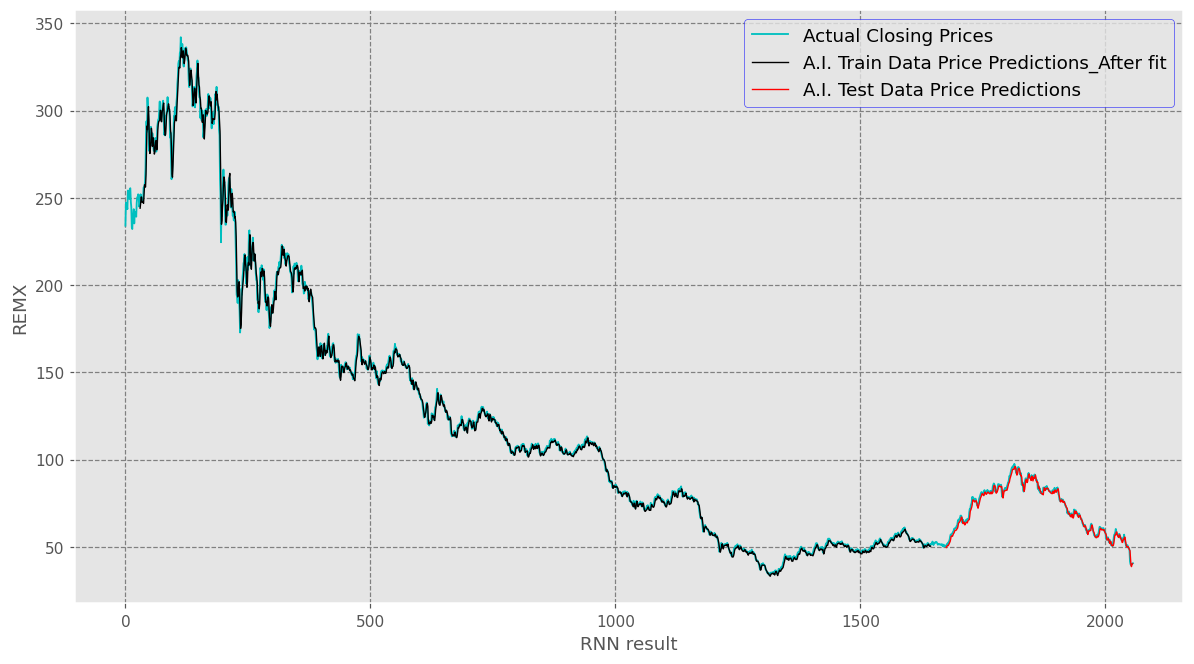

,MSE,MAE,MAPE,RMSE
RNN,20.577,2.701,2.033,4.536


In [51]:
create_plot(ds, trainPredict, testPredict, scaler, look_back, model_name, stock_name)
pd.DataFrame([[mse, mae, mape, rmse]], index=[model_name], columns=["MSE", "MAE", "MAPE", "RMSE"])

## Remake model

In [ ]:
def prepare_best_params(info_df, ds, look_back, opt):
    index = info_df.MSE.argmin()
    ratio = info_df.iloc[index, 1]
    epochs = info_df.iloc[index, 2]
    batch_size = info_df.iloc[index, 3]
    validation = info_df.iloc[index, 4]
    
    train_size = int(len(ds) * ratio)
    test_size = len(ds) - train_size
    train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]
    trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)
    
    return [trainX, trainY, testX, testY], [trainX, trainY, look_back, opt, epochs, batch_size, validation]

look_back = 30
opt = Adam(learning_rate=0.0001)
epochs = 200
batch_size = 32 
validation_split = 0.2

train_size = int(len(ds) * ratio)
    test_size = len(ds) - train_size
    train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]
    trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)
